<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/causal_method/unified_approach/tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Removing outliers, understanding the data, visualization of components for each dataset, common period for the different hospitals, data aggregation and transformation of categorical features into numerical ones.

---



---



# Loading libs and database

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

df_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/main/datasets/unified_approach/df_unified.csv"


df = pd.read_csv(df_url)



categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE_MOUV', 'WEEK', 'MONTH', 'YEAR']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df['DATE_MOUV'] = pd.to_datetime(df['DATE_MOUV'],
              format='%Y-%m-%d')  # Changed the type of date too

for column in categorical_features:
  df[column] = df[column].astype('string')

df = df.drop(['ID_REF', 'CODE_ATC', 'WEEK'], axis=1)

## 2.1 - Visualisation of data range and data composition

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75684 entries, 0 to 75683
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_SITE_RATTACHE  75684 non-null  string        
 1   HOSPI_CODE_UCD    75684 non-null  string        
 2   DATE_MOUV         75684 non-null  datetime64[ns]
 3   N_UFS             75684 non-null  int64         
 4   QUANTITY          75684 non-null  float64       
 5   MONTH             75684 non-null  int64         
 6   YEAR              75684 non-null  int64         
 7   N_ETB             75684 non-null  int64         
 8   POPULATION        75684 non-null  float64       
 9   P_MEDICAL         75684 non-null  int64         
 10  PN_MEDICAL        75684 non-null  int64         
 11  LIT_HC            75684 non-null  float64       
 12  LIT_HP            75684 non-null  float64       
 13  SEJ_MCO           75684 non-null  int64         
 14  SEJ_HAD           7568

## 2.2 - Removing outliers by hospital and by drug

In [5]:
def remove_outliers(df, columns, verbose=False, hospital = ''):
    N_macro = df.shape[0]
    new_df = pd.DataFrame()  # Create an empty DataFrame to store the filtered values
    removed_outliers = 0  # Variable to keep track of the total number of removed outliers

    for col in columns:
        for ucd_code in df['HOSPI_CODE_UCD'].unique():
            # Filter the dataframe for the specific HOSPI_CODE_UCD
            df_subset = df[df['HOSPI_CODE_UCD'] == ucd_code]
            N = df_subset.shape[0]

            # Calculate the statistics for the column within the HOSPI_CODE_UCD subset
            q25, q75 = np.percentile(df_subset[col], [25, 75])
            iqr = q75 - q25
            lower, upper = q25 - (iqr * 1.5), q75 + (iqr * 1.5)

            # Remove outliers based on the cutoff values within the HOSPI_CODE_UCD subset
            df_filtered = df_subset[(df_subset[col] >= lower) & (df_subset[col] <= upper)]
            N_new = df_filtered.shape[0]
            delta = N - N_new

            # Update the new DataFrame with the filtered values
            new_df = pd.concat([new_df, df_filtered])

            if verbose:
                if delta > 0:
                    print(f'Column: {col}')
                    print(f'HOSPI_CODE_UCD: {ucd_code}')
                    print(f'Removed outliers: {delta}')
                    print(f'Removed percentage: {(100 * delta / N):.3}%')
                    print()

            removed_outliers += delta

    print(f'Hospital: {hospital}')
    new_df.reset_index(drop=True, inplace=True)
    print('N_old:', N_macro)
    N_macro_new = new_df.shape[0]
    print('N_new:', N_macro_new)
    delta = N_macro - N_macro_new
    print(f'Total removed outliers: {(100 * delta / N_macro):.3}%')
    print()

    return new_df


In [6]:
print("-"*100)
df_wo_outliers = pd.concat([remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_1'], ["QUANTITY"], verbose = False, hospital = 'HOSPI_1'),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_2'], ["QUANTITY"], verbose = False, hospital = 'HOSPI_2'),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_3'], ["QUANTITY"], verbose = False, hospital = 'HOSPI_3'),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_4'], ["QUANTITY"], verbose = False, hospital = 'HOSPI_4')])

print()
df_wo_outliers.info()

----------------------------------------------------------------------------------------------------
Hospital: HOSPI_1
N_old: 22725
N_new: 21715
Total removed outliers: 4.44%

Hospital: HOSPI_2
N_old: 15439
N_new: 14953
Total removed outliers: 3.15%

Hospital: HOSPI_3
N_old: 27591
N_new: 26801
Total removed outliers: 2.86%

Hospital: HOSPI_4
N_old: 9929
N_new: 9638
Total removed outliers: 2.93%


<class 'pandas.core.frame.DataFrame'>
Int64Index: 73107 entries, 0 to 9637
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_SITE_RATTACHE  73107 non-null  string        
 1   HOSPI_CODE_UCD    73107 non-null  string        
 2   DATE_MOUV         73107 non-null  datetime64[ns]
 3   N_UFS             73107 non-null  int64         
 4   QUANTITY          73107 non-null  float64       
 5   MONTH             73107 non-null  int64         
 6   YEAR              73107 non-null  int64         
 7   N

## 2.3 - Define common period for data usage

In [7]:
# Group by ID_SITE_RATTACHE and calculate min and max dates
min_dates = df_wo_outliers.groupby('ID_SITE_RATTACHE')['DATE_MOUV'].min()
max_dates = df_wo_outliers.groupby('ID_SITE_RATTACHE')['DATE_MOUV'].max()

# Print min and max dates for each hospital
print("Min dates:")
for hospital, min_date in min_dates.items():
    print(f"{hospital}: {min_date}")

print("\nMax dates:")
for hospital, max_date in max_dates.items():
    print(f"{hospital}: {max_date}")

# Calculate overall min and max dates
init = min_dates.min()
ending = max_dates.max()

print(f"\nOverall Min Date: {init}")
print(f"Overall Max Date: {ending}")

common_period = pd.date_range(start=pd.Timestamp(year=init.year, month=init.month, day=1), end=pd.Timestamp(year=ending.year, month=ending.month, day=31))
df_cp = df_wo_outliers[(df_wo_outliers["DATE_MOUV"] >= init) & (df_wo_outliers["DATE_MOUV"] <= ending)].copy()

Min dates:
HOSPI_1: 2013-06-18 00:00:00
HOSPI_2: 2017-03-30 00:00:00
HOSPI_3: 2014-05-20 00:00:00
HOSPI_4: 2016-01-01 00:00:00

Max dates:
HOSPI_1: 2019-12-30 00:00:00
HOSPI_2: 2019-12-30 00:00:00
HOSPI_3: 2019-12-30 00:00:00
HOSPI_4: 2019-03-05 00:00:00

Overall Min Date: 2013-06-18 00:00:00
Overall Max Date: 2019-12-30 00:00:00


## 2.4 - Fill gaps in data for eache medicine and for each hospital

In [8]:
def fill_gap_timeseries(df_cp, common_period,hospital='', visu=False):
    for medicine in df.HOSPI_CODE_UCD.unique():

        data = {
            'DATE_MOUV': list(common_period),
            'HOSPI_CODE_UCD': [medicine] * len(common_period)
        }

        df_medicine = pd.DataFrame(data)

        df_medicine_resampled = pd.merge(df_medicine, df_cp.astype({'DATE_MOUV': 'datetime64[ns]'}),
                                         on=['DATE_MOUV', 'HOSPI_CODE_UCD'], how='left')

        df_medicine_resampled = pd.merge(df_medicine, df_cp, on=['DATE_MOUV', 'HOSPI_CODE_UCD'], how='left')
        df_medicine_resampled['N_ETB'] = df_medicine_resampled['N_ETB'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['N_UFS'] = df_medicine_resampled['N_UFS'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['POPULATION'] = df_medicine_resampled['POPULATION'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['P_MEDICAL'] = df_medicine_resampled['P_MEDICAL'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['PN_MEDICAL'] = df_medicine_resampled['PN_MEDICAL'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['LIT_HC'] = df_medicine_resampled['LIT_HC'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['LIT_HP'] = df_medicine_resampled['LIT_HP'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_MCO'] = df_medicine_resampled['SEJ_MCO'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_HAD'] = df_medicine_resampled['SEJ_HAD'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_PSY'] = df_medicine_resampled['SEJ_PSY'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_SSR'] = df_medicine_resampled['SEJ_SSR'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_SLD'] = df_medicine_resampled['SEJ_SLD'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['QUANTITY'] = df_medicine_resampled['QUANTITY'].fillna(0)

        df_cp = df_cp[df_cp["HOSPI_CODE_UCD"] != medicine]
        df_cp = pd.concat([df_cp, df_medicine_resampled], ignore_index=True)

    df_cp = df_cp.sort_values(by=['DATE_MOUV']).reset_index(drop=True)
    df_cp["WEEK"] = df_cp["DATE_MOUV"].dt.isocalendar().week
    df_cp["YEAR"] = df_cp["DATE_MOUV"].dt.year
    df_cp["MONTH"] = df_cp["DATE_MOUV"].dt.month
    df_cp["ID_SITE_RATTACHE"] = hospital
    x = common_period

    if visu:
        fig, axs = plt.subplots(7, 3, figsize=(25, 25))

        for i, medicine in enumerate(df.HOSPI_CODE_UCD.unique()):
            row = i // 3  # Calculate the row index
            col = i % 3   # Calculate the column index

            ax = axs[row, col]  # Get the corresponding subplot

            y = df_cp[df_cp["HOSPI_CODE_UCD"] == medicine]["QUANTITY"]
            ax.scatter(x, y)
            ax.set_title(f'Consumption quantity of medicine: {medicine} per day')
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            ax.grid()

        plt.tight_layout()
        plt.show()

    return df_cp


In [9]:
df_h1_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_1'].copy(), common_period, 'HOSPI_1')
df_h2_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_2'].copy(), common_period, 'HOSPI_2')
df_h3_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_3'].copy(), common_period, 'HOSPI_3')
df_h4_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_4'].copy(), common_period, 'HOSPI_4')

df_cp_filled = pd.concat([df_h1_cp_filled, df_h2_cp_filled, df_h3_cp_filled, df_h4_cp_filled])
df_cp_filled = df_cp_filled.sort_values(by=['DATE_MOUV', 'HOSPI_CODE_UCD', 'ID_SITE_RATTACHE']).reset_index(drop=True)
df_cp_filled

ID_SITE_RATTACHE HOSPI_CODE_UCD  DATE_MOUV  N_UFS  QUANTITY  MONTH  \
0               HOSPI_1  3400890837149 2013-06-01    1.0       0.0      6   
1               HOSPI_2  3400890837149 2013-06-01    1.0       0.0      6   
2               HOSPI_3  3400890837149 2013-06-01    2.0       0.0      6   
3               HOSPI_4  3400890837149 2013-06-01    1.0       0.0      6   
4               HOSPI_1  3400891191226 2013-06-01    1.0       0.0      6   
...                 ...            ...        ...    ...       ...    ...   
202018          HOSPI_4  3400893826706 2019-12-31    1.0       0.0     12   
202019          HOSPI_1  3400893875490 2019-12-31    1.0       0.0     12   
202020          HOSPI_2  3400893875490 2019-12-31   23.0       0.0     12   
202021          HOSPI_3  3400893875490 2019-12-31   14.0       0.0     12   
202022          HOSPI_4  3400893875490 2019-12-31    1.0       0.0     12   

        YEAR  N_ETB  POPULATION  P_MEDICAL  PN_MEDICAL  LIT_HC  LIT_HP  \
0       2013   12.0    571675.0      683.0      5270.0  1471.0   112.0   
1       2013    5.0    539067.0      714.0      5001.0  1157.0   187.0   
2       2013   50.0   1107398.0     1158.0      7129.0  2063.0   521.0   
3       2013   39.0   1835903.0     2526.0     15604.0  4536.0   470.0   
4       2013   12.0    571675.0      683.0      5270.0  1471.0   112.0   
...      ...    ...         ...        ...         ...     ...     ...   
202018  2019   39.0   1871364.0     2639.0     15774.0  4530.0   514.0   
202019  2019   12.0    569894.0      843.0      5438.0  1353.0   100.0   
202020  2019    5.0    542302.0      706.0      5013.0  1141.0   141.0   
202021  2019   50.0   1171739.0     1318.0      7578.0  2011.0   529.0   
202022  2019   39.0   1871364.0     2639.0     15774.0  4530.0   514.0   

         SEJ_MCO  SEJ_HAD  SEJ_PSY  SEJ_SSR  SEJ_SLD  WEEK  
0        72785.0      0.0      0.0   1049.0    109.0    22  
1        75420.0      0.0   1236.0    261.0      0.0    22  
2       117781.0    594.0   2903.0   1302.0     97.0    22  
3       247827.0      0.0     22.0   7902.0    163.0    22  
4        72785.0      0.0      0.0   1049.0    109.0    22  
...          ...      ...      ...      ...      ...   ...  
202018  263011.0      0.0    770.0   8031.0    172.0     1  
202019   82997.0      0.0      0.0   1141.0     92.0     1  
202020   76593.0      0.0   1007.0    206.0      0.0     1  
202021  116793.0   1099.0   2297.0   1169.0    124.0     1  
202022  263011.0      0.0    770.0   8031.0    172.0     1  

[202023 rows x 19 columns]

## 2.5 - Aggregate data by drug, hospital, year and month

In [10]:
def aggregate_dataframe(df):

    df['DATE'] = df['DATE_MOUV'].dt.strftime('%Y-%m')
    df.drop('DATE_MOUV', axis=1, inplace=True)

    df = df.groupby(["ID_SITE_RATTACHE", "HOSPI_CODE_UCD", "YEAR", "MONTH"], as_index=False).agg({
        'QUANTITY': np.sum,
        'N_UFS': np.median,
        'DATE':'first',
        'N_ETB': np.median,
        'POPULATION': np.median,
        'P_MEDICAL': np.median,
        'PN_MEDICAL': np.median,
        'LIT_HC': np.median,
        'LIT_HP': np.median,
        'SEJ_MCO': np.median,
        'SEJ_HAD': np.median,
        'SEJ_PSY': np.median,
        'SEJ_SSR': np.median,
        'SEJ_SLD': np.median
    })

    df.sort_values(by=['DATE', 'HOSPI_CODE_UCD', 'ID_SITE_RATTACHE'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [11]:
# Grouping the different datasets divided by hospital
df_aggregated = aggregate_dataframe(df_cp_filled.copy())
df_aggregated

ID_SITE_RATTACHE HOSPI_CODE_UCD  YEAR  MONTH  QUANTITY  N_UFS     DATE  \
0             HOSPI_1  3400890837149  2013      6       0.0    1.0  2013-06   
1             HOSPI_2  3400890837149  2013      6       0.0    1.0  2013-06   
2             HOSPI_3  3400890837149  2013      6       0.0    2.0  2013-06   
3             HOSPI_4  3400890837149  2013      6       0.0    1.0  2013-06   
4             HOSPI_1  3400891191226  2013      6      10.0    1.0  2013-06   
...               ...            ...   ...    ...       ...    ...      ...   
6631          HOSPI_4  3400893826706  2019     12       0.0    1.0  2019-12   
6632          HOSPI_1  3400893875490  2019     12       0.0    1.0  2019-12   
6633          HOSPI_2  3400893875490  2019     12    6870.0   12.0  2019-12   
6634          HOSPI_3  3400893875490  2019     12   12144.0   15.0  2019-12   
6635          HOSPI_4  3400893875490  2019     12       0.0    1.0  2019-12   

      N_ETB  POPULATION  P_MEDICAL  PN_MEDICAL  LIT_HC  LIT_HP   SEJ_MCO  \
0      12.0    571675.0      683.0      5270.0  1471.0   112.0   72785.0   
1       5.0    539067.0      714.0      5001.0  1157.0   187.0   75420.0   
2      50.0   1107398.0     1158.0      7129.0  2063.0   521.0  117781.0   
3      39.0   1835903.0     2526.0     15604.0  4536.0   470.0  247827.0   
4      12.0    571675.0      683.0      5270.0  1471.0   112.0   72785.0   
...     ...         ...        ...         ...     ...     ...       ...   
6631   39.0   1871364.0     2639.0     15774.0  4530.0   514.0  263011.0   
6632   12.0    569894.0      843.0      5438.0  1353.0   100.0   82997.0   
6633    5.0    542302.0      706.0      5013.0  1141.0   141.0   76593.0   
6634   50.0   1171739.0     1318.0      7578.0  2011.0   529.0  116793.0   
6635   39.0   1871364.0     2639.0     15774.0  4530.0   514.0  263011.0   

      SEJ_HAD  SEJ_PSY  SEJ_SSR  SEJ_SLD  
0         0.0      0.0   1049.0    109.0  
1         0.0   1236.0    261.0      0.0  
2       594.0   2903.0   1302.0     97.0  
3         0.0     22.0   7902.0    163.0  
4         0.0      0.0   1049.0    109.0  
...       ...      ...      ...      ...  
6631      0.0    770.0   8031.0    172.0  
6632      0.0      0.0   1141.0     92.0  
6633      0.0   1007.0    206.0      0.0  
6634   1099.0   2297.0   1169.0    124.0  
6635      0.0    770.0   8031.0    172.0  

[6636 rows x 18 columns]

## 2.6 - Visualize period and replace outliers with median

In [12]:
df_resampled = df_aggregated.copy()

In [13]:
import plotly.express as px

for medicine in df_resampled['HOSPI_CODE_UCD'].unique():
    filtered_df = df_resampled[df_resampled['HOSPI_CODE_UCD'] == medicine]

    fig = px.scatter(filtered_df, x='DATE', y='QUANTITY', color='ID_SITE_RATTACHE',
                     title=f'Scatter Plot of Quantity vs. Date for medicine {medicine}',
                     labels={'DATE': 'DATE', 'QUANTITY': 'QUANTITY'},
                     width=1000, height=600)

    fig.update_layout(xaxis=dict(showgrid=True, tickangle=-45),
                      yaxis=dict(showgrid=True),
                      showlegend=True)

    fig.show()
    print()

## 2.7 - Transform categorical features

In [14]:
hospi_codes = df_resampled['ID_SITE_RATTACHE'].values
df_encoded = pd.get_dummies(df_resampled, columns=['MONTH', 'YEAR', 'ID_SITE_RATTACHE'], prefix=['MONTH', 'YEAR', 'HOSPI'], drop_first=False)
df_encoded['ID_SITE_RATTACHE'] = hospi_codes
df_encoded

HOSPI_CODE_UCD  QUANTITY  N_UFS     DATE  N_ETB  POPULATION  P_MEDICAL  \
0     3400890837149       0.0    1.0  2013-06   12.0    571675.0      683.0   
1     3400890837149       0.0    1.0  2013-06    5.0    539067.0      714.0   
2     3400890837149       0.0    2.0  2013-06   50.0   1107398.0     1158.0   
3     3400890837149       0.0    1.0  2013-06   39.0   1835903.0     2526.0   
4     3400891191226      10.0    1.0  2013-06   12.0    571675.0      683.0   
...             ...       ...    ...      ...    ...         ...        ...   
6631  3400893826706       0.0    1.0  2019-12   39.0   1871364.0     2639.0   
6632  3400893875490       0.0    1.0  2019-12   12.0    569894.0      843.0   
6633  3400893875490    6870.0   12.0  2019-12    5.0    542302.0      706.0   
6634  3400893875490   12144.0   15.0  2019-12   50.0   1171739.0     1318.0   
6635  3400893875490       0.0    1.0  2019-12   39.0   1871364.0     2639.0   

      PN_MEDICAL  LIT_HC  LIT_HP  ...  YEAR_2015  YEAR_2016  YEAR_2017  \
0         5270.0  1471.0   112.0  ...          0          0          0   
1         5001.0  1157.0   187.0  ...          0          0          0   
2         7129.0  2063.0   521.0  ...          0          0          0   
3        15604.0  4536.0   470.0  ...          0          0          0   
4         5270.0  1471.0   112.0  ...          0          0          0   
...          ...     ...     ...  ...        ...        ...        ...   
6631     15774.0  4530.0   514.0  ...          0          0          0   
6632      5438.0  1353.0   100.0  ...          0          0          0   
6633      5013.0  1141.0   141.0  ...          0          0          0   
6634      7578.0  2011.0   529.0  ...          0          0          0   
6635     15774.0  4530.0   514.0  ...          0          0          0   

      YEAR_2018  YEAR_2019  HOSPI_HOSPI_1  HOSPI_HOSPI_2  HOSPI_HOSPI_3  \
0             0          0              1              0              0   
1             0          0              0              1              0   
2             0          0              0              0              1   
3             0          0              0              0              0   
4             0          0              1              0              0   
...         ...        ...            ...            ...            ...   
6631          0          1              0              0              0   
6632          0          1              1              0              0   
6633          0          1              0              1              0   
6634          0          1              0              0              1   
6635          0          1              0              0              0   

      HOSPI_HOSPI_4  ID_SITE_RATTACHE  
0                 0           HOSPI_1  
1                 0           HOSPI_2  
2                 0           HOSPI_3  
3                 1           HOSPI_4  
4                 0           HOSPI_1  
...             ...               ...  
6631              1           HOSPI_4  
6632              0           HOSPI_1  
6633              0           HOSPI_2  
6634              0           HOSPI_3  
6635              1           HOSPI_4  

[6636 rows x 39 columns]

# 3 - Understanding feautures and selecting the most important ones regarding the consumption

In [15]:
medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

In [16]:
import pandas as pd
import numpy as np

def calculate_moving_average(df, column, period):
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original

    # Iterate over each unique value of 'HOSPI_CODE_UCD' (medicine)
    for medicine in df_copy['HOSPI_CODE_UCD'].unique():
        mask = df_copy['HOSPI_CODE_UCD'] == medicine
        ma_column = column + '_MA'

        # Calculate the moving average
        vector = df_copy.loc[mask, column].values

        # Use pandas rolling() function to calculate the moving average
        moving_average = pd.Series(vector).rolling(window=period).mean()

        # Store the moving average values in the DataFrame
        df_copy.loc[mask, ma_column] = moving_average

    return df_copy


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_ma(df, column, period):
    df_copy = df.copy()
    df_copy['DATE'] = pd.to_datetime(df_copy['DATE'])

    plt.figure(figsize=(15, 8))

    # Group the data by 'HOSPI_CODE_UCD'
    grouped_df = df_copy.groupby('HOSPI_CODE_UCD')

    # Create subplots for each group
    for code, group in grouped_df:
        group['MA'] = group[column].rolling(window=period, min_periods=1).mean()
        plt.plot(group['DATE'], group['MA'], linewidth=2, label=f'Medicine {code}')

    plt.xlabel('DATE')
    plt.ylabel('Quantity')
    plt.title(f'Scatter Plot of Quantity Moving Average for the Period of: {period} months')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='Medicine')
    plt.grid(True)
    plt.show()

# Example usage:
# scatterplot_quantity(df, 'QUANTITY', 3)  # Replace df with your DataFrame


In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

def ts_features(df):
    for hospital in df.ID_SITE_RATTACHE.unique():
        for medicine in medicines:
            series = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital)]["QUANTITY"]
            series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital)]["DATE"])
            result = seasonal_decompose(series, model='additive', period = 6)
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "TREND"] = result.trend.values
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "SEASONAL"] = result.seasonal.values
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "RESID"] = result.resid.values
    df.fillna(0, inplace=True)  # Replace NaN values with zero

In [19]:
ts_features(df_encoded)

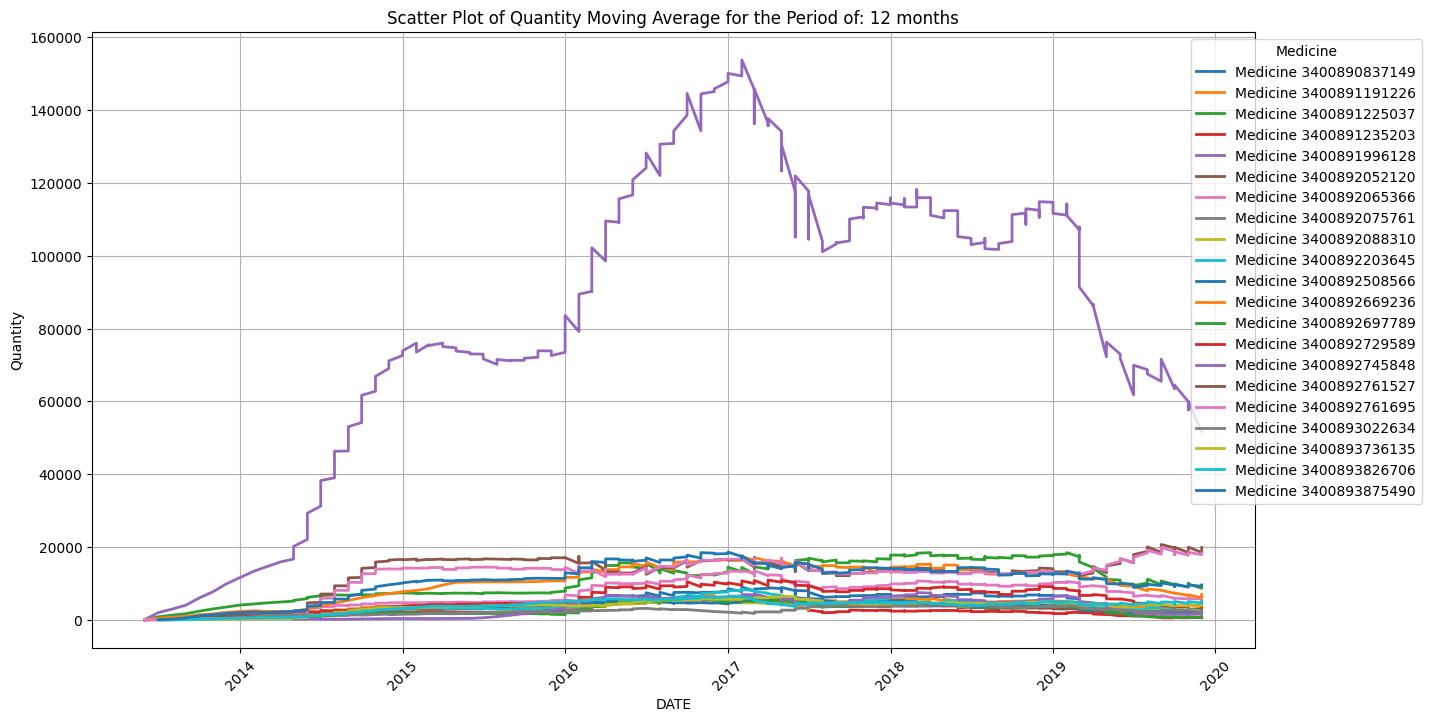

In [20]:
df_ma_6 = calculate_moving_average(df_encoded[df_encoded['QUANTITY'] > 0].copy(), 'QUANTITY', 12)
df_ma_6 = df_ma_6.sort_index(axis=1).reset_index(drop=True)
plot_ma(df_ma_6, 'QUANTITY', 12)

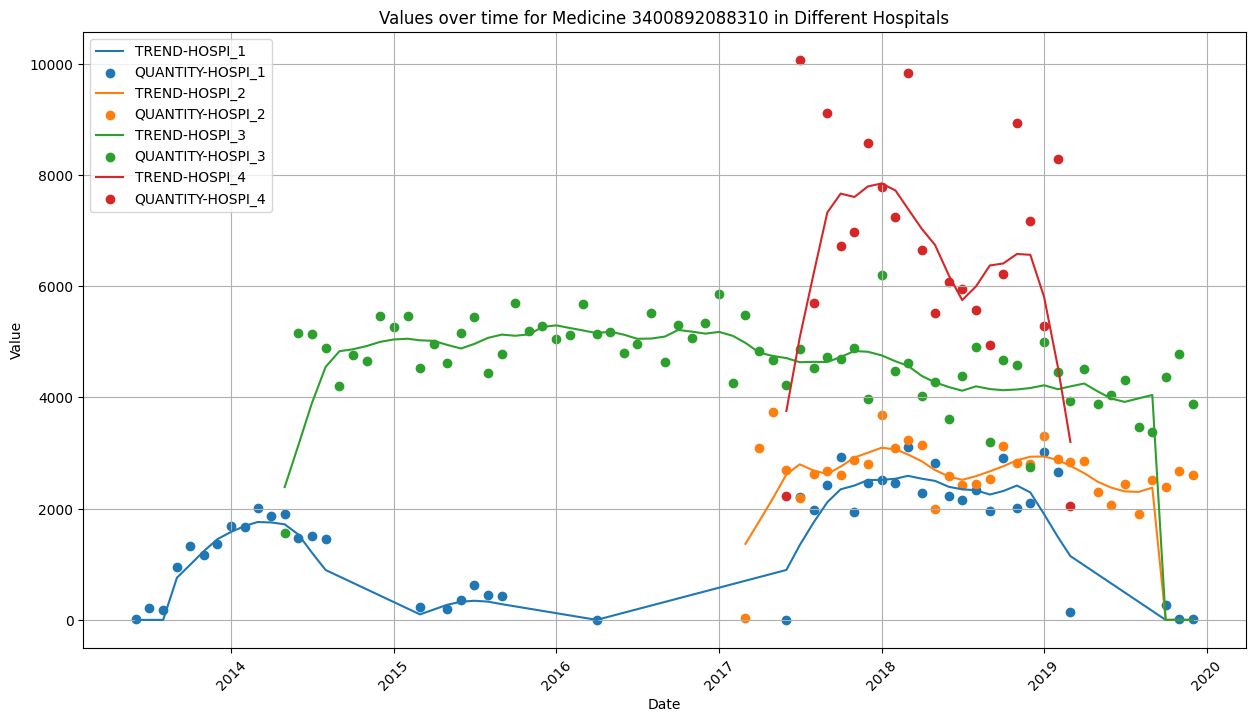

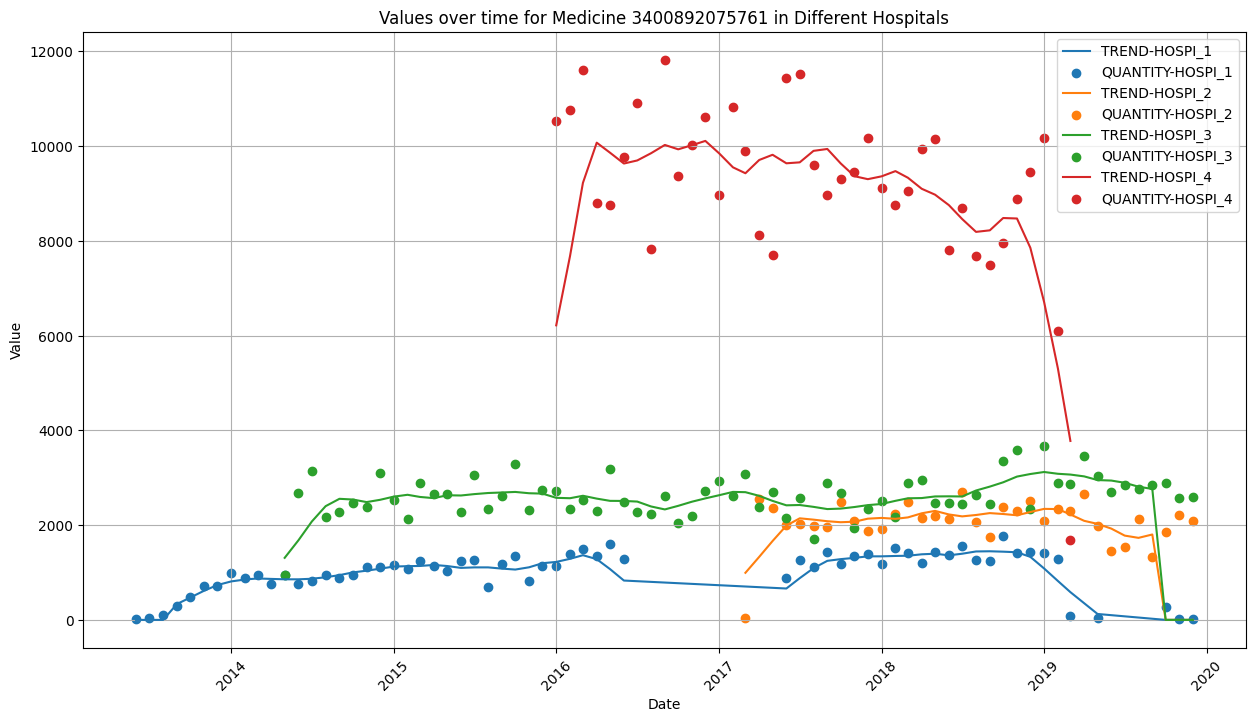

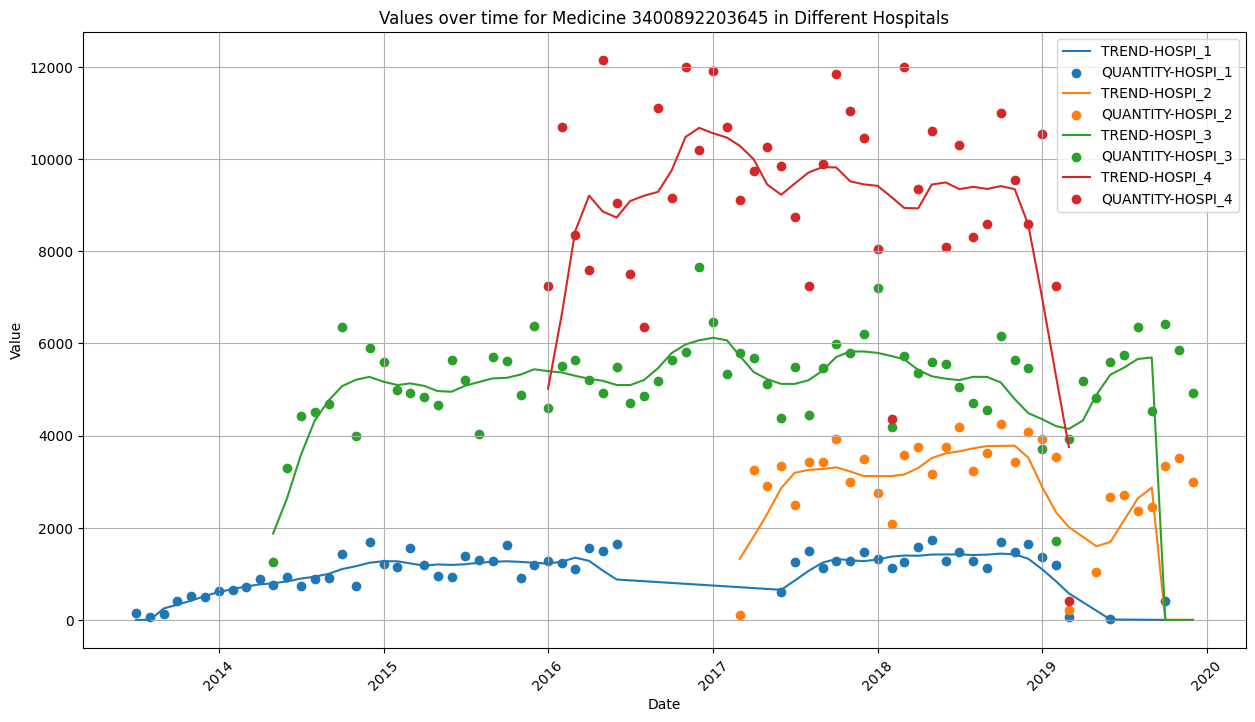

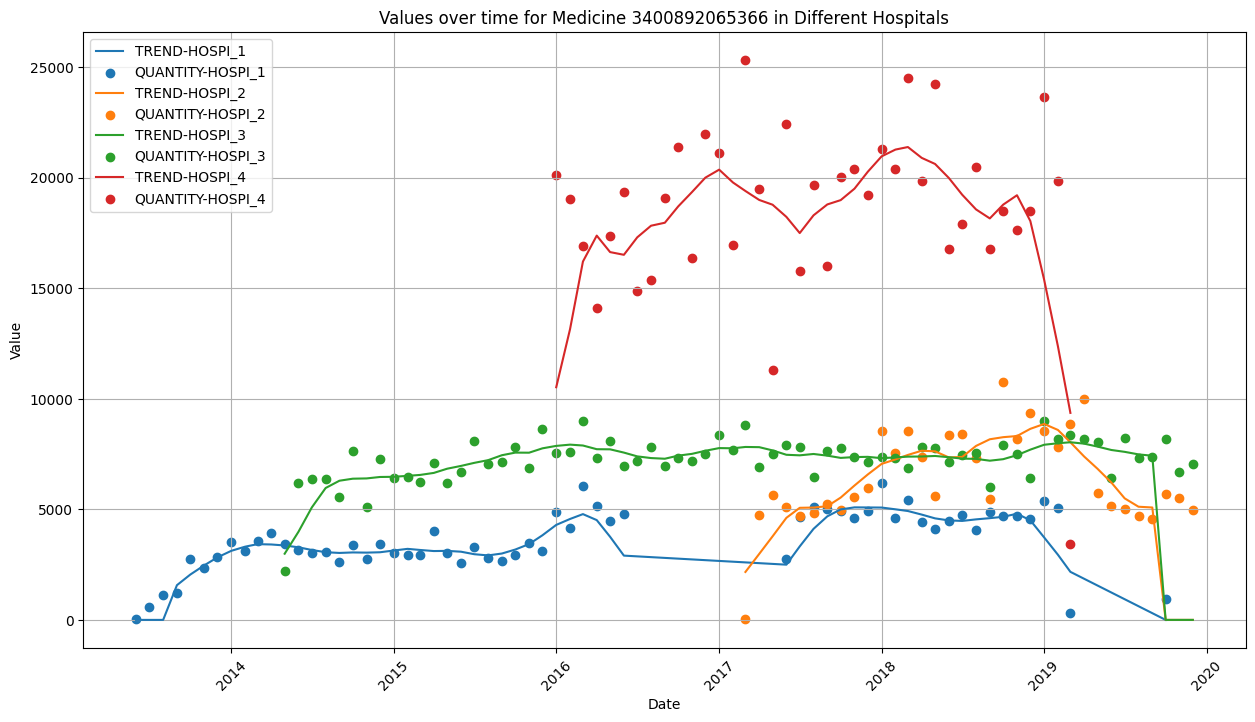

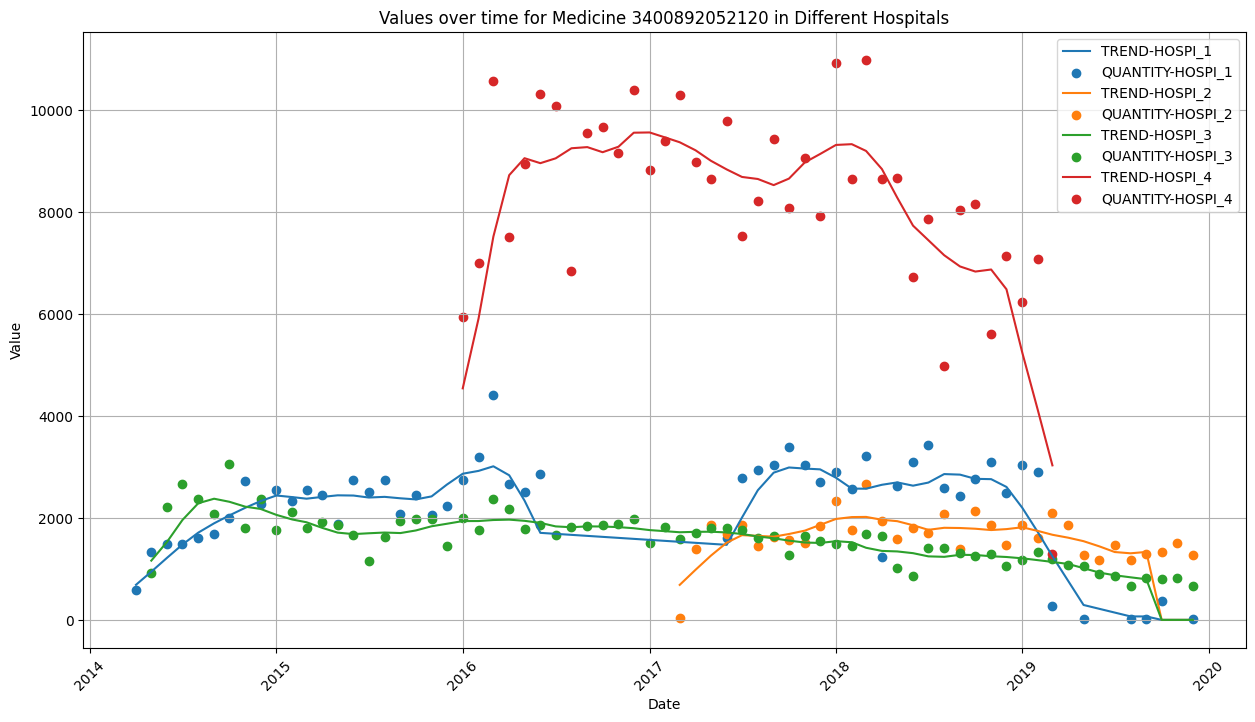

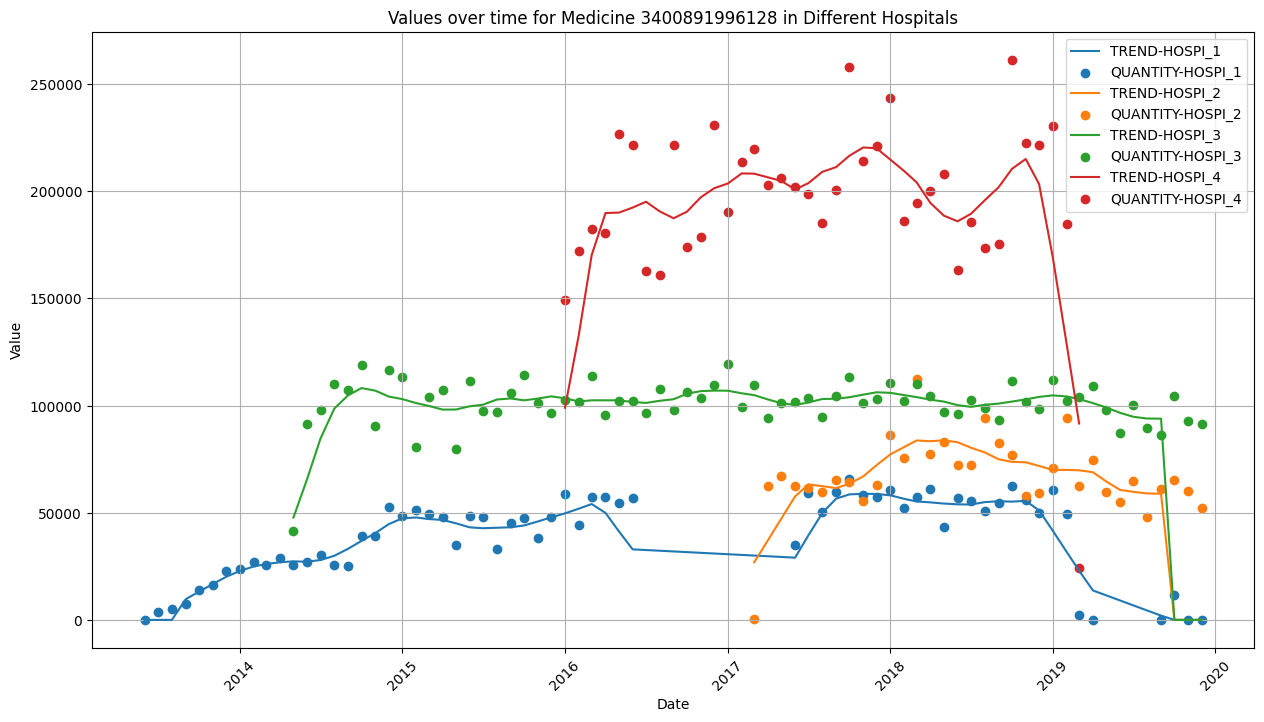

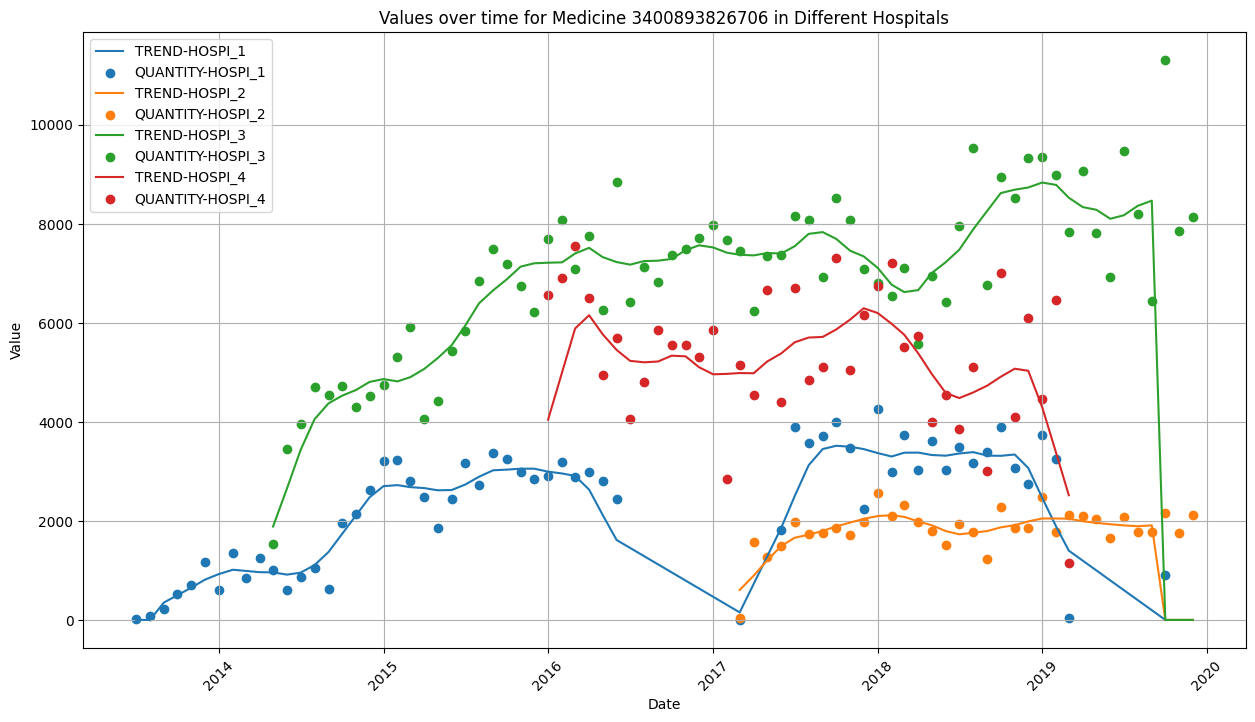

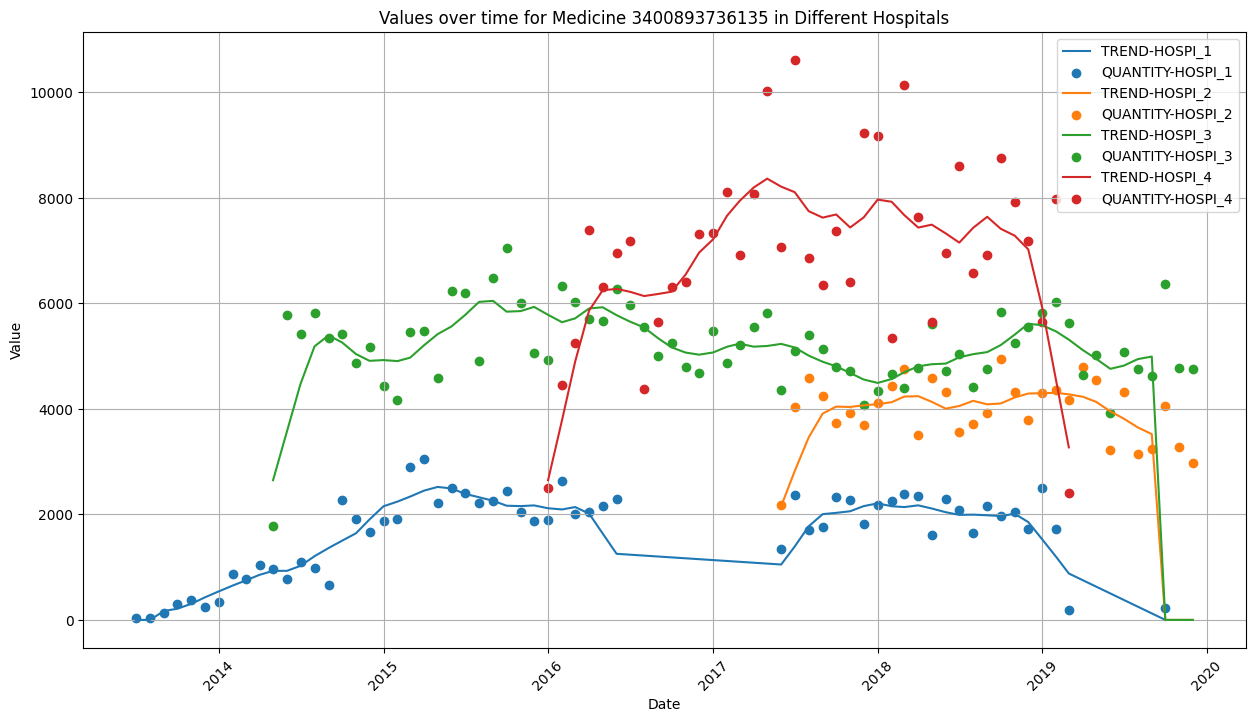

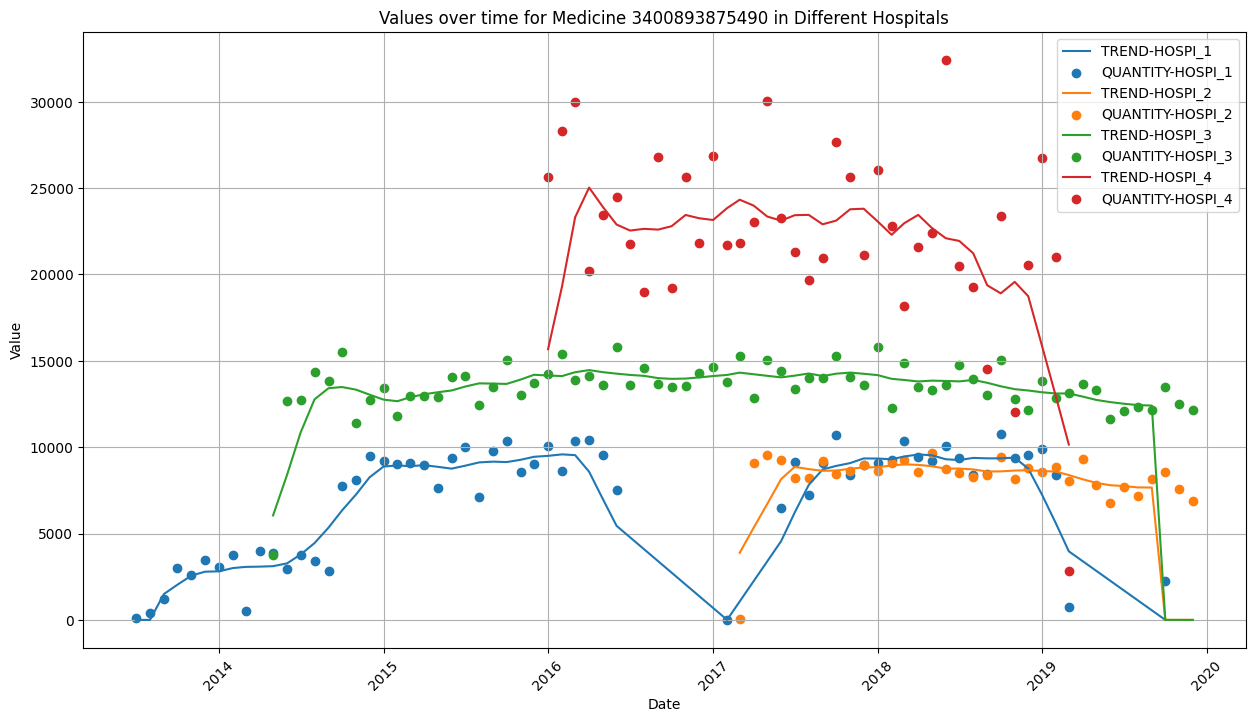

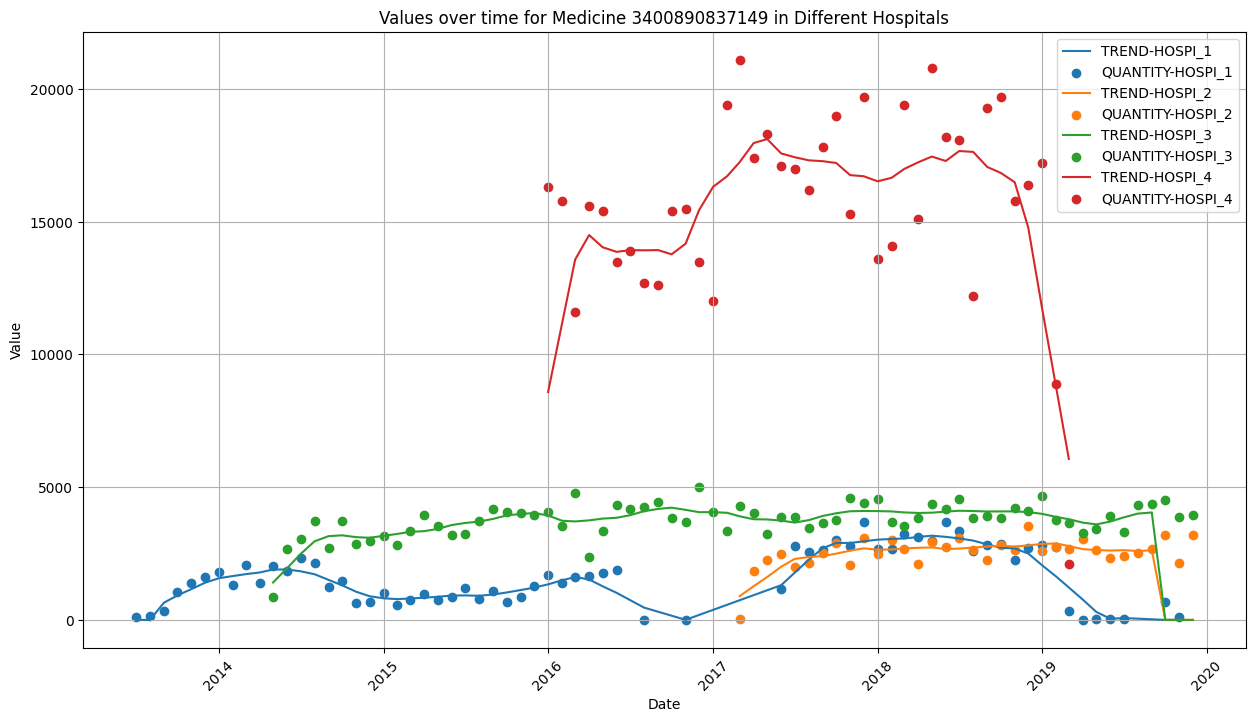

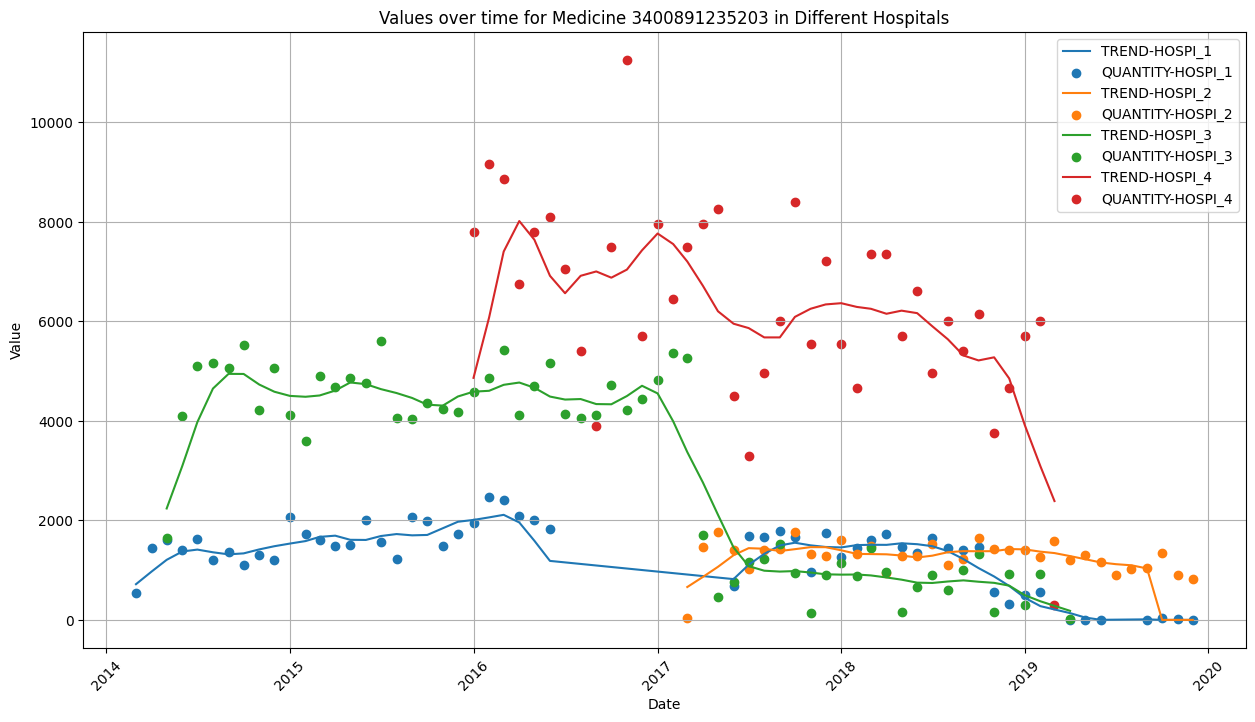

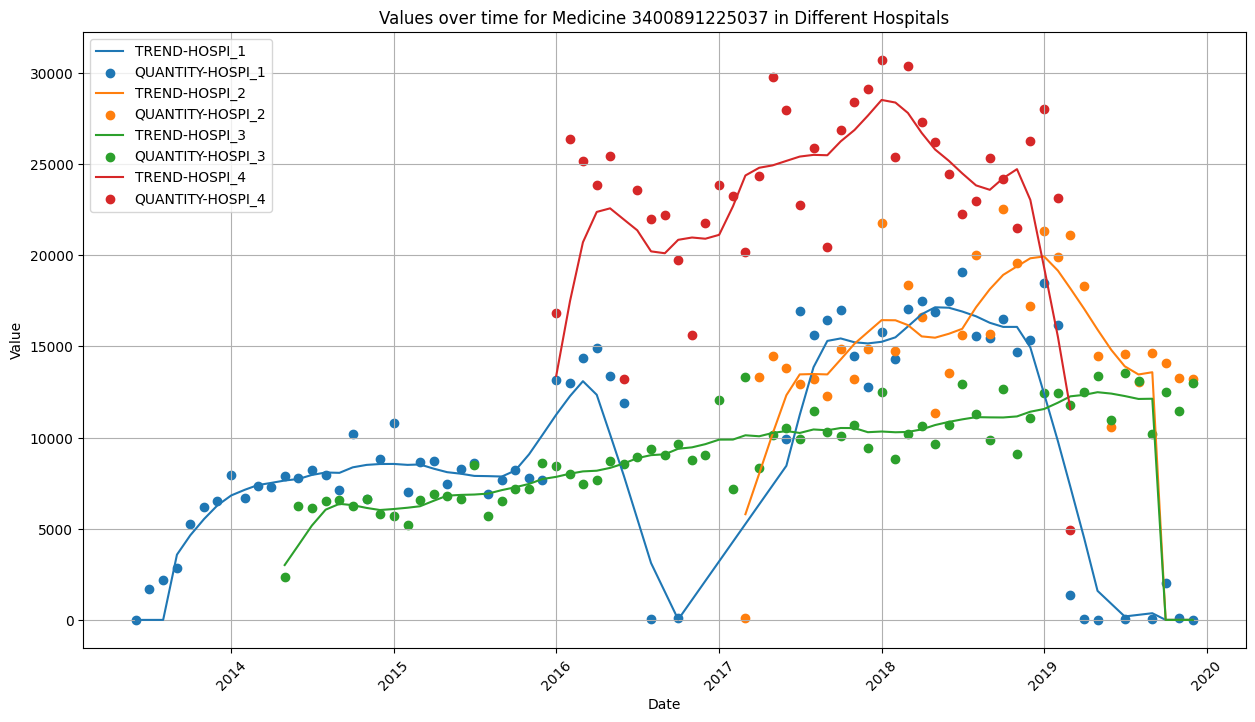

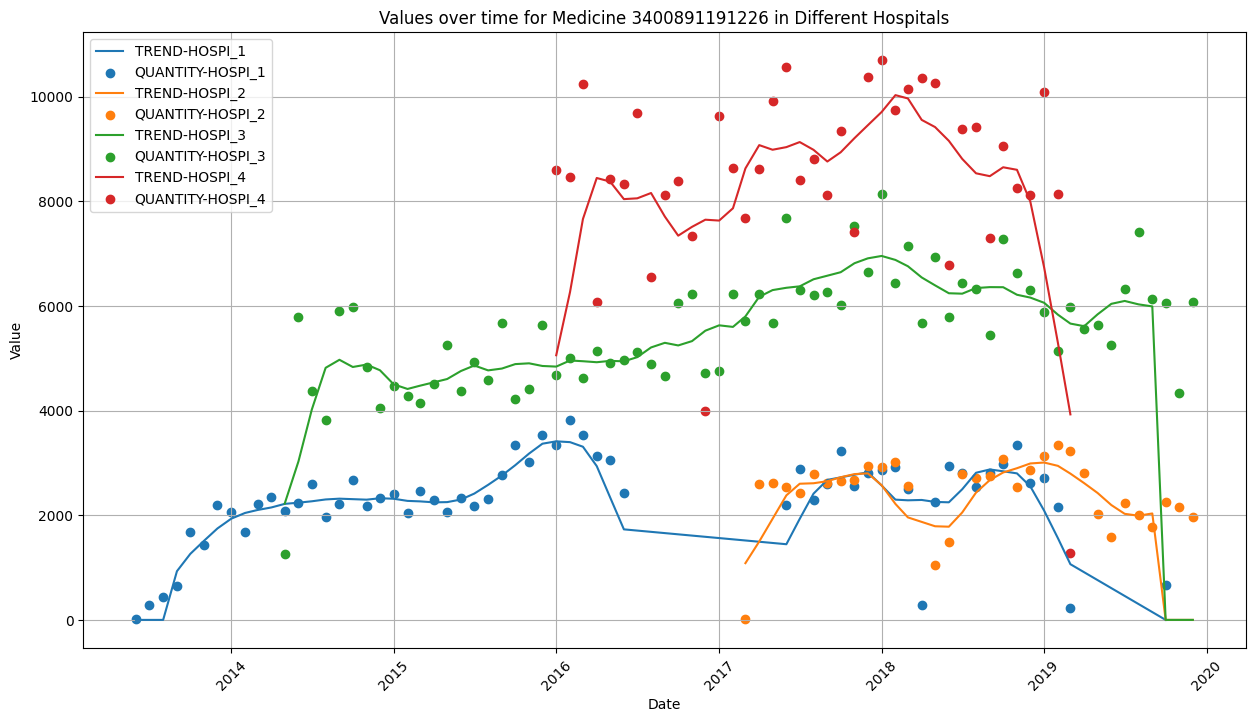

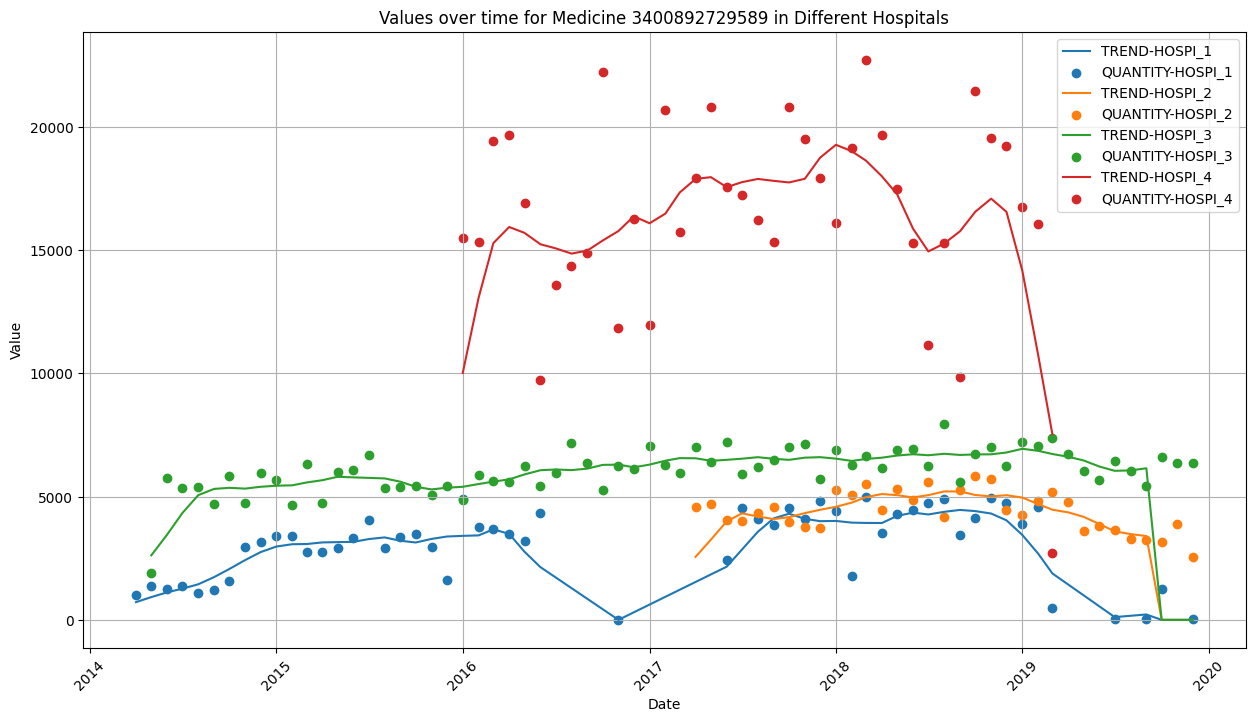

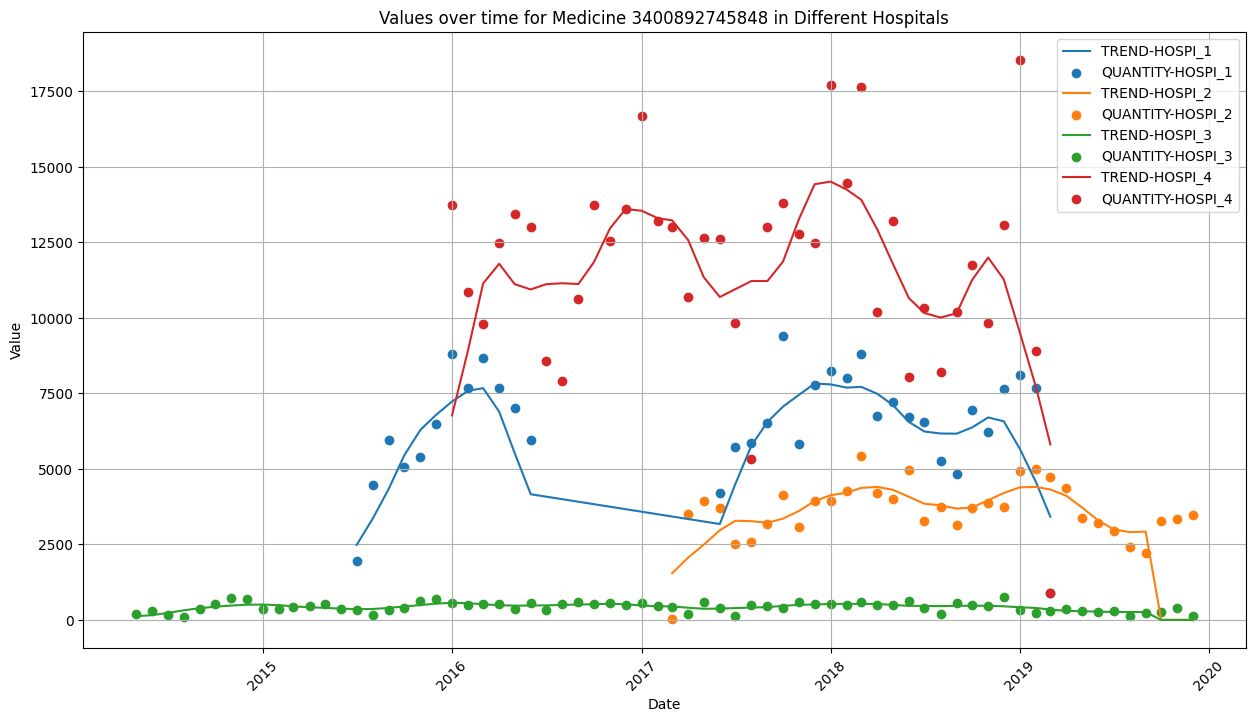

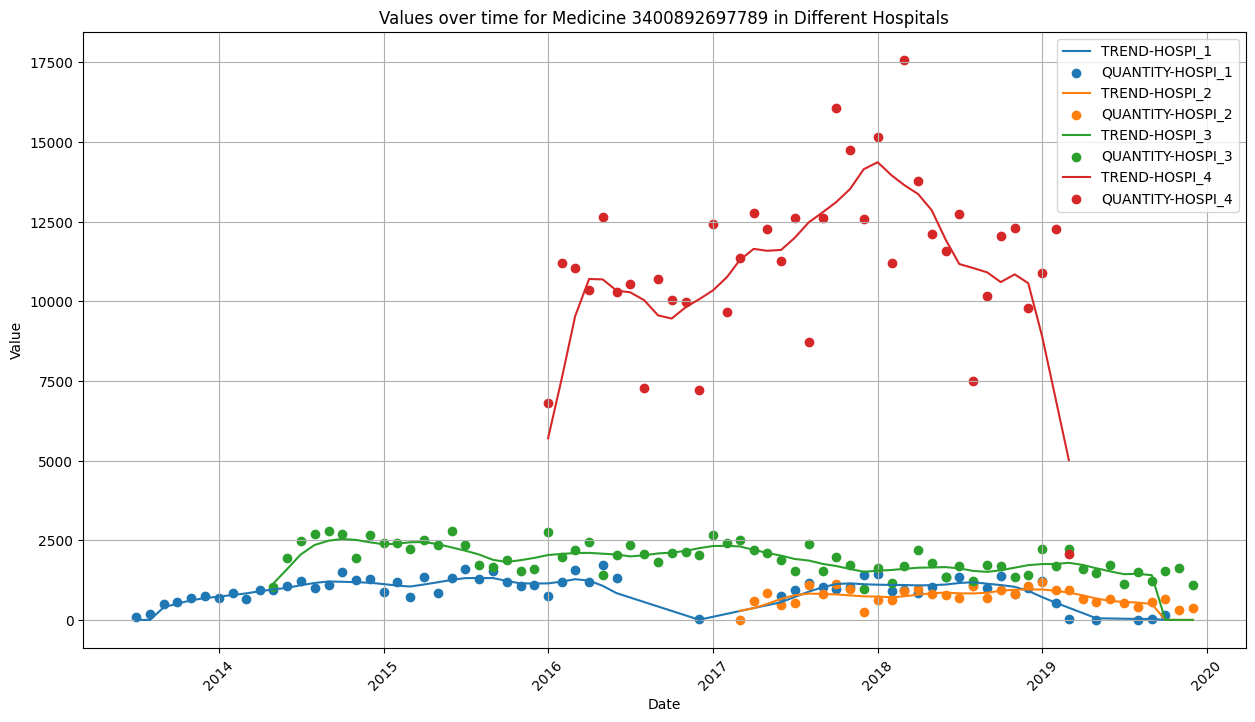

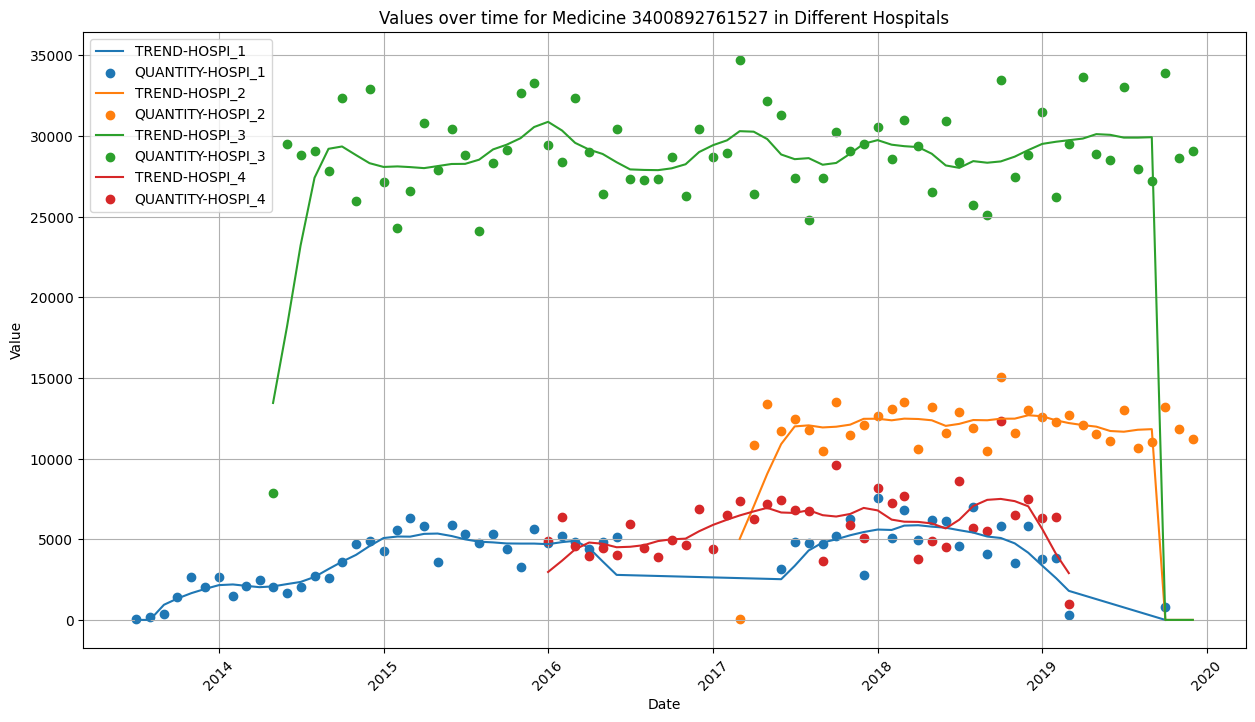

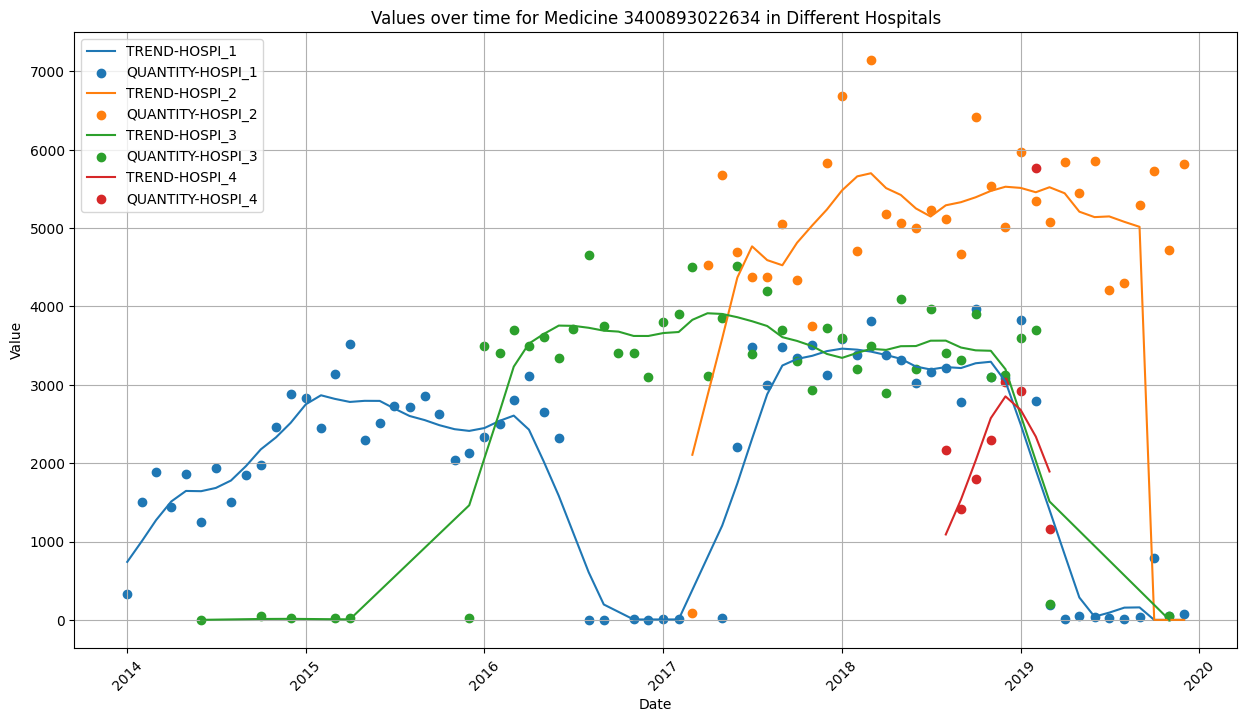

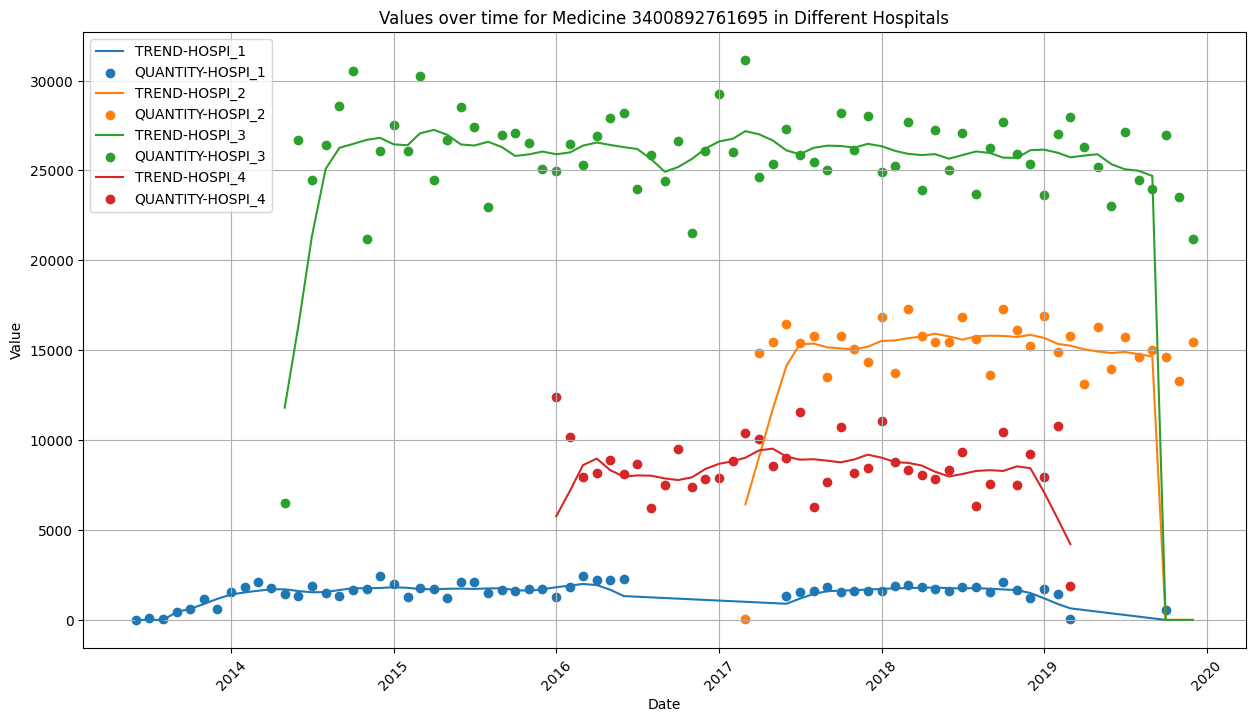

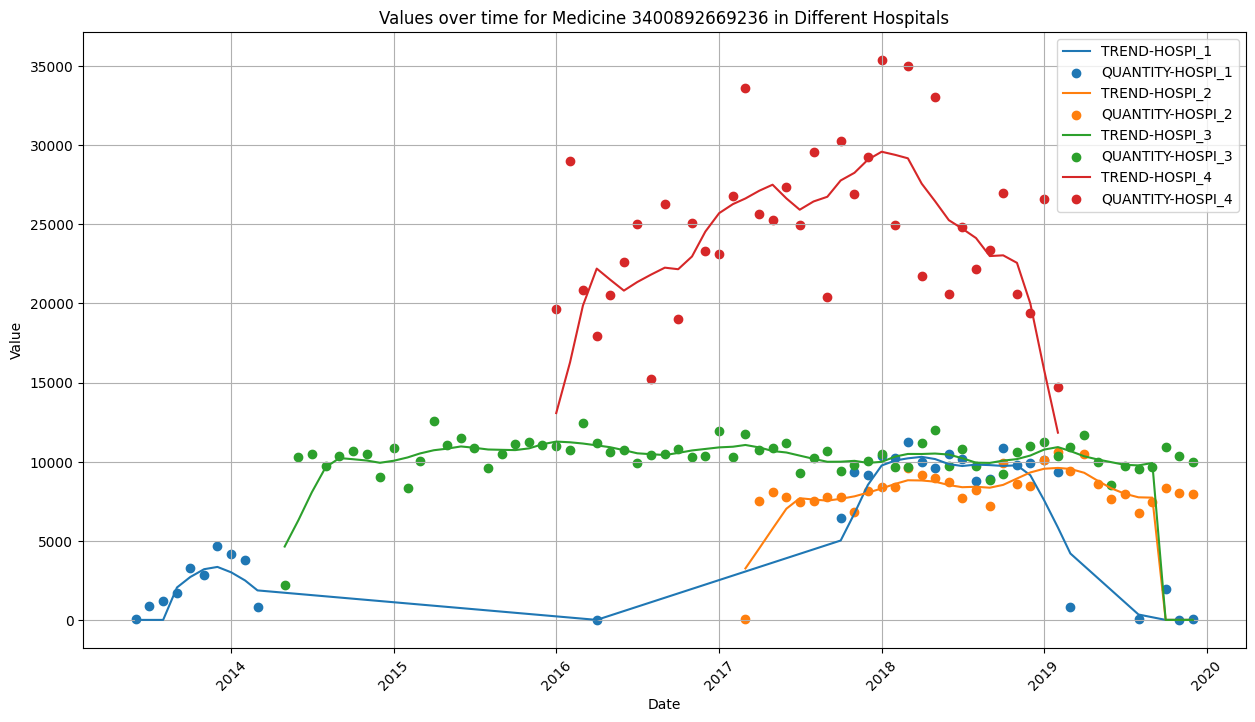

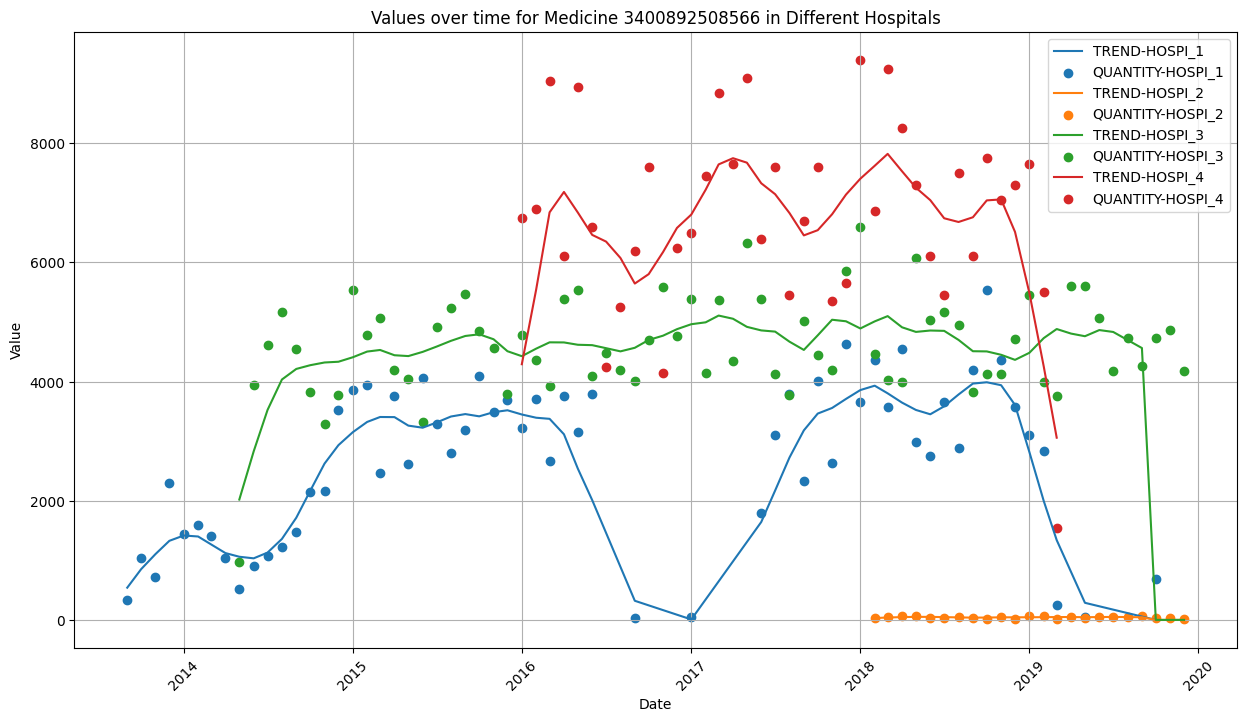

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

for medicine in medicines:
    fig, ax = plt.subplots(figsize=(15, 8))

    for hospi in ['HOSPI_1', 'HOSPI_2', 'HOSPI_3', 'HOSPI_4']:
        subset = df_ma_6[(df_ma_6["HOSPI_CODE_UCD"] == medicine) & (df_ma_6["ID_SITE_RATTACHE"] == hospi) & (df_ma_6["QUANTITY"] > 0)].copy()
        subset['DATE'] = pd.to_datetime(subset['DATE'])
        x = subset["DATE"]
        y1 = subset['TREND']
        y3 = subset['QUANTITY']
        ax.plot(x, y1, label='TREND-' + hospi)
        ax.scatter(x, y3, label='QUANTITY-' + hospi)

    ax.set_xlabel('Date')
    ax.set_ylabel('Value')  # Replace with your actual ylabel
    ax.set_title(f'Values over time for Medicine {medicine} in Different Hospitals')
    ax.legend()

    # Set x-axis date locator and formatter
    date_locator = mdates.AutoDateLocator()
    date_formatter = mdates.AutoDateFormatter(date_locator)
    ax.xaxis.set_major_locator(date_locator)
    ax.xaxis.set_major_formatter(date_formatter)

    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis tick labels
    ax.grid(True)

    plt.show()
    print()


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_shared_period(df, medicine_a, medicine_b, hospital_a, hospital_b, start_date, end_date):
  df['DATE'] = pd.to_datetime(df['DATE'])  # Convert the 'DATE' column to datetime format
  start_date = pd.to_datetime(start_date)
  end_date = pd.to_datetime(end_date)

  ts1 = df[(df['HOSPI_CODE_UCD'] == medicine_a) &
            (df['QUANTITY'] > 0) &
            (df['ID_SITE_RATTACHE'] == hospital_a) &
            (df['DATE'] >= start_date) &
            (df['DATE'] <= end_date)][['DATE', 'TREND', 'QUANTITY']].copy()

  ts2 = df[(df['HOSPI_CODE_UCD'] == medicine_b) &
            (df['QUANTITY'] > 0) &
            (df['ID_SITE_RATTACHE'] == hospital_b) &
            (df['DATE'] >= start_date) &
            (df['DATE'] <= end_date)][['DATE', 'TREND', 'QUANTITY']].copy()

  ts1['DATE'] = pd.to_datetime(ts1['DATE'])
  ts2['DATE'] = pd.to_datetime(ts2['DATE'])

  if hospital_a == hospital_b:
      str_hospital = hospital_a
  else:
      str_hospital = hospital_a + ' and ' + hospital_b

  fig, ax = plt.subplots(figsize=(15, 8))

  ax.scatter(ts1['DATE'], ts1['QUANTITY'], label=f'QUANTITY-{medicine_A}' + f'_{hospital_A}', color='black', marker='X', s=50)
  ax.scatter(ts2['DATE'], ts2['QUANTITY'], label=f'QUANTITY-{medicine_B}' + f'_{hospital_A}', color = 'red', marker = 'v', s=50)

  ax.plot(ts1['DATE'], ts1['TREND'], color='black', label='TREND-' + medicine_A + f'_{hospital_A}')
  ax.plot(ts2['DATE'], ts2['TREND'], color='red', label='TREND-' + medicine_B + f'_{hospital_B}')

  ax.set_xlabel('Date')
  ax.set_ylabel('Value')
  ax.set_title(f'Values over time for Medicine {medicine_a} and {medicine_b} in {str_hospital}')
  ax.legend()
  ax.grid(True)

  plt.xticks(rotation=45)
  plt.show()


In [23]:
common_period = None
minimal_period = 1000

for hospital in ['HOSPI_1', 'HOSPI_2', 'HOSPI_3', 'HOSPI_4']:
    for medicine in medicines:
        ts = df_ma_6[(df_ma_6['HOSPI_CODE_UCD'] == medicine) &
                     (df_ma_6['QUANTITY'] > 0) &
                     (df_ma_6['ID_SITE_RATTACHE'] == hospital)][['DATE']].copy()
        ts['DATE'] = pd.to_datetime(ts['DATE'])
        if len(ts) > 30:
          if common_period is None:
              common_period = ts
          else:
              common_period = common_period.merge(ts, on='DATE', how='inner')

In [24]:
medicines_set = set(medicines)

hospital_A = 'HOSPI_1'
hospital_B = 'HOSPI_1'

'''for medicine_A in medicines_set.copy():
    for medicine_B in medicines_set:
      if hospital_A != hospital_B:
        plot_shared_period(df_ma_6,
                               medicine_A,
                               medicine_B,
                               hospital_A,
                               hospital_B,
                               start_date=common_period['DATE'].min(),
                               end_date=common_period['DATE'].max())
        print()
      else:
        if medicine_A != medicine_B:
            plot_shared_period(df_ma_6,
                               medicine_A,
                               medicine_B,
                               hospital_A,
                               hospital_B,
                               start_date=common_period['DATE'].min(),
                               end_date=common_period['DATE'].max())
            print()

    medicines_set.remove(medicine_A)'''

"for medicine_A in medicines_set.copy():\n    for medicine_B in medicines_set:\n      if hospital_A != hospital_B:\n        plot_shared_period(df_ma_6,\n                               medicine_A,\n                               medicine_B,\n                               hospital_A,\n                               hospital_B,\n                               start_date=common_period['DATE'].min(),\n                               end_date=common_period['DATE'].max())\n        print()\n      else:\n        if medicine_A != medicine_B:\n            plot_shared_period(df_ma_6,\n                               medicine_A,\n                               medicine_B,\n                               hospital_A,\n                               hospital_B,\n                               start_date=common_period['DATE'].min(),\n                               end_date=common_period['DATE'].max())\n            print()\n\n    medicines_set.remove(medicine_A)"

In [25]:
'''start_date=common_period['DATE'].min()
end_date=common_period['DATE'].max()

medicine_A = [s for s in medicines if '61695' in s][0]
medicine_B = [s for s in medicines if '91226' in s][0]
hospital_A = 'HOSPI_4'
hospital_B = 'HOSPI_4'

plot_shared_period(df_ma_6,
                    medicine_A,
                    medicine_B,
                    hospital_A,
                    hospital_B,
                    start_date=common_period['DATE'].min(),
                    end_date=common_period['DATE'].max())'''

"start_date=common_period['DATE'].min()\nend_date=common_period['DATE'].max()\n\nmedicine_A = [s for s in medicines if '61695' in s][0]\nmedicine_B = [s for s in medicines if '91226' in s][0]\nhospital_A = 'HOSPI_4'\nhospital_B = 'HOSPI_4'\n\nplot_shared_period(df_ma_6,\n                    medicine_A,\n                    medicine_B,\n                    hospital_A,\n                    hospital_B,\n                    start_date=common_period['DATE'].min(),\n                    end_date=common_period['DATE'].max())"

In [26]:
medicines_set = set(medicines)

hospital_A = 'HOSPI_4'
hospital_B = 'HOSPI_4'

"""for medicine_A in medicines_set.copy():
    for medicine_B in medicines_set:
      if hospital_A != hospital_B:
        plot_shared_period(df_ma_6,
                               medicine_A,
                               medicine_B,
                               hospital_A,
                               hospital_B,
                               start_date=common_period['DATE'].min(),
                               end_date=common_period['DATE'].max())
        print()
      else:
        if medicine_A != medicine_B:
            plot_shared_period(df_ma_6,
                               medicine_A,
                               medicine_B,
                               hospital_A,
                               hospital_B,
                               start_date=common_period['DATE'].min(),
                               end_date=common_period['DATE'].max())
            print()

    medicines_set.remove(medicine_A)"""

"for medicine_A in medicines_set.copy():\n    for medicine_B in medicines_set:\n      if hospital_A != hospital_B:\n        plot_shared_period(df_ma_6,\n                               medicine_A,\n                               medicine_B,\n                               hospital_A,\n                               hospital_B,\n                               start_date=common_period['DATE'].min(),\n                               end_date=common_period['DATE'].max())\n        print()\n      else:\n        if medicine_A != medicine_B:\n            plot_shared_period(df_ma_6,\n                               medicine_A,\n                               medicine_B,\n                               hospital_A,\n                               hospital_B,\n                               start_date=common_period['DATE'].min(),\n                               end_date=common_period['DATE'].max())\n            print()\n\n    medicines_set.remove(medicine_A)"

In [27]:
import pandas as pd

# Load data
df_url_comparisons = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/time_series_comparison.csv"
df_comparisons = pd.read_csv(df_url_comparisons)

# Define hospital mapping
hospitals_mapping = {1: 'HOSPI_1', 2: 'HOSPI_2', 3: 'HOSPI_3', 4: 'HOSPI_4'}

# Create a mapping function
def map_hospital(hospital):
    return hospitals_mapping.get(int(hospital), hospital)

# Apply mapping to hospital columns
df_comparisons['hospi_a'] = df_comparisons['hospi_a'].astype(str).apply(map_hospital)
df_comparisons['hospi_b'] = df_comparisons['hospi_b'].astype(str).apply(map_hospital)

# Map medicine columns
def map_medicine(medicine):
    return next((s for s in medicines if str(medicine) in s), None)

df_comparisons['med_a'] = df_comparisons['med_a'].apply(map_medicine)
df_comparisons['med_b'] = df_comparisons['med_b'].apply(map_medicine)
df_comparisons = df_comparisons.sort_values(by=['med_a', 'med_b', 'hospi_a', 'hospi_b']).reset_index(drop=True)

df_comparisons

med_a          med_b  hospi_a  hospi_b
0    3400890837149  3400892203645  HOSPI_1  HOSPI_3
1    3400890837149  3400892508566  HOSPI_1  HOSPI_3
2    3400890837149  3400893022634  HOSPI_1  HOSPI_3
3    3400891191226  3400891191226  HOSPI_1  HOSPI_2
4    3400891191226  3400892088310  HOSPI_3  HOSPI_3
..             ...            ...      ...      ...
201  3400893875490  3400892669236  HOSPI_1  HOSPI_2
202  3400893875490  3400892669236  HOSPI_1  HOSPI_3
203  3400893875490  3400892697789  HOSPI_3  HOSPI_4
204  3400893875490  3400892761695  HOSPI_2  HOSPI_4
205  3400893875490  3400893875490  HOSPI_1  HOSPI_2

[206 rows x 4 columns]

In [69]:
!pip install -U kaleido

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [29]:
# Specify the path where you want to save the figures
save_folder = '/content/drive/MyDrive/Colab_Figures/'

# Create the folder if it doesn't exist
import os
os.makedirs(save_folder, exist_ok=True)

In [46]:
import os
import shutil

folder_path = '/content/drive/MyDrive/Colab_Figures/'

# Check if the folder exists
if os.path.exists(folder_path):
    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)  # Delete the file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Delete the directory and its contents
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
else:
    print(f"The folder {folder_path} does not exist.")


In [74]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pred(y_pred, y_test, medicine, fig_path):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Scatter plot for y_pred
    axes[0].scatter(np.arange(len(y_pred)), y_pred, marker='o', label='Predicted', color='blue')

    # Scatter plot for y_test
    axes[0].scatter(np.arange(len(y_test)), y_test, marker='x', label='Actual', color='red')

    # Set axes labels and title
    axes[0].set_xlabel('Test samples')
    axes[0].set_ylabel('Quantity')
    axes[0].set_title(f'Predicted vs Actual: {medicine}')
    axes[0].legend()

    epsilon = 0.001
    mape_array = np.abs(y_test - y_pred) / np.maximum(epsilon, np.abs(y_test))

    # Stem plot for MAPE
    axes[1].stem(np.arange(len(y_pred)), mape_array, markerfmt='bo', linefmt='b-', basefmt='r-', label='MAPE')
    axes[1].set_xlabel('Test samples')
    axes[1].set_ylabel('MAPE')
    axes[1].set_title(f'MAPE for: {medicine}')
    axes[1].legend()

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(fig_path)

In [58]:
def test_pairs(df, df_scores, med_a, med_b, hospi_a, hospi_b, verbose = False, visu = False):
  if verbose:
    print()
    print(100*'-')
    print(f'Test pairs: med {med_a} from {hospi_a} and {med_b} from {hospi_b}')
    print(f'{med_a[-5:]}_{med_b[-5:]}_{hospi_a[-1]}_{hospi_b[-1]}')

  # Perform the train-test split with shuffled samples
  X = df.drop(['DATE', 'QUANTITY_MA', 'RESID',
               'SEASONAL', 'TREND', 'ID_SITE_RATTACHE',
               'QUANTITY', 'YEAR_2013', 'YEAR_2014',
               'YEAR_2015', 'YEAR_2016'], axis=1).values
  y = df.QUANTITY.values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle = True, random_state = 42)
  if verbose:
    print(f'Size of data set: {len(X_train) + len(X_test)}')
    print(f'Size of training set: {len(X_train)}')
    print(f'Size of test set: {len(X_test)}')

  df_test = pd.DataFrame(X_test, columns = df.drop(['DATE', 'QUANTITY_MA', 'RESID',
               'SEASONAL', 'TREND', 'ID_SITE_RATTACHE',
               'QUANTITY', 'YEAR_2013', 'YEAR_2014',
               'YEAR_2015', 'YEAR_2016'], axis=1).copy().columns)
  df_test['QUANTITY'] = y_test


  # Define the parameter distributions for RandomizedSearchCV
  param_grid = {
      'max_depth': np.arange(2, 8, 1),
      'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
      'max_features': ['sqrt']
  }

  depth_len = param_grid['max_depth'].size
  estimators_len = param_grid['n_estimators'].size

  if verbose:
    print(f'Size of grid search: {depth_len * estimators_len}')

  # Create the RandomizedSearchCV object
  grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                            param_grid=param_grid,
                            scoring = 'neg_mean_absolute_percentage_error',
                            cv = 5,
                            n_jobs = -1)

  ''' >3 : the fold and candidate parameter indexes
      are also displayed together with the starting time of the computation.
  '''

  # Fit the RandomizedSearchCV object to the data
  grid_search.fit(X_train, y_train)
  if verbose:
    print("Finished training")

  # Get the best estimator
  best_estimator = grid_search.best_estimator_
  i = 0
  for medicine in df_test.HOSPI_CODE_UCD.unique():
    if i == 0:
      ident = 'A'
    else:
      ident = 'B'
    if verbose:
      print('Medicine:' + str(medicine))

    X_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY'], axis=1).copy().values
    y_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].copy().values

    # Make predictions using the best estimator
    y_pred = best_estimator.predict(X_test_medicine)

    # Calculate R^2 score
    r2 = r2_score(y_test_medicine, y_pred)

    # Calculate MAE
    mae = mean_absolute_error(y_test_medicine, y_pred)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test_medicine, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_medicine, y_pred))

    if verbose:
      # Print the best parameters, best score, and evaluation metrics
      print('Best Parameters: ', grid_search.best_params_)
      print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
      print()
      print(35*'-' + 'Test scores' + 35*'-')
      print('R^2 Score:', round(r2, 3))
      print('MAE:', round(mae, 3))
      print('MAPE:', round(mape, 3))
      print('RMSE:', round(rmse, 3))
      print()

    # Create the new row as a DataFrame
    new_row = pd.DataFrame({'PAIR': [f'{med_a[-5:]}_{med_b[-5:]}_{hospi_a[-1]}_{hospi_b[-1]}'],
                            'HOSPI_CODE_UCD': ['CODE_UCD_'+str(int(medicine))],
                            'R2': [round(r2, 3)],
                            'RMSE': [round(rmse, 3)],
                            'MAE': [round(mae, 3)],
                            'MAPE': [round(mape, 3)]})

    # Append the new row to the DataFrame
    df_scores = pd.concat([df_scores, new_row], ignore_index=True)

    # Save the figure
    fig_path = os.path.join(save_folder, f'{med_a[-5:]}_{med_b[-5:]}_{hospi_a[-1]}_{hospi_b[-1]}_{ident}.png')

    plot_pred(y_pred, y_test_medicine, medicine, fig_path)
    print()

    i += 1
  return df_scores


In [52]:
start_date=common_period['DATE'].min()
end_date=common_period['DATE'].max()

In [53]:
df_ma_6['DATE'] = pd.to_datetime(df_ma_6['DATE'])

PAIR          HOSPI_CODE_UCD     R2     RMSE      MAE   MAPE
0  37149_03645_1_3  CODE_UCD_3400890837149 -1.373  662.381  503.834  0.139
1  37149_03645_1_3  CODE_UCD_3400892203645 -0.133  599.246  511.048  0.100

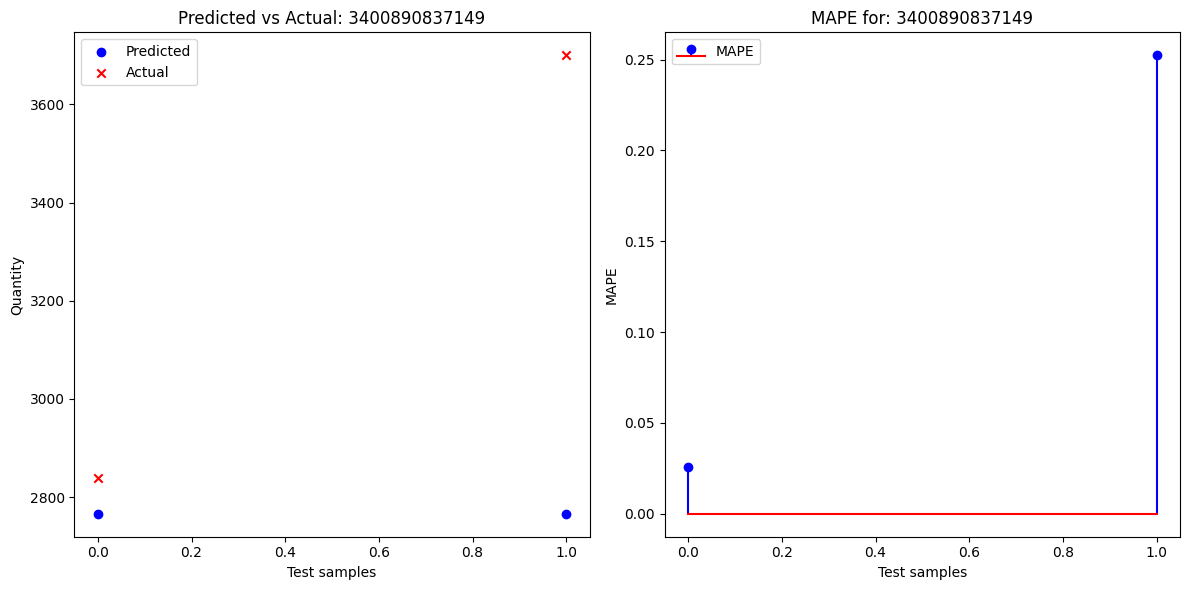

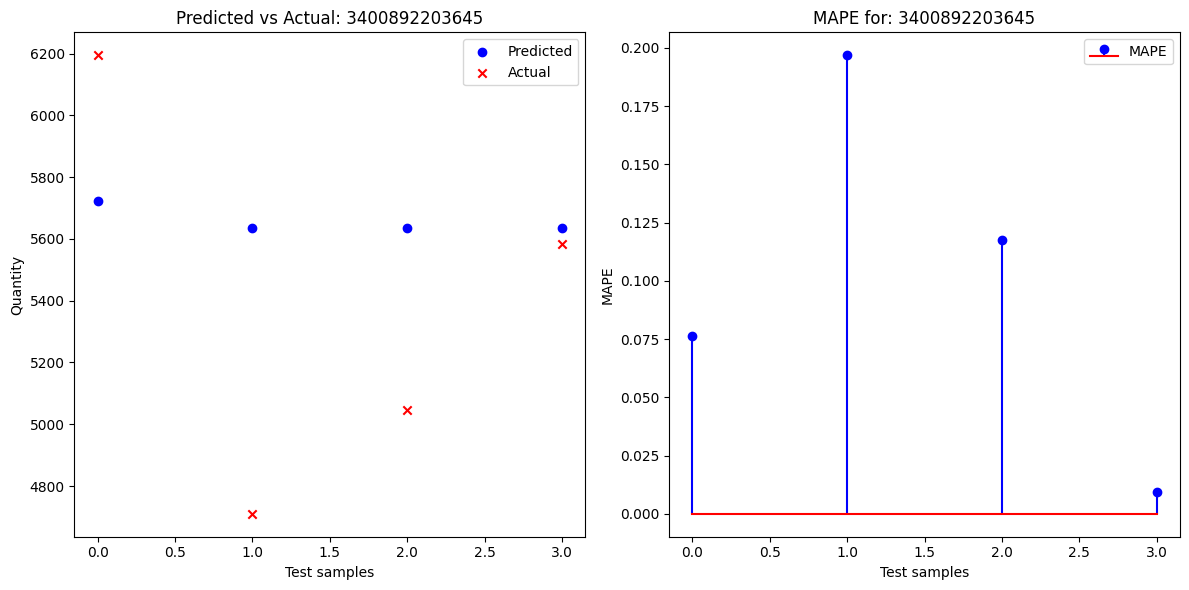

In [75]:
import pandas as pd

def filter_med_data(df_ma_6, med_code, hospi_code, start_date, end_date):
    return df_ma_6[
        (df_ma_6['HOSPI_CODE_UCD'] == med_code) &
        (df_ma_6['QUANTITY'] > 0) &
        (df_ma_6['ID_SITE_RATTACHE'] == hospi_code) &
        (df_ma_6['DATE'] >= start_date) &
        (df_ma_6['DATE'] <= end_date)
    ].copy()

def process_pair(df_ma_6, df_scores, med_a, med_b, hospi_a, hospi_b, start_date, end_date):
    df_med_a = filter_med_data(df_ma_6, med_a, hospi_a, start_date, end_date)
    df_med_b = filter_med_data(df_ma_6, med_b, hospi_b, start_date, end_date)
    df_meds = pd.concat([df_med_a, df_med_b], ignore_index=True)
    return test_pairs(df_meds, df_scores, med_a, med_b, hospi_a, hospi_b)

df_scores = pd.DataFrame(columns=[
    'PAIR', 'HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'
])

for i, row in df_comparisons.iterrows():
  df_scores_pair = pd.DataFrame(columns=['PAIR', 'HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'])

  med_a = row['med_a']
  med_b = row['med_b']
  hospi_a = row['hospi_a']
  hospi_b = row['hospi_b']

  processed_pair = process_pair(
      df_ma_6, df_scores_pair, med_a, med_b, hospi_a, hospi_b, start_date, end_date
  )

  df_scores = pd.concat([df_scores, processed_pair], ignore_index=True)

df_scores


In [56]:
'''import shutil

folder_to_download = "/content/drive/MyDrive/Colab_Figures"  # Replace with the actual folder path

shutil.make_archive("/content/drive/MyDrive/prediction_figures", "zip", folder_to_download)

from google.colab import files

zip_filename = "/content/drive/MyDrive/prediction_figures.zip"

files.download(zip_filename)'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [134]:
def train_test_split_modified(df, random_state = 42, test_size = 0.1, Shuffle = False):
  df_iter = df.copy()

  np.random.seed(random_state)

  X_train = []
  y_train = []

  X_test = []
  y_test = []

  columns = df.columns

  df_train = pd.DataFrame(columns=columns)
  df_test = pd.DataFrame(columns=columns)
  i = 0
  for medicine in df_iter.HOSPI_CODE_UCD.unique():
    df_temp = df_iter[df_iter['HOSPI_CODE_UCD'] == medicine]
    i += len(df_temp)
    n_samples = len(df_temp)


    if n_samples == 1:
      print('Not enough samples in cluster')
      test_samples = 1
    else:
      test_samples = max(m.ceil(n_samples * test_size), 2)


    for _ in range(test_samples):
      random_index = np.random.choice(df_temp.index)
      random_row = df_temp.loc[random_index].to_frame().T

      # Concatenate the new row to the original DataFrame
      df_test = pd.concat([df_test, random_row], ignore_index=False)

      # Remove the selected index from df_temp
      df_temp = df_temp.drop(random_index)

    df_iter = df_iter.drop(df_iter[df_iter['HOSPI_CODE_UCD'] == medicine].index)

  # Get the indices of rows to exclude from df
  exclude_indices = df_test.index

  # Create df_train by dropping the rows specified by the exclude_indices from df
  df_train = df.drop(exclude_indices)

  if shuffle:
    X_train, y_train = shuffle(df_train.drop(['QUANTITY'], axis=1), df_train.QUANTITY.values, random_state = random_state)
    X_test, y_test = shuffle(df_test.drop(['QUANTITY'], axis=1).values, df_test.QUANTITY.values, random_state = random_state)

  return X_train, X_test, y_train, y_test

In [147]:
# Specify the path where you want to save the figures
save_folder = '/content/drive/MyDrive/Clusters/'

# Create the folder if it doesn't exist
import os
os.makedirs(save_folder, exist_ok=True)

def test_pairs_cluster(df, df_scores, cluster, verbose = False, visu = False):
  if verbose:
    print()
    print(100*'-')
    print(f'Test cluster: {cluster}')
    print()
    print('Medicines in cluster: ')

    for medicine in df.HOSPI_CODE_UCD.unique():
      print(f'--- {medicine}')
    print()

  X_train, X_test, y_train, y_test = train_test_split_modified(df.drop(['DATE', 'QUANTITY_MA', 'RESID',
               'SEASONAL', 'TREND',
               'YEAR_2013', 'YEAR_2014',
               'YEAR_2015', 'YEAR_2016'], axis=1))
  print(f'Size of data set: {len(X_train) + len(X_test)}')

  if verbose:
    print(f'Size of data set: {len(X_train) + len(X_test)}')
    print(f'Size of training set: {len(X_train)}')
    print(f'Size of test set: {len(X_test)}')

  df_test = pd.DataFrame(X_test, columns = df.drop(['DATE','QUANTITY', 'QUANTITY_MA', 'RESID',
               'SEASONAL', 'TREND',
               'YEAR_2013', 'YEAR_2014',
               'YEAR_2015', 'YEAR_2016'], axis=1).copy().columns)
  df_test['QUANTITY'] = y_test



  # Define the parameter distributions for RandomizedSearchCV
  param_grid = {
      'max_depth': np.arange(2, 8, 1),
      'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
      'max_features': ['sqrt']
  }

  depth_len = param_grid['max_depth'].size
  estimators_len = param_grid['n_estimators'].size

  if verbose:
    print(f'Size of grid search: {depth_len * estimators_len}')

  # Create the RandomizedSearchCV object
  grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                            param_grid=param_grid,
                            scoring = 'neg_mean_absolute_percentage_error',
                            cv = 5,
                            n_jobs = -1)

  ''' >3 : the fold and candidate parameter indexes
      are also displayed together with the starting time of the computation.
  '''

  # Fit the RandomizedSearchCV object to the data
  grid_search.fit(X_train.drop(['ID_SITE_RATTACHE'], axis = 1).values, y_train)
  if verbose:
    print("Finished training")

  # Get the best estimator
  best_estimator = grid_search.best_estimator_
  i = 0
  for medicine in df_test.HOSPI_CODE_UCD.unique():
    if verbose:
      print('Medicine:' + str(medicine))
      print('Hospital:' + str(df_test[df_test['HOSPI_CODE']]))

    X_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY', 'ID_SITE_RATTACHE'], axis=1).copy().values
    y_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].copy().values

    # Make predictions using the best estimator
    y_pred = best_estimator.predict(X_test_medicine)

    # Calculate R^2 score
    r2 = r2_score(y_test_medicine, y_pred)

    # Calculate MAE
    mae = mean_absolute_error(y_test_medicine, y_pred)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test_medicine, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_medicine, y_pred))

    if verbose:
      # Print the best parameters, best score, and evaluation metrics
      print('Best Parameters: ', grid_search.best_params_)
      print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
      print()
      print(35*'-' + 'Test scores' + 35*'-')
      print('R^2 Score:', round(r2, 3))
      print('MAE:', round(mae, 3))
      print('MAPE:', round(mape, 3))
      print('RMSE:', round(rmse, 3))
      print()

    # Create the new row as a DataFrame
    new_row = pd.DataFrame({'CLUSTER': [cluster],
                            'HOSPI_CODE_UCD': ['CODE_UCD_'+str(int(medicine))],
                            'R2': [round(r2, 3)],
                            'RMSE': [round(rmse, 3)],
                            'MAE': [round(mae, 3)],
                            'MAPE': [round(mape, 3)]})

    # Append the new row to the DataFrame
    df_scores = pd.concat([df_scores, new_row], ignore_index=True)

    # Save the figure
    fig_path = os.path.join(save_folder, f'med_{medicine}_cluster_{cluster}.png')

    plot_pred(y_pred, y_test_medicine, medicine, fig_path)
    print()

    i += 1
  plt.close()
  return df_scores



----------------------------------------------------------------------------------------------------
Test cluster: 0

Medicines in cluster: 
--- 3400891191226
--- 3400892745848
--- 3400892065366
--- 3400892508566
--- 3400892669236
--- 3400892697789
--- 3400892729589
--- 3400893826706

Size of data set: 272
Size of data set: 272
Size of training set: 242
Size of test set: 30
Size of grid search: 138
Finished training
Medicine:3400892729589
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 24}
Training Score (MAPE):  -0.316

-----------------------------------Test scores-----------------------------------
R^2 Score: -165.744
MAE: 4741.09
MAPE: 0.301
RMSE: 4842.351


Medicine:3400892745848
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 24}
Training Score (MAPE):  -0.316

-----------------------------------Test scores-----------------------------------
R^2 Score: 0.738
MAE: 1315.802
MAPE: 0.135
RMSE: 1591.795


Medicine:3400892669236
Be

<ipython-input-74-c887a1139df8>:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.




Medicine:3400893826706
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 15}
Training Score (MAPE):  -0.121

-----------------------------------Test scores-----------------------------------
R^2 Score: -6.295
MAE: 823.254
MAPE: 0.283
RMSE: 876.425



----------------------------------------------------------------------------------------------------
Test cluster: 4

Medicines in cluster: 
--- 3400890837149
--- 3400892203645
--- 3400891191226
--- 3400891235203
--- 3400892088310
--- 3400892508566
--- 3400892761527
--- 3400893736135
--- 3400893826706

Size of data set: 374
Size of data set: 374
Size of training set: 333
Size of test set: 41
Size of grid search: 192
Finished training
Medicine:3400891191226
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 32}
Training Score (MAPE):  -0.122

-----------------------------------Test scores-----------------------------------
R^2 Score: -0.03
MAE: 501.635
MAPE: 0.085
RMSE: 502.297


Medicine:34

KeyboardInterrupt: ignored

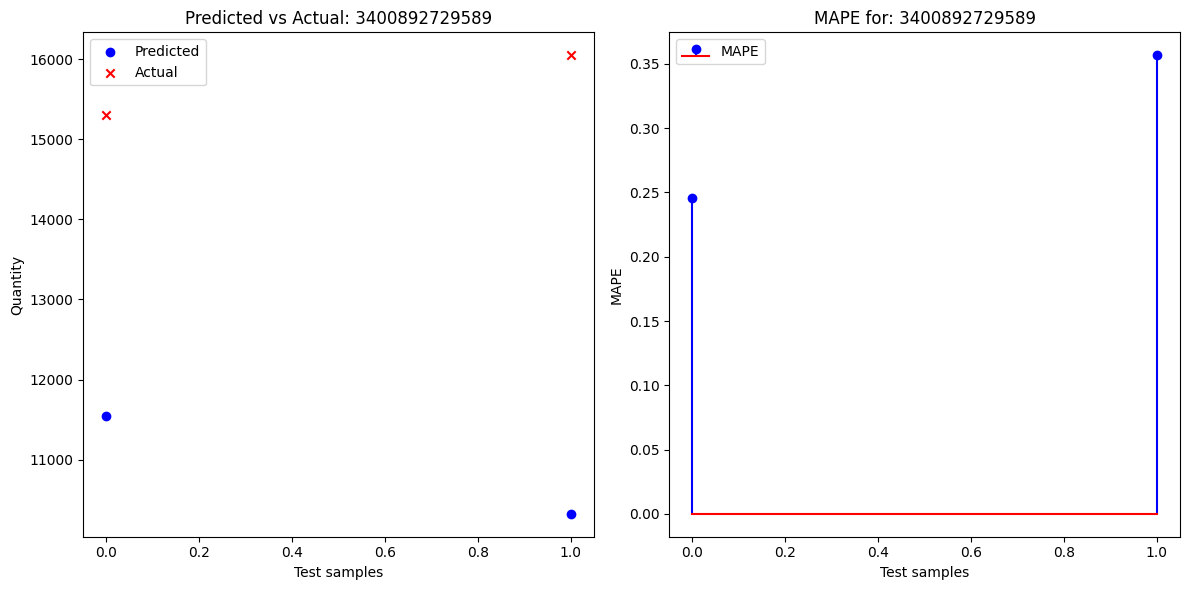

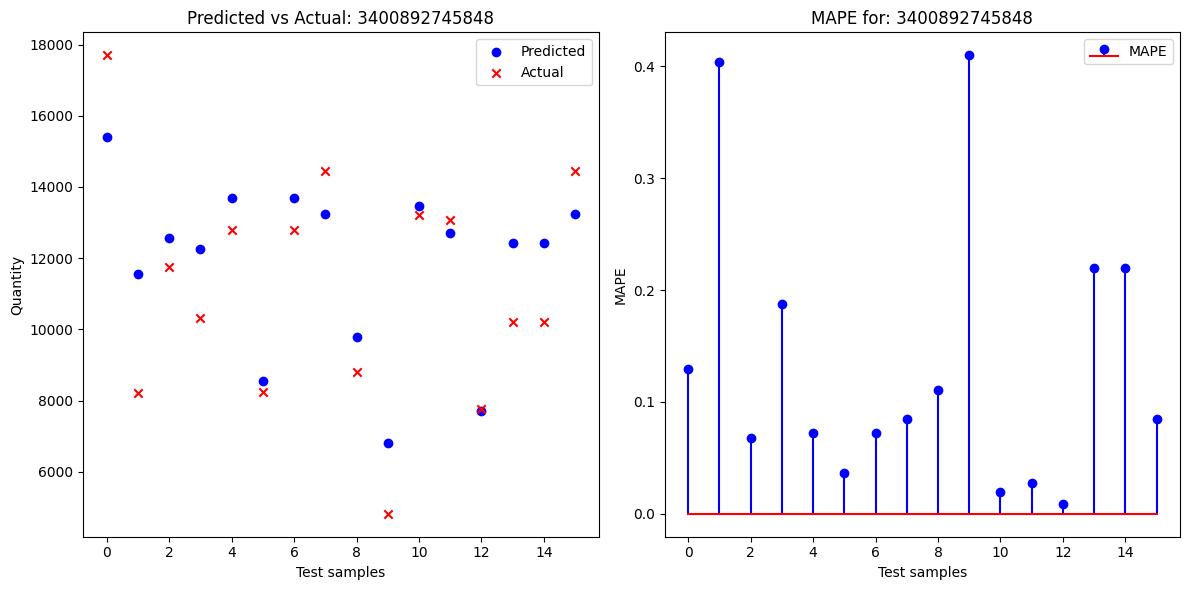

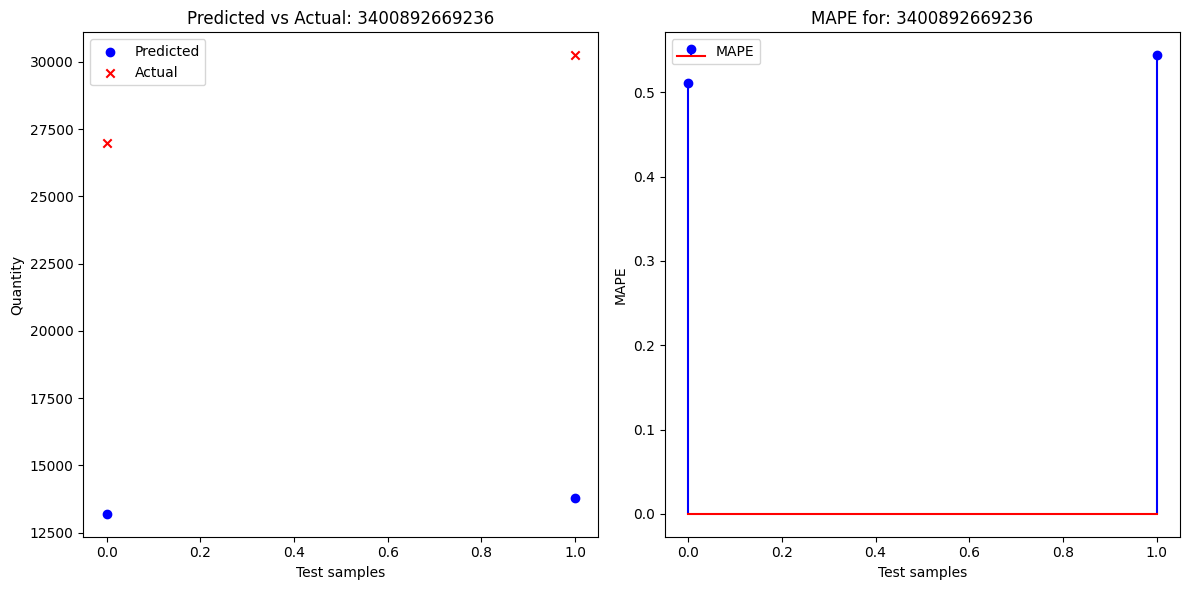

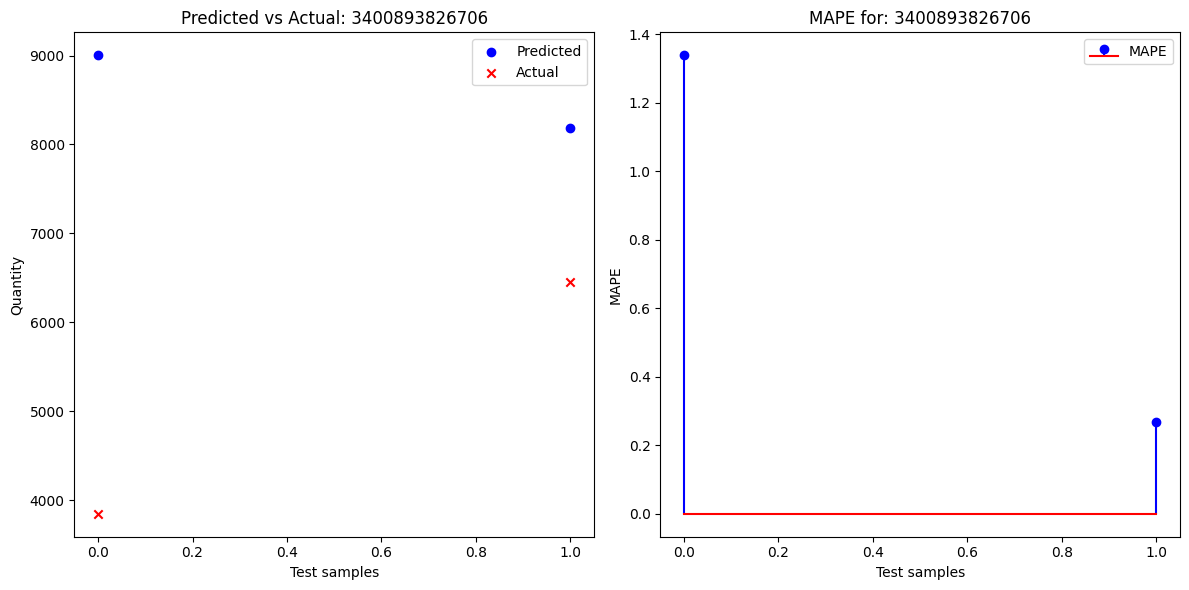

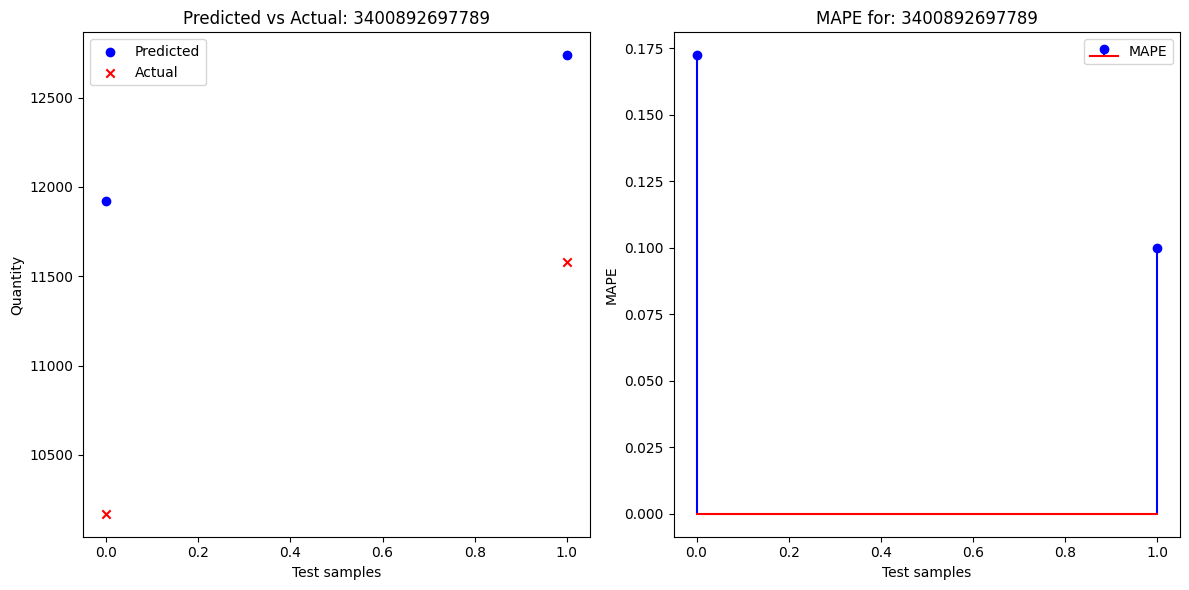

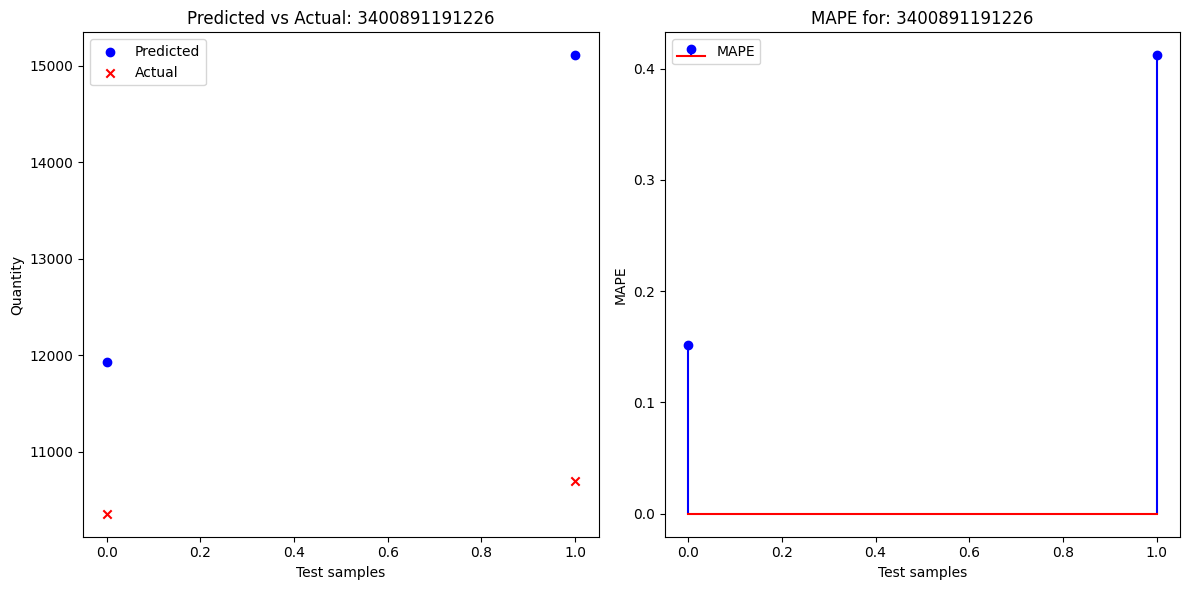

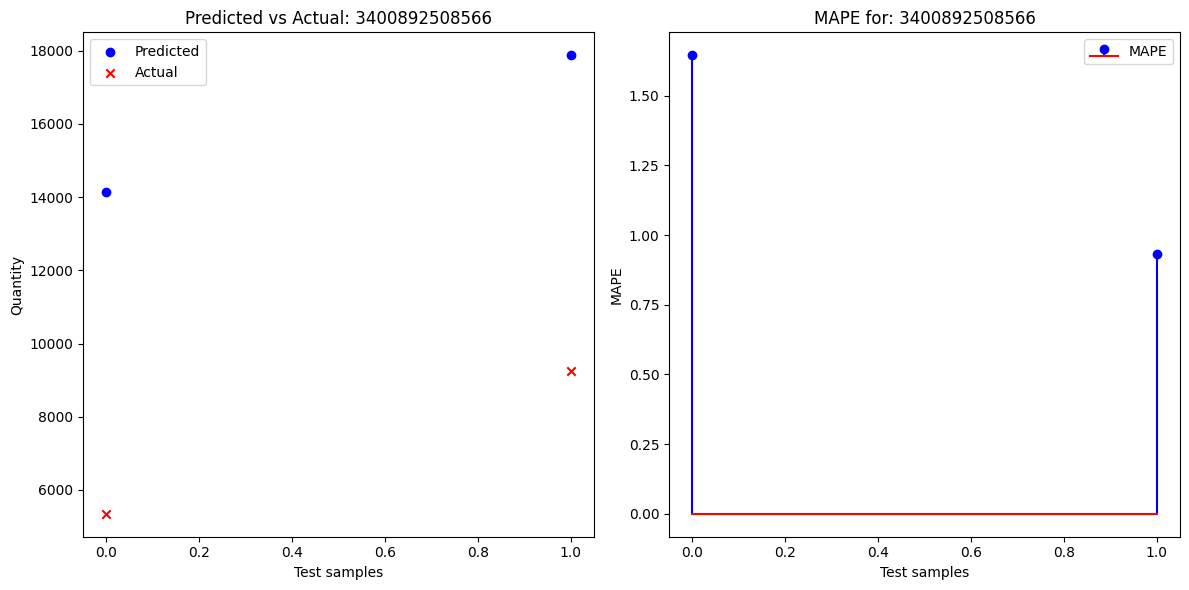

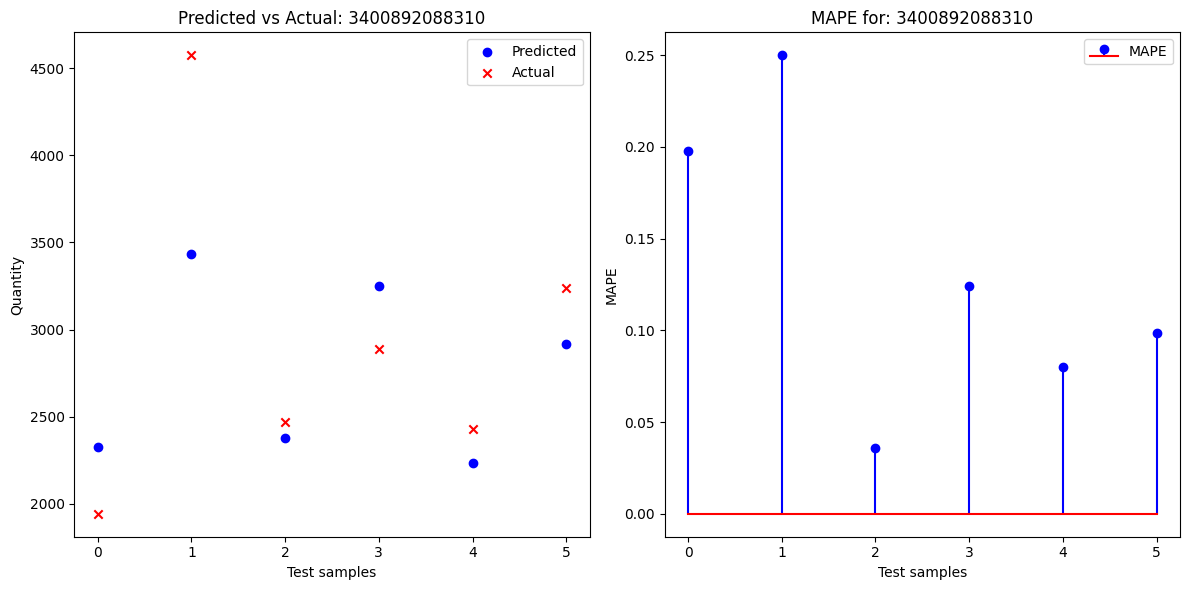

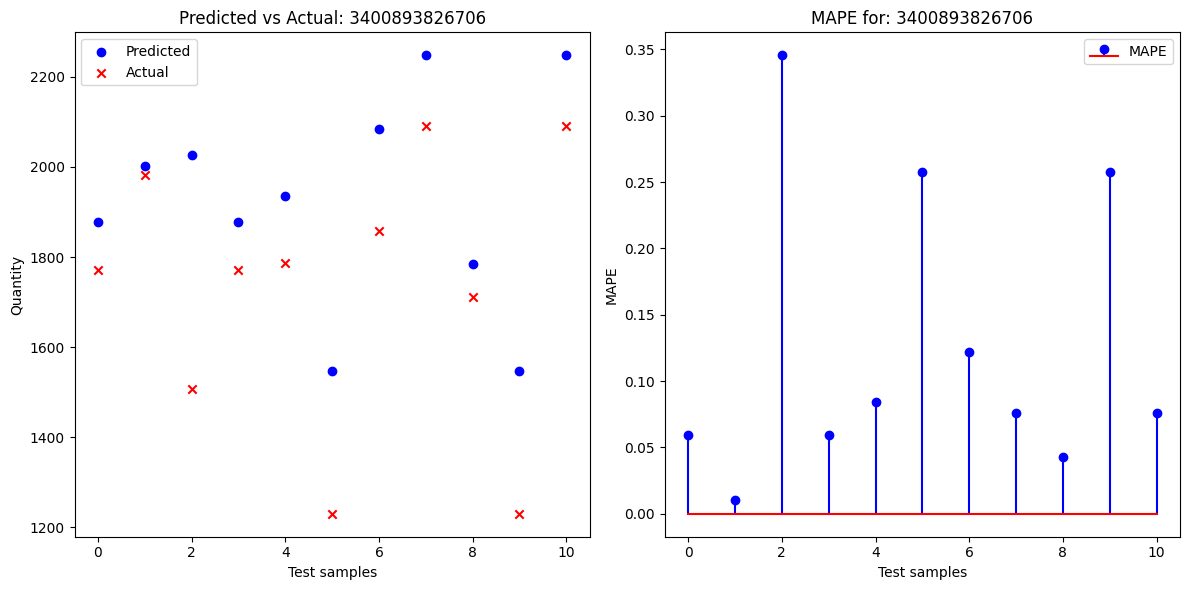

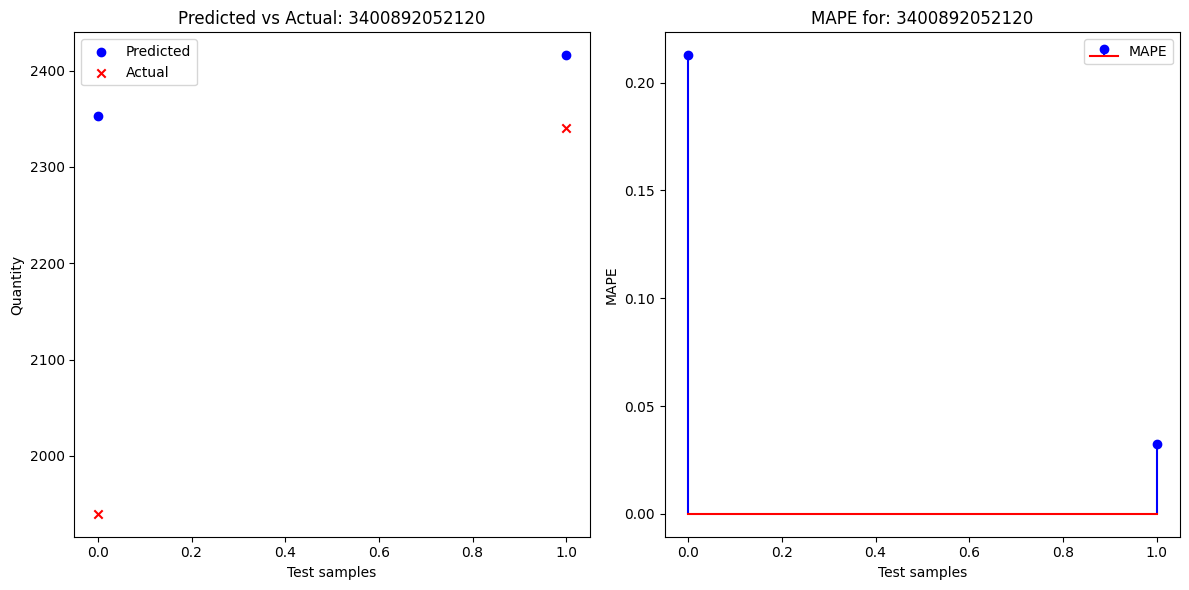

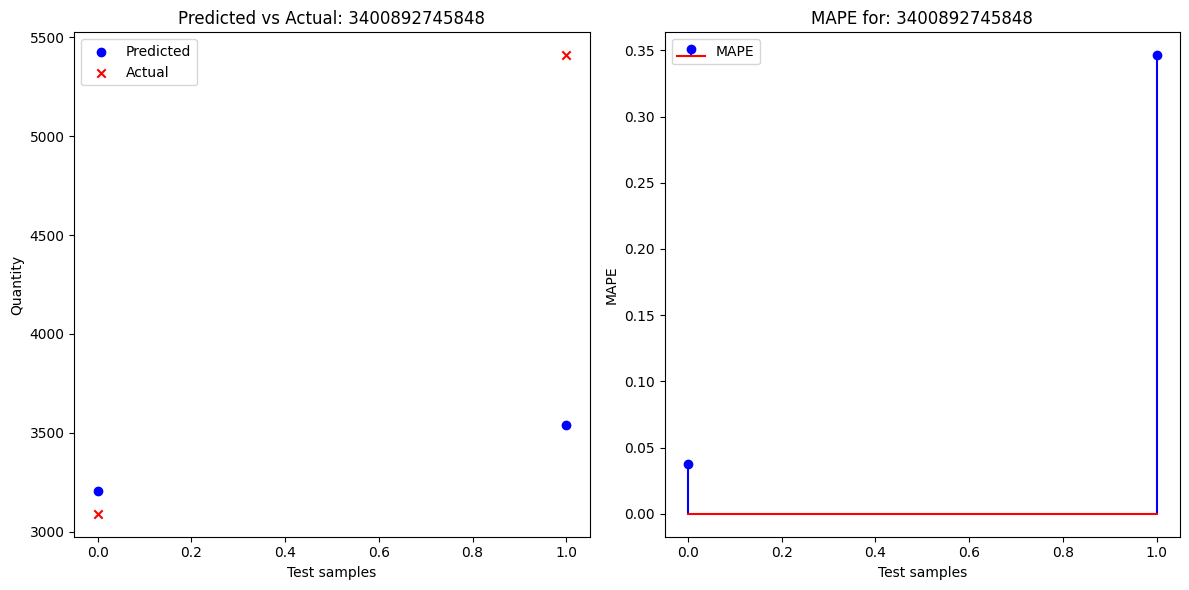

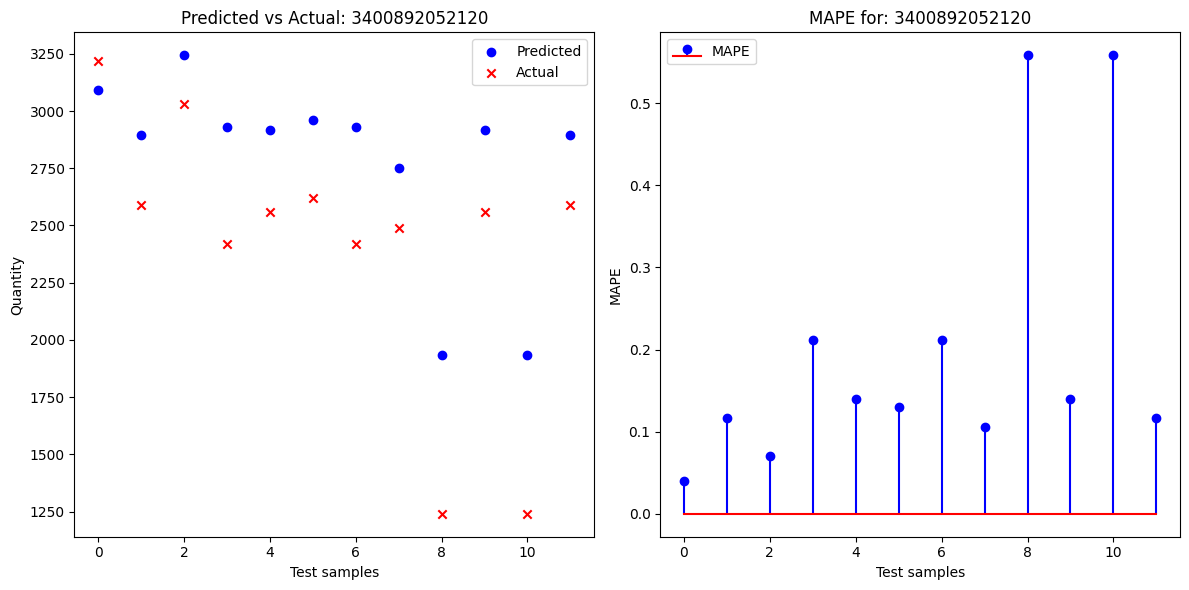

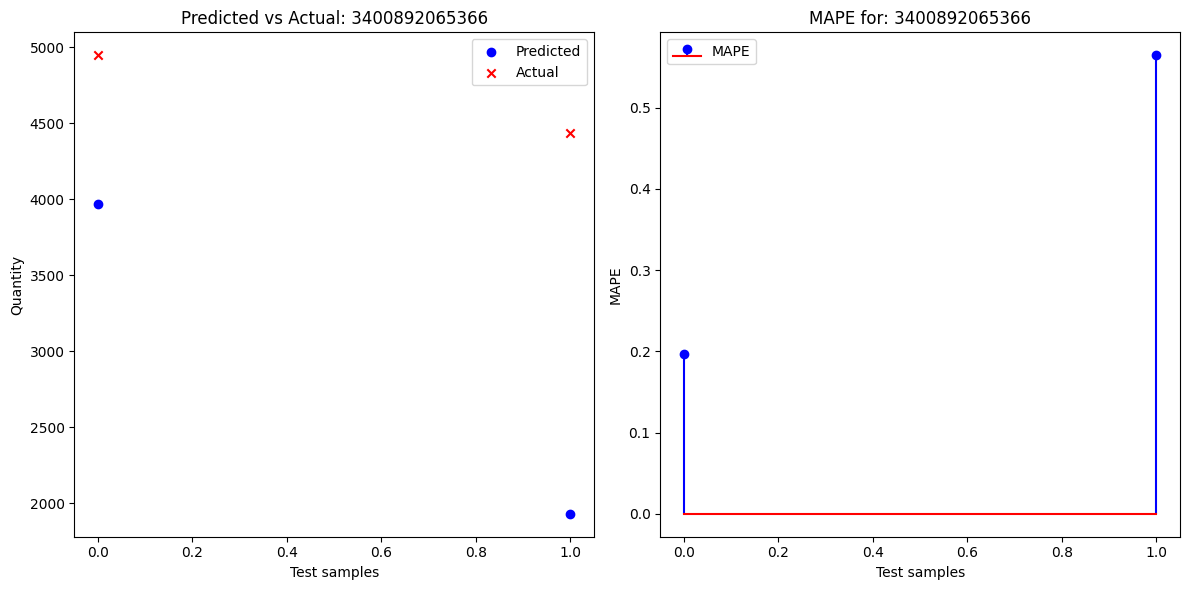

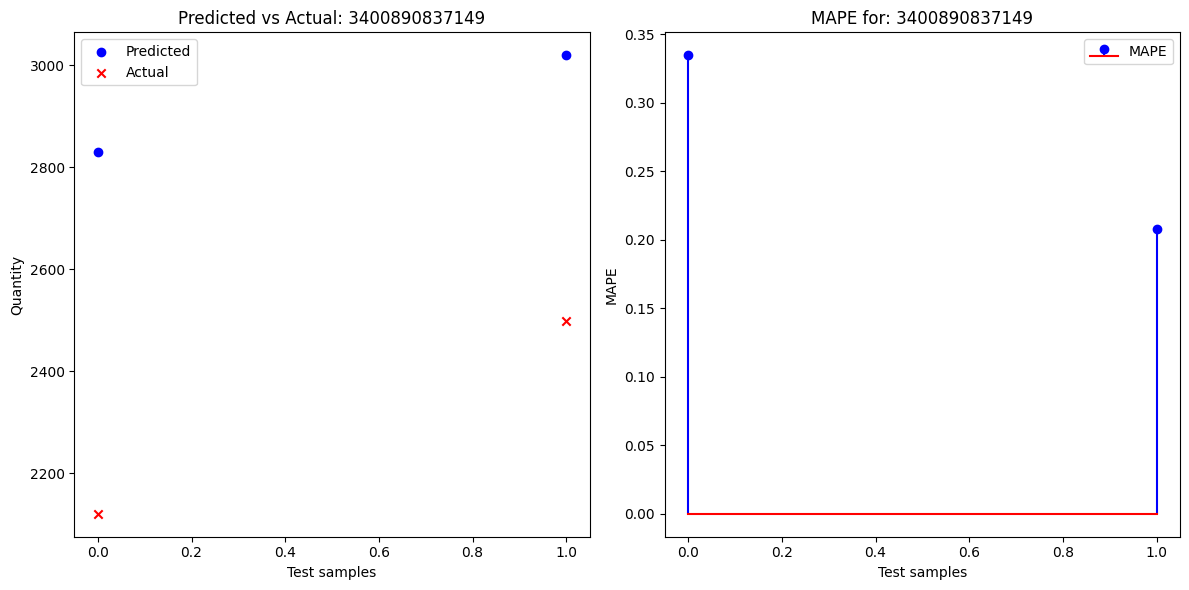

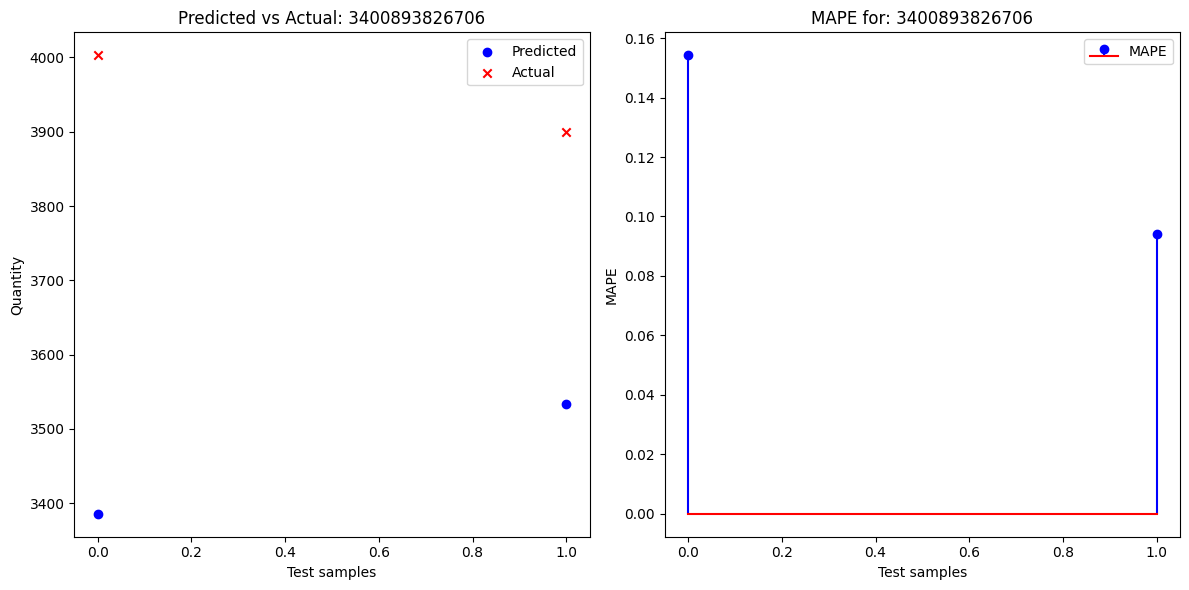

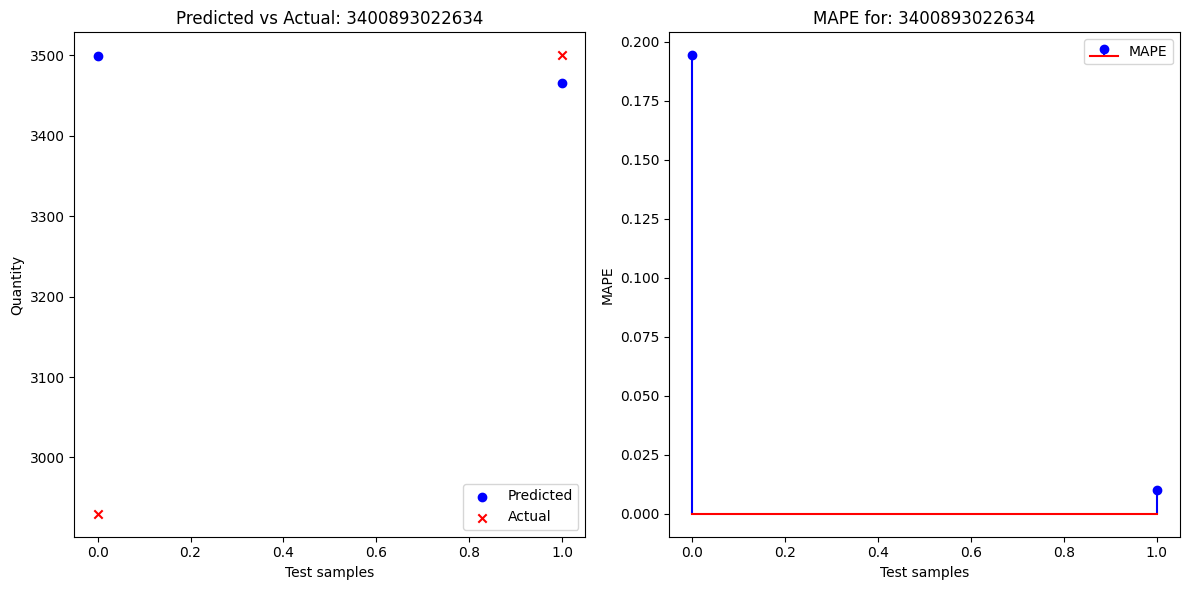

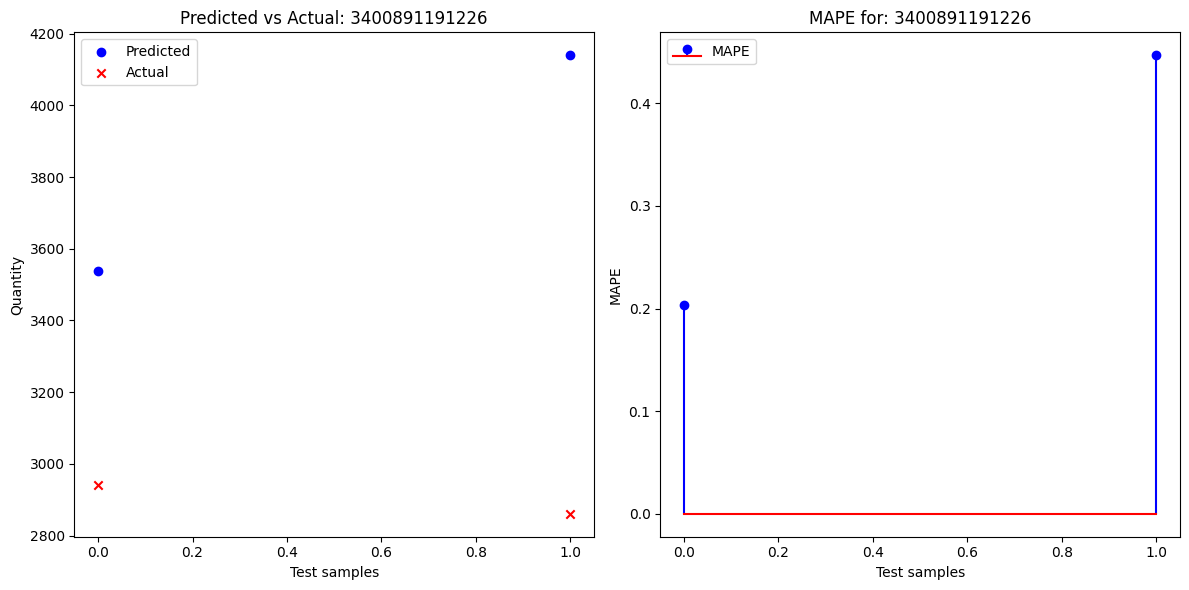

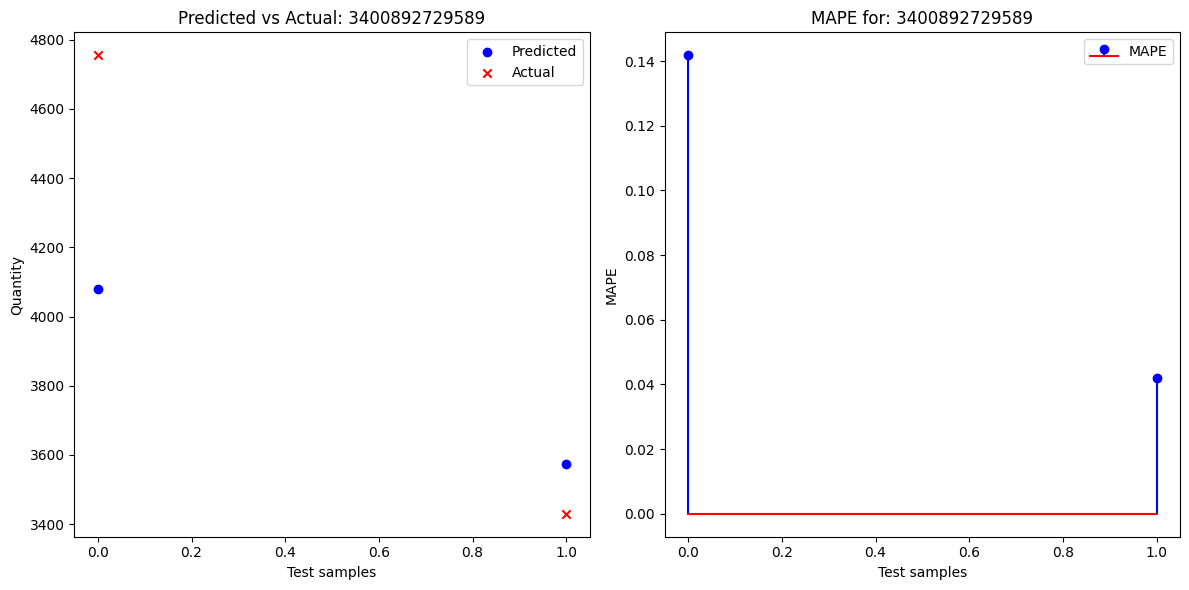

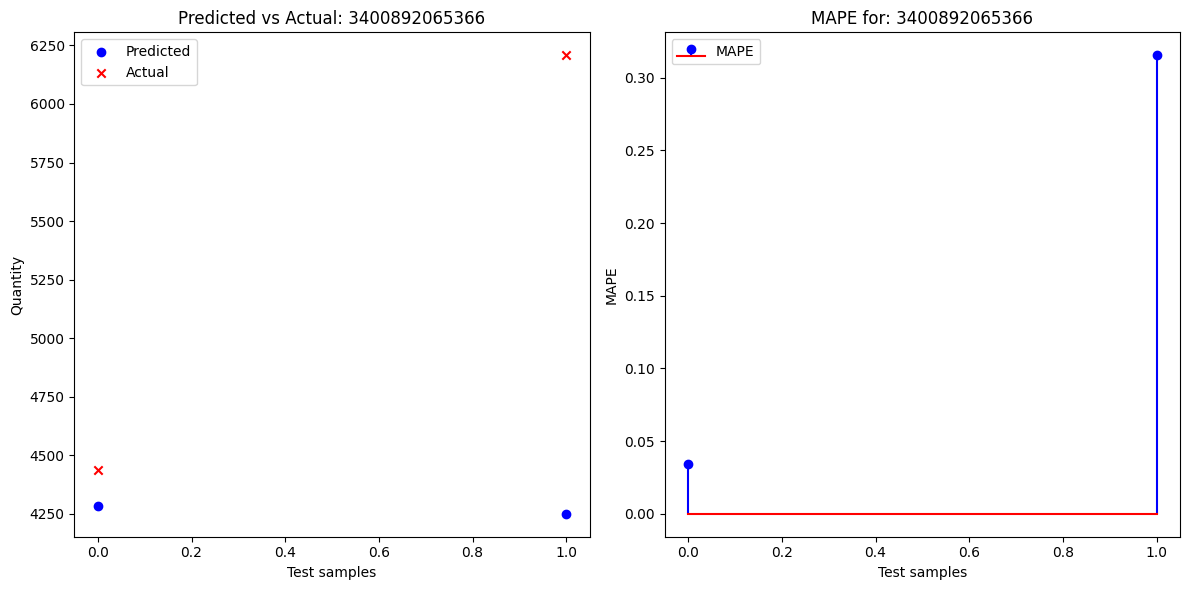

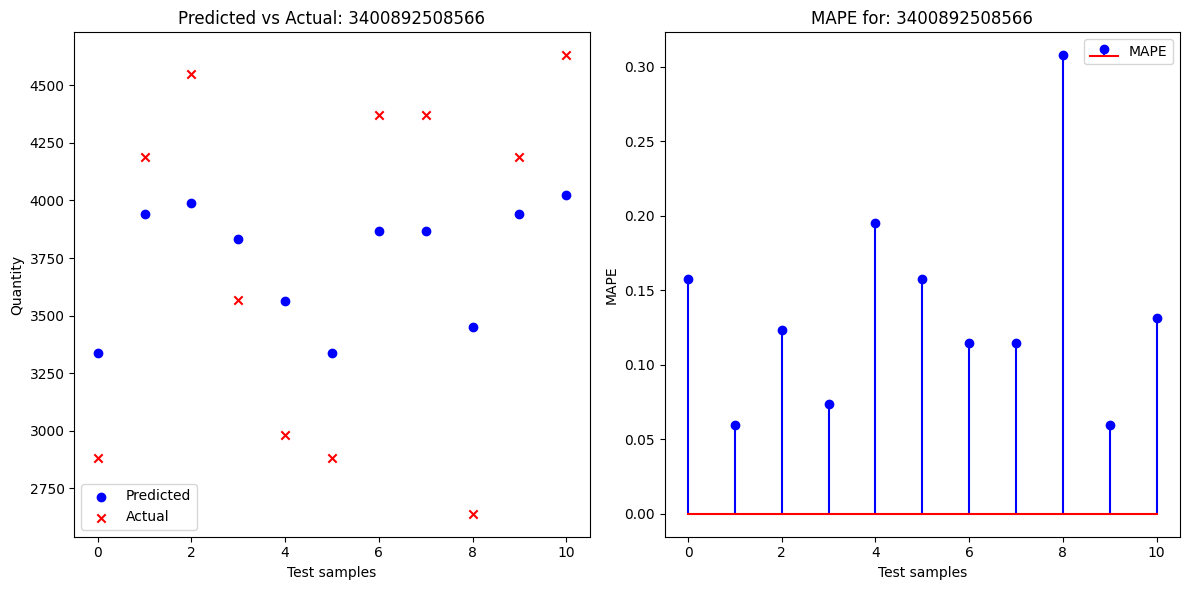

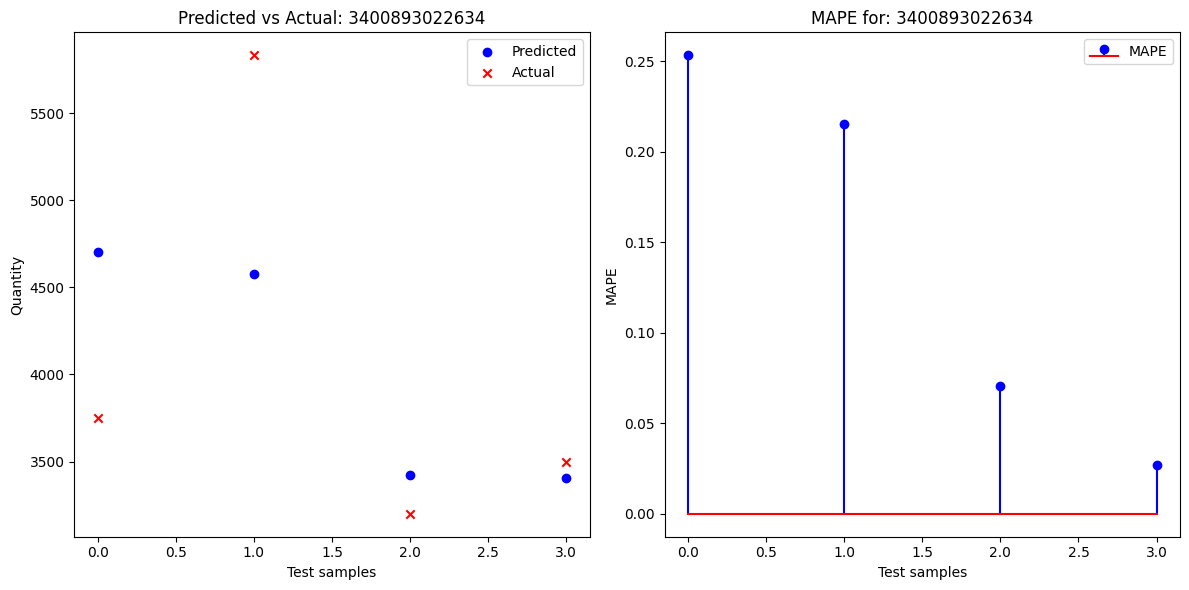

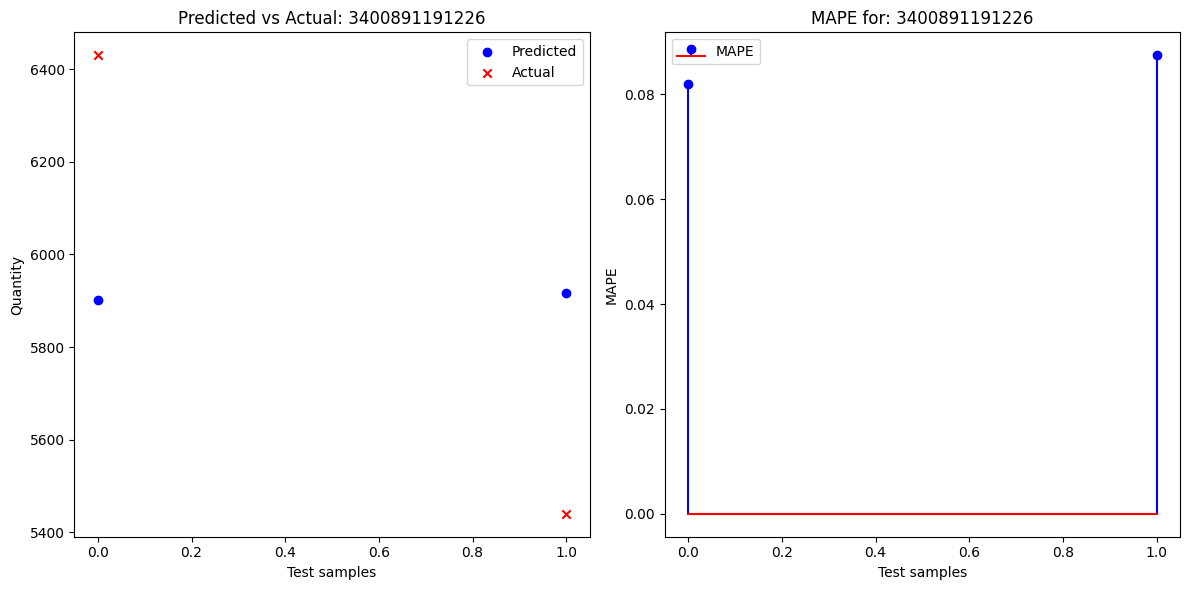

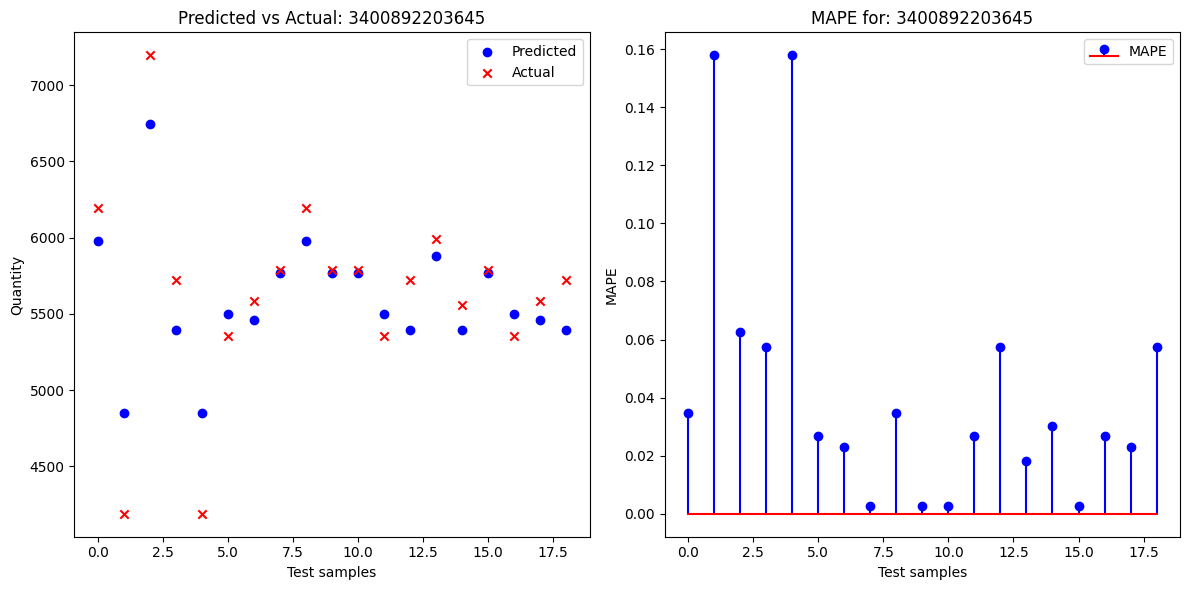

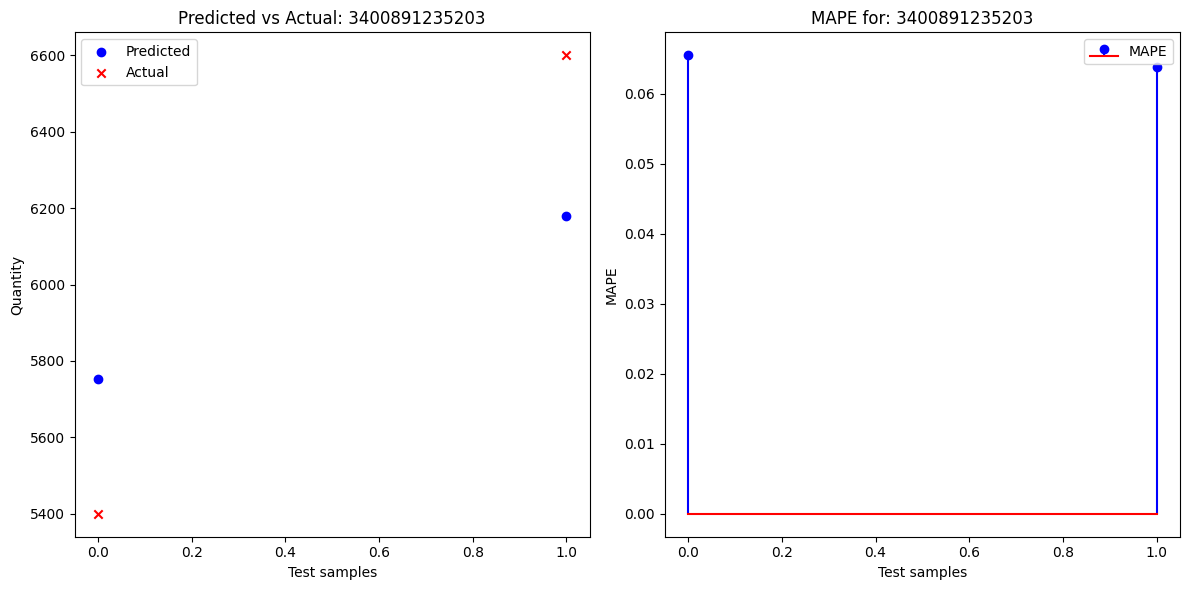

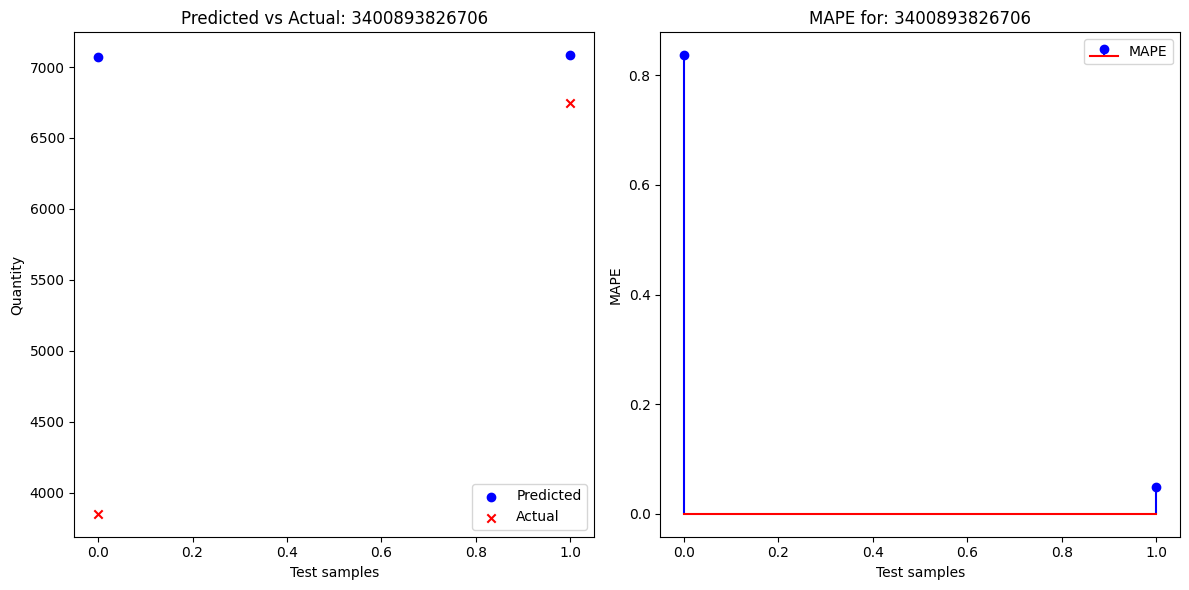

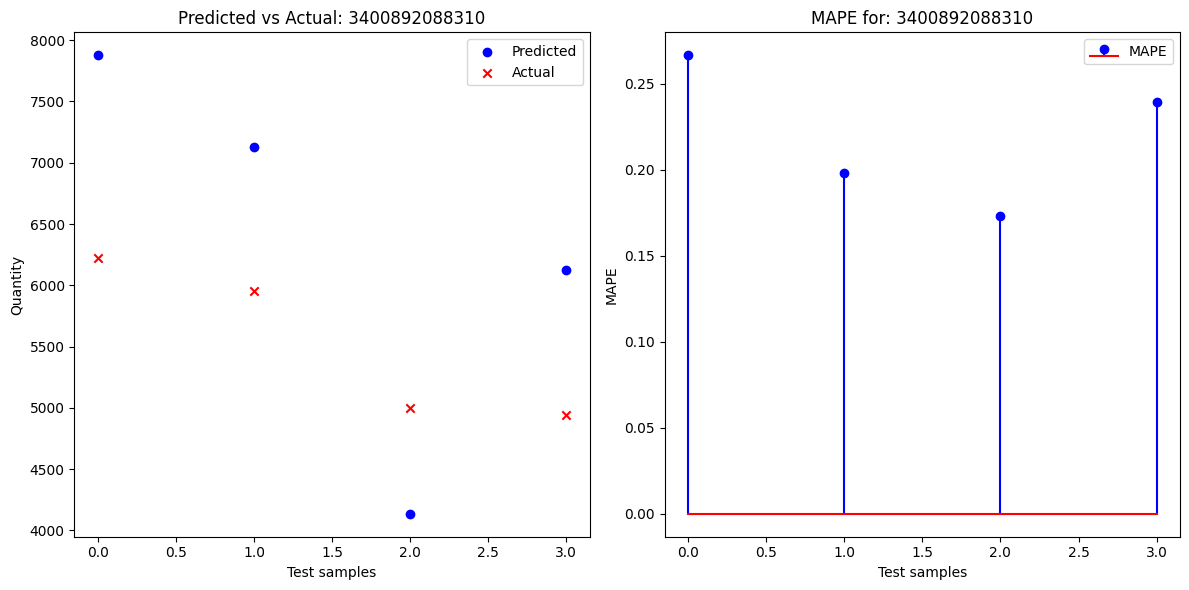

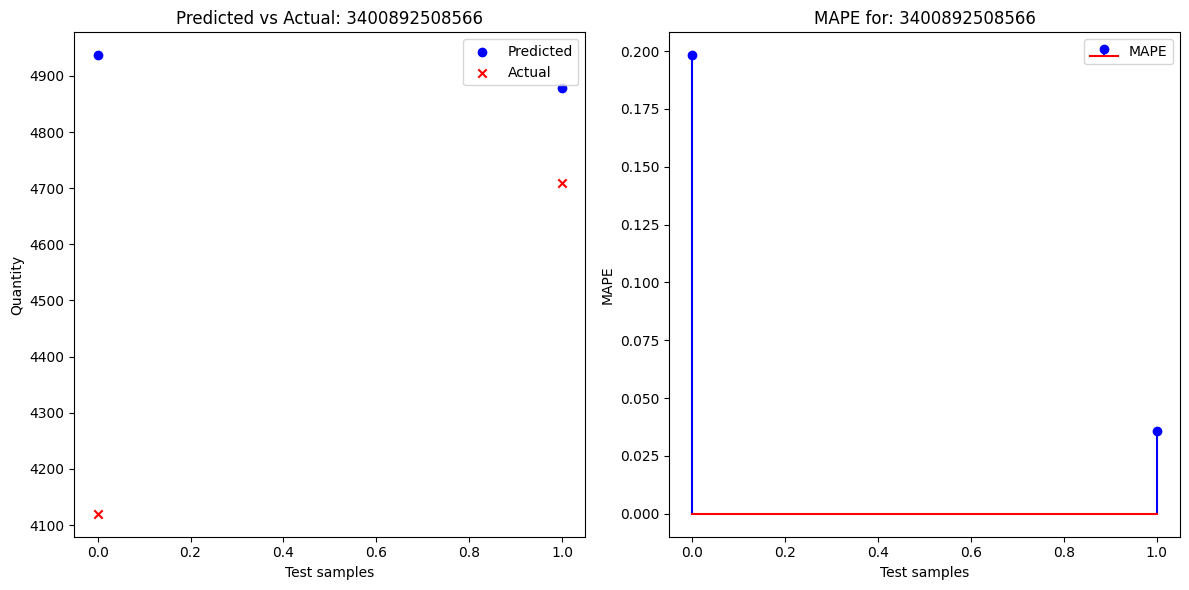

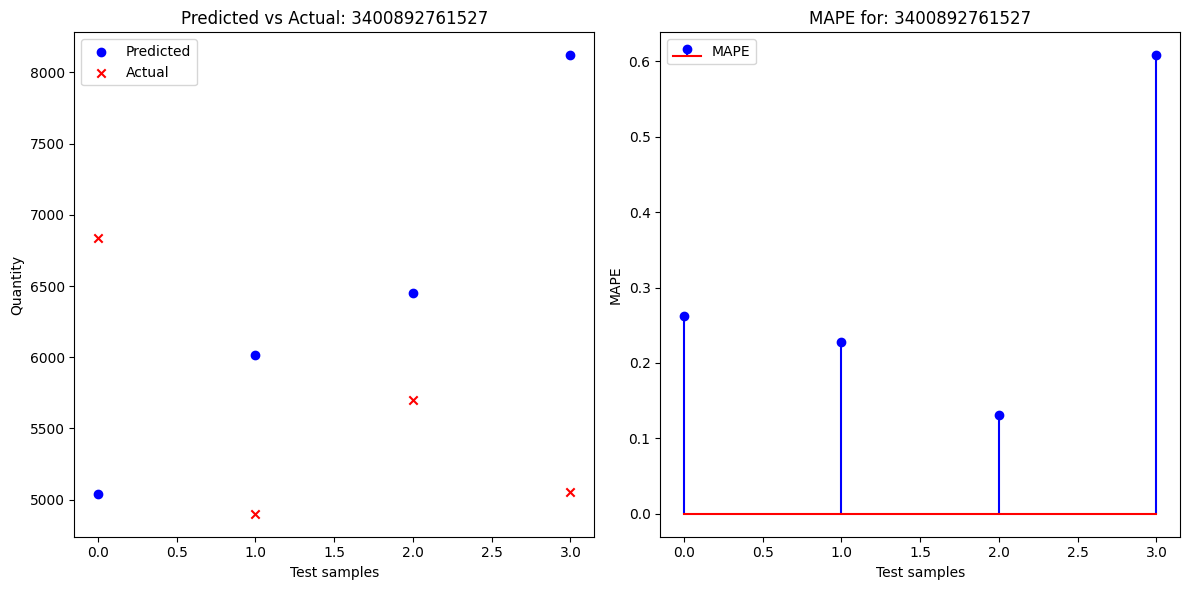

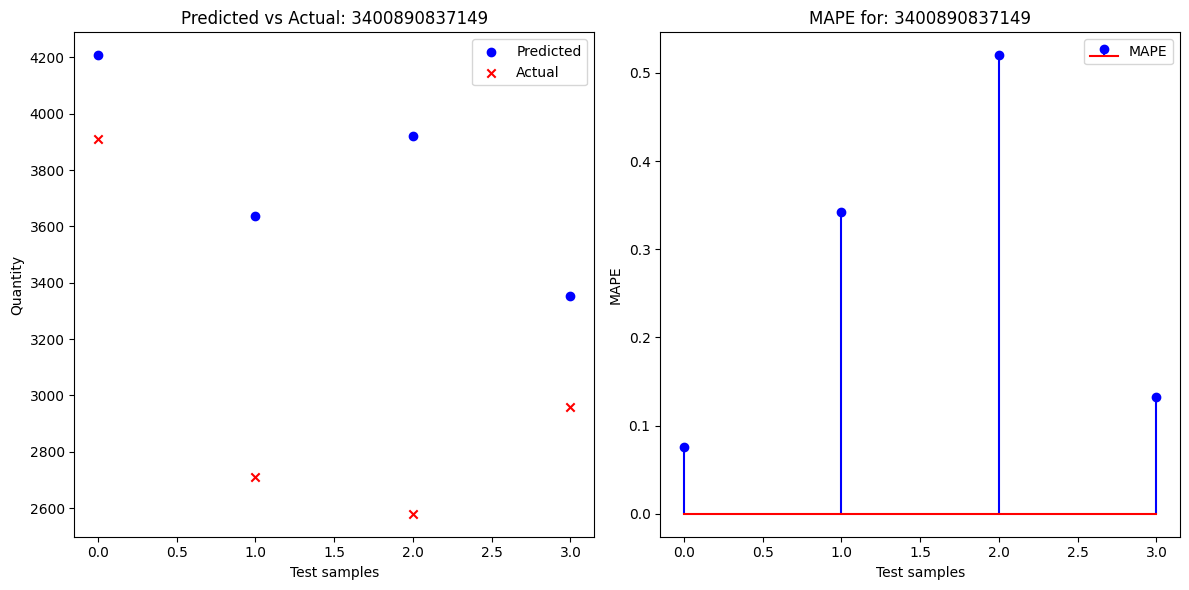

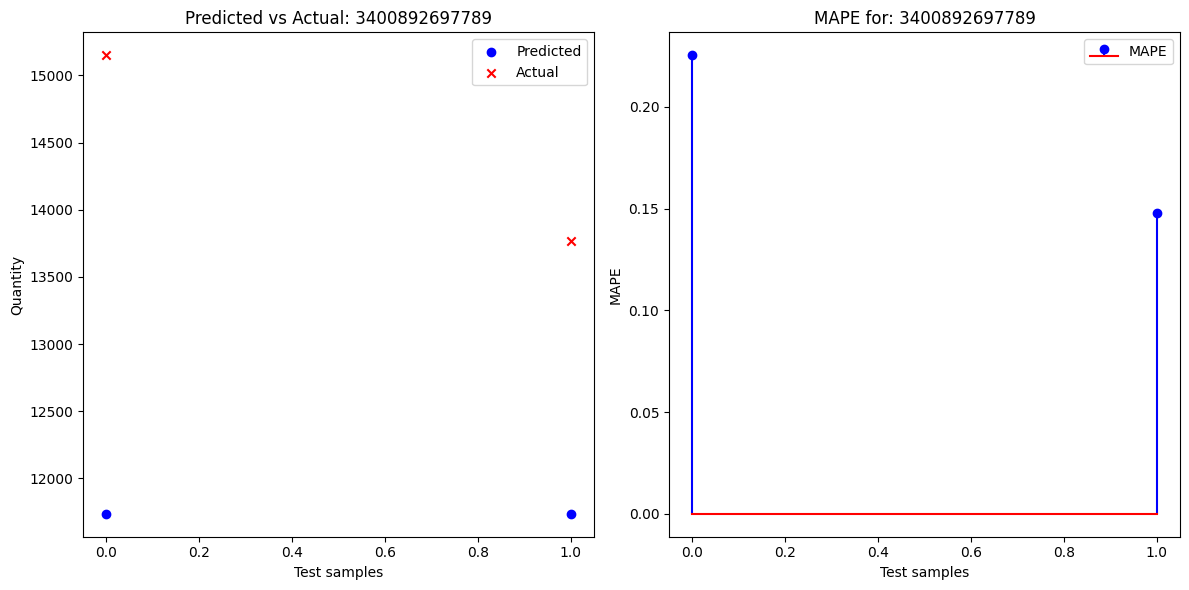

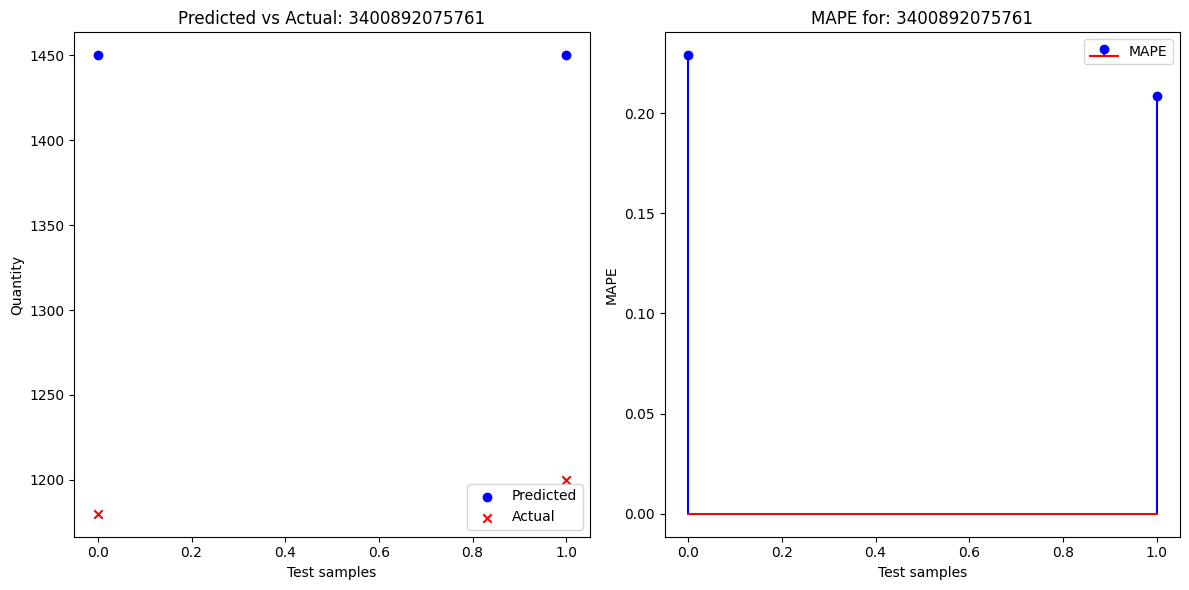

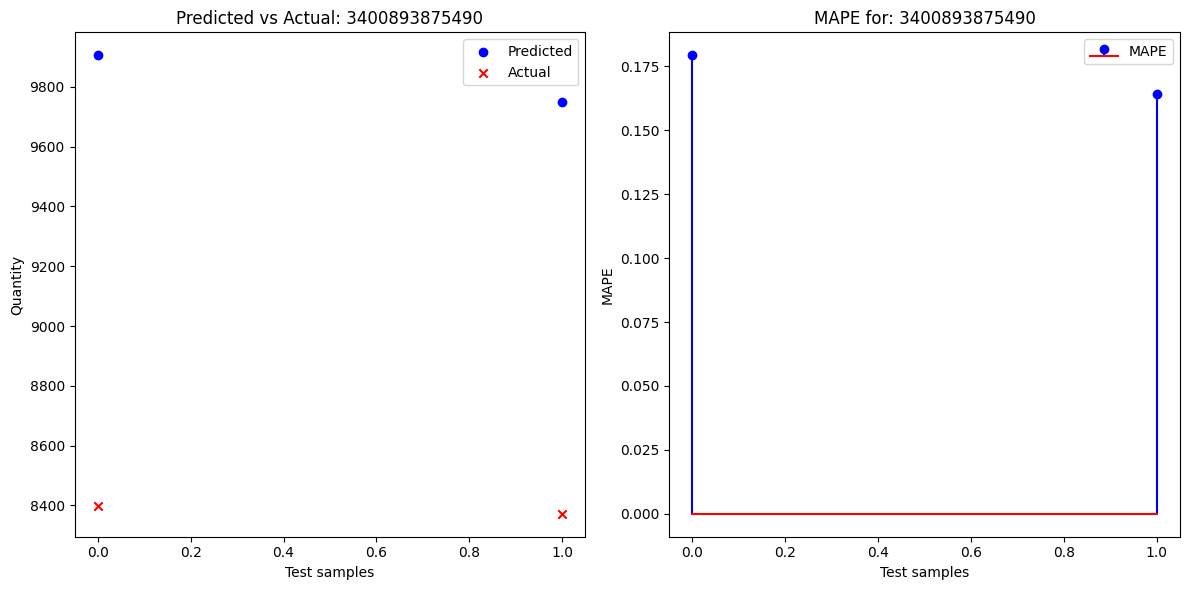

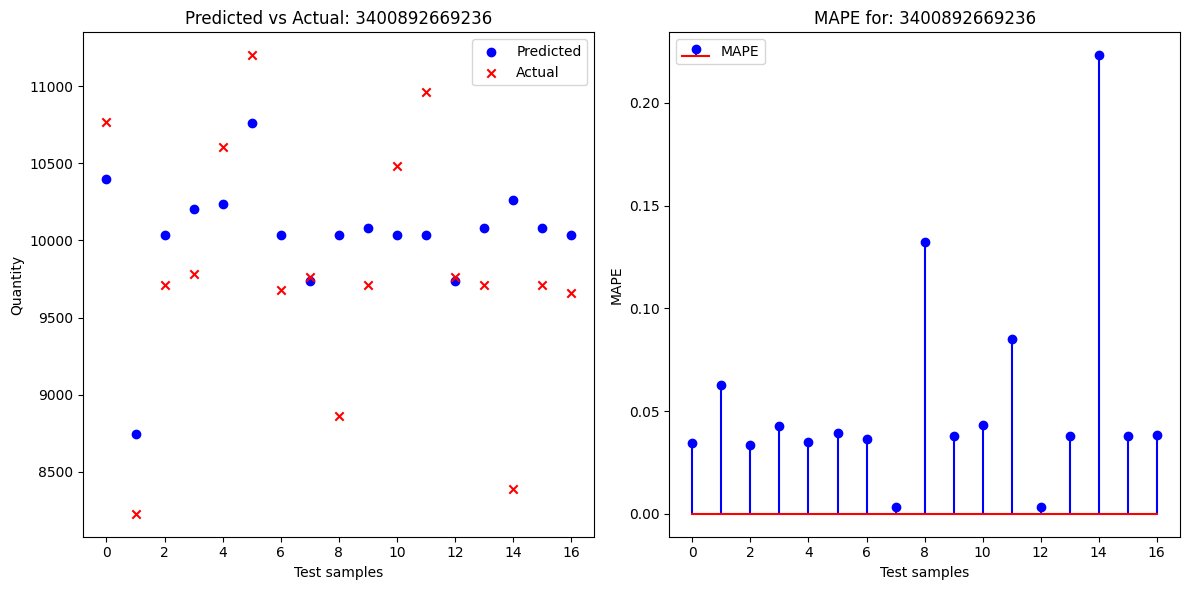

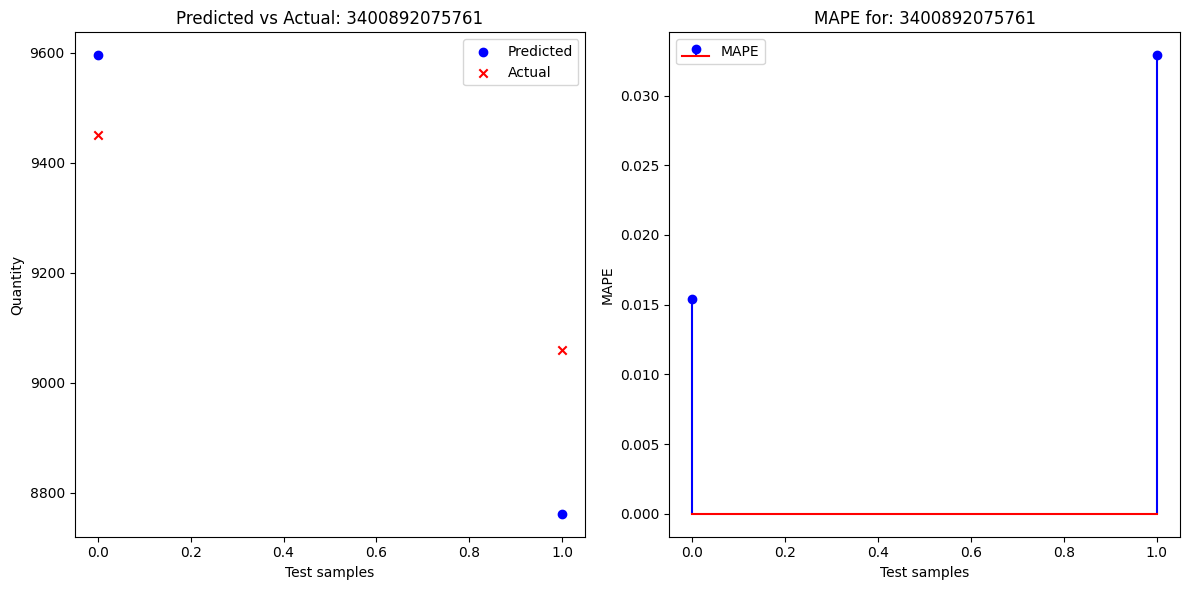

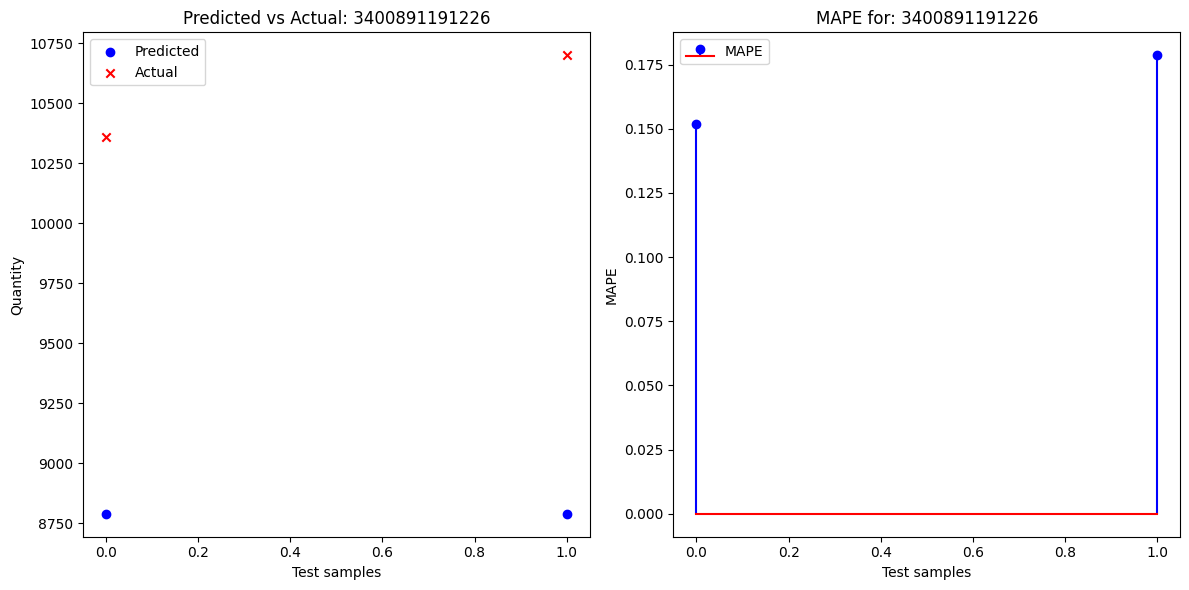

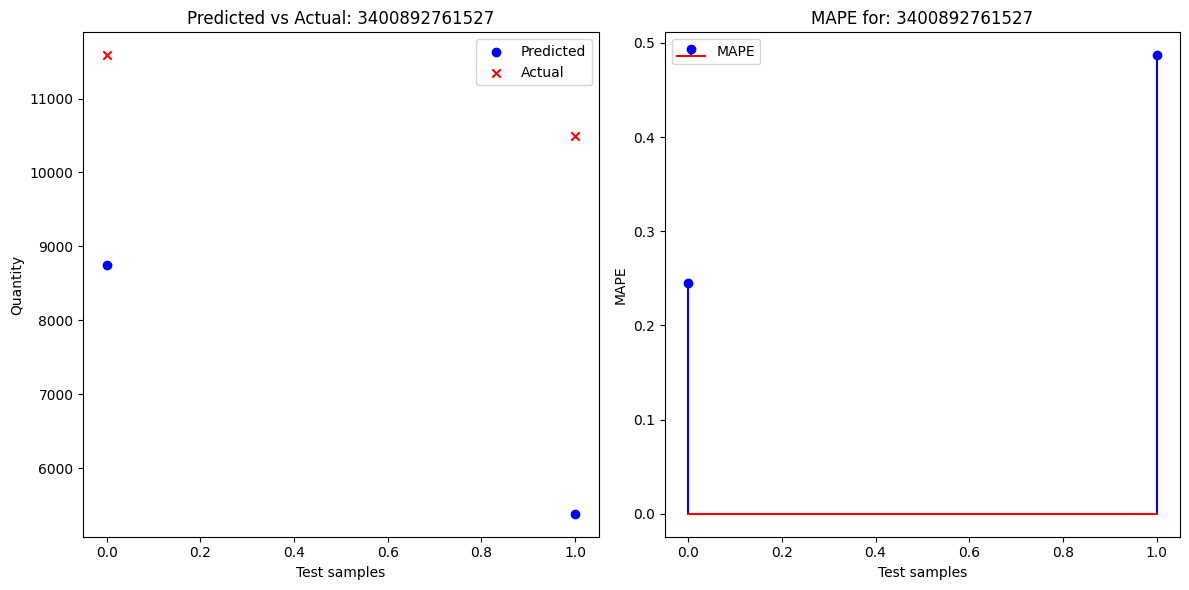

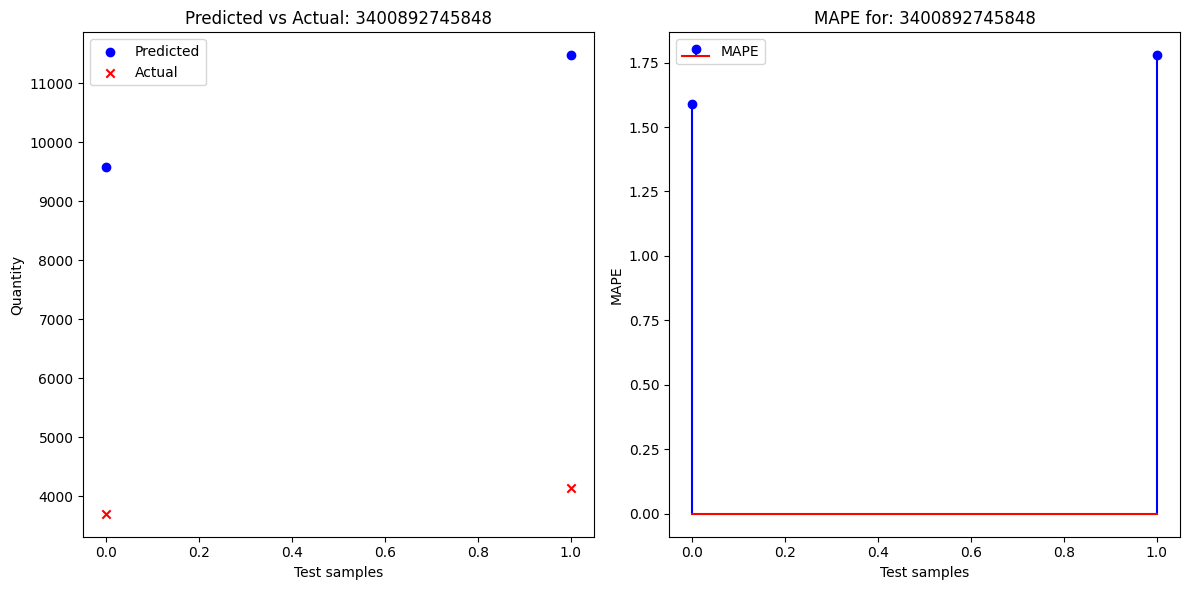

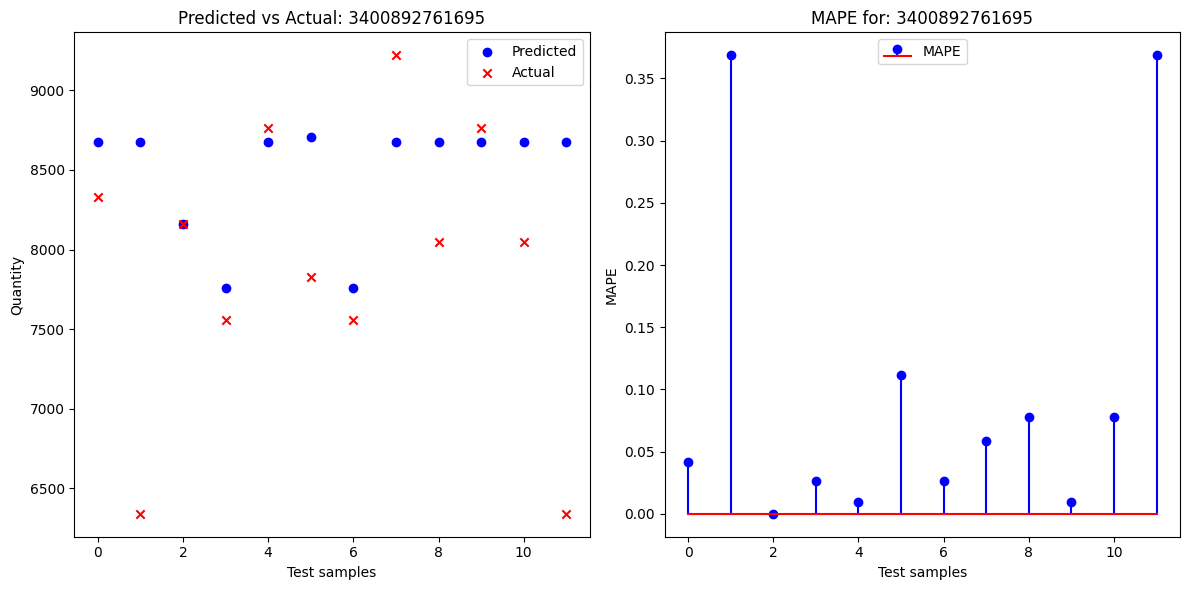

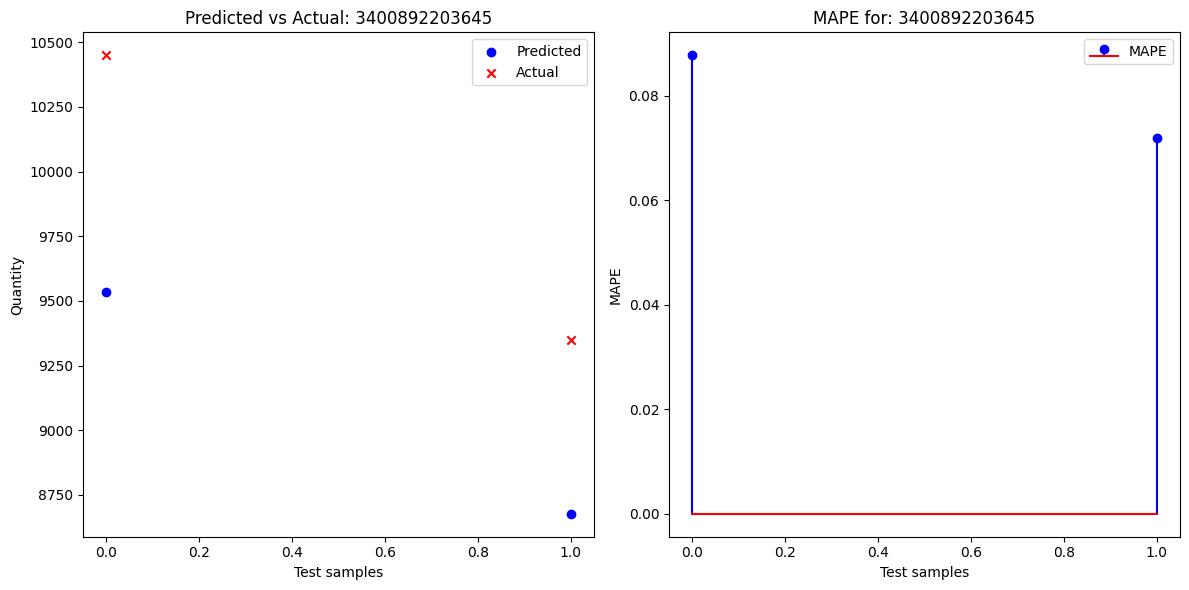

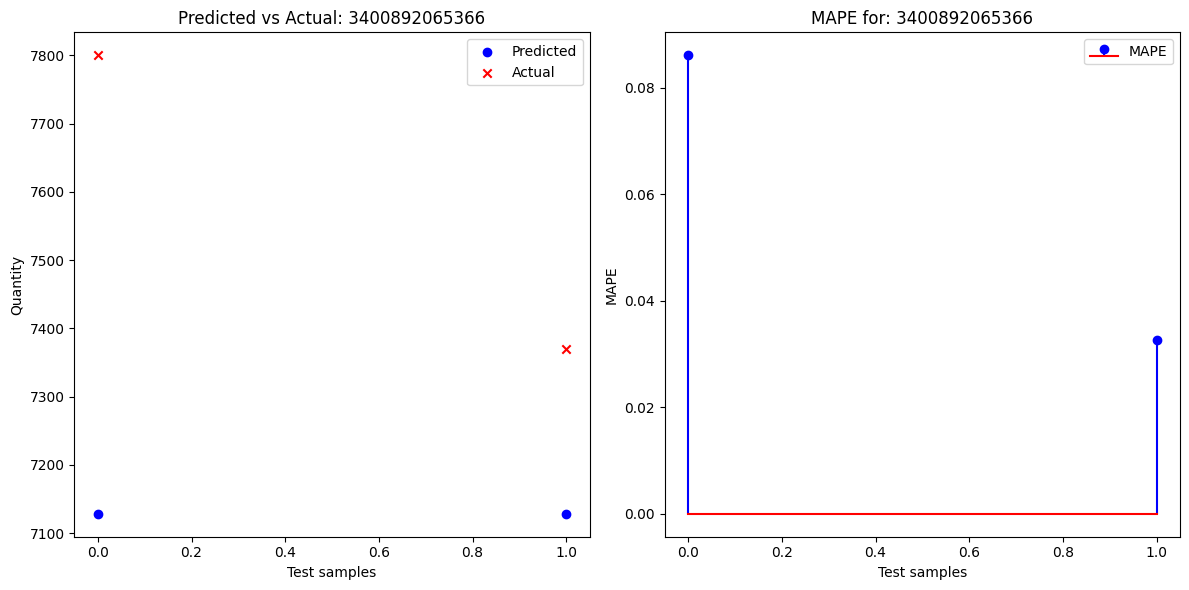

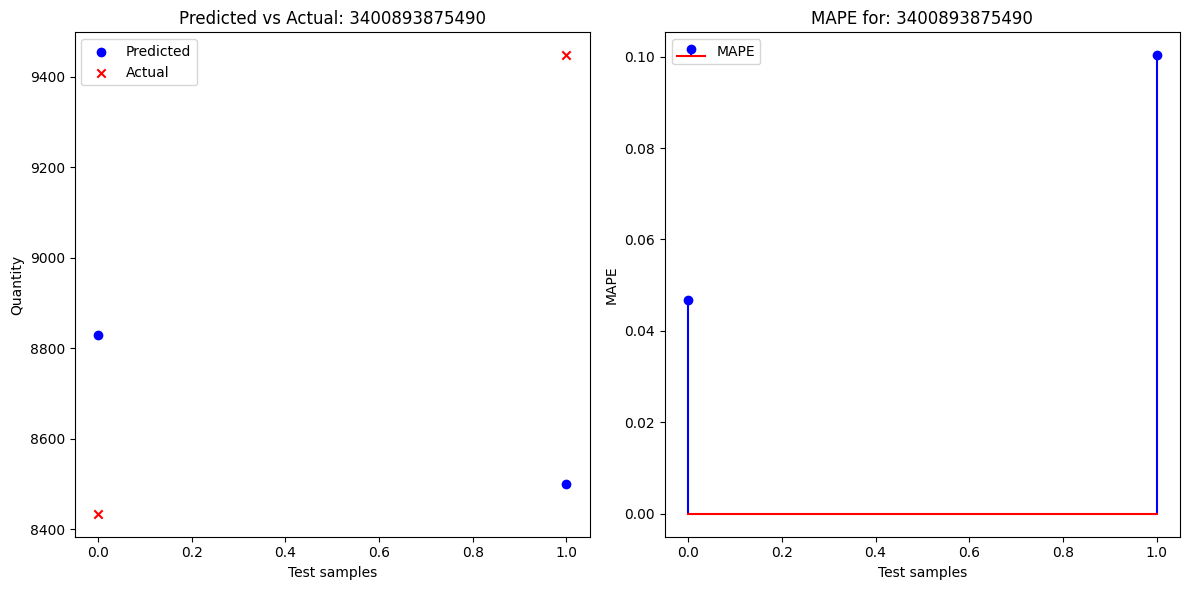

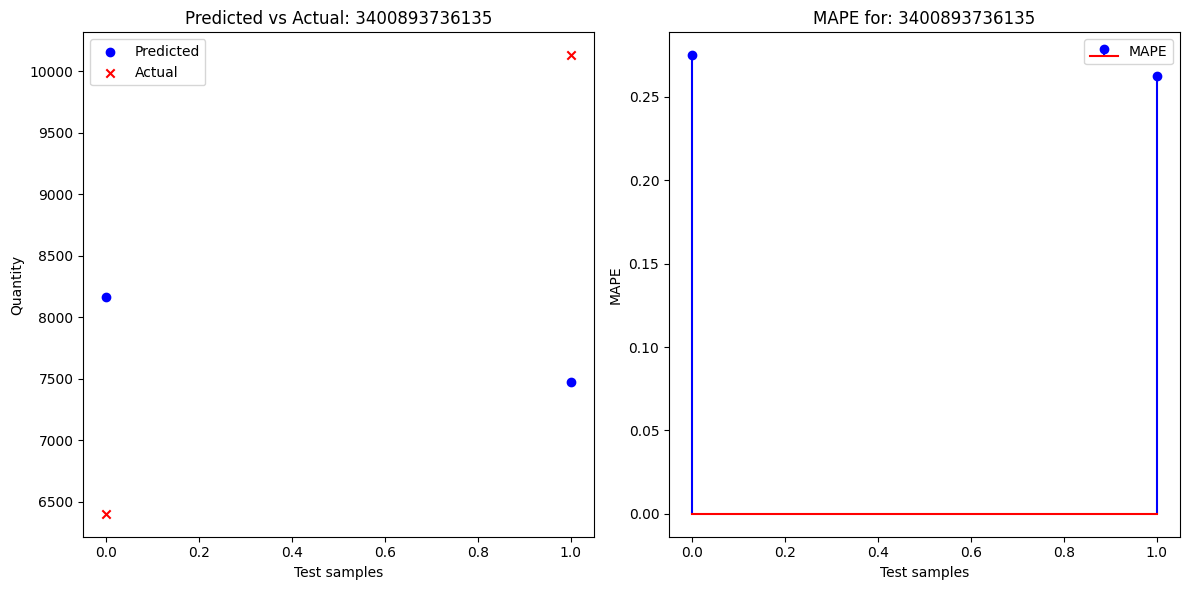

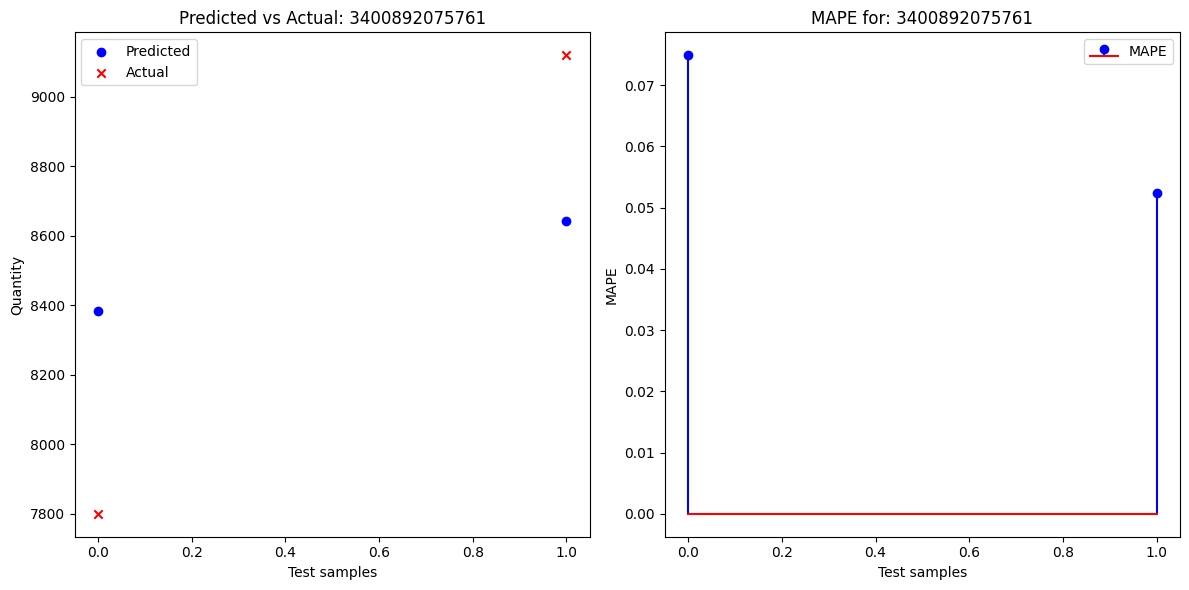

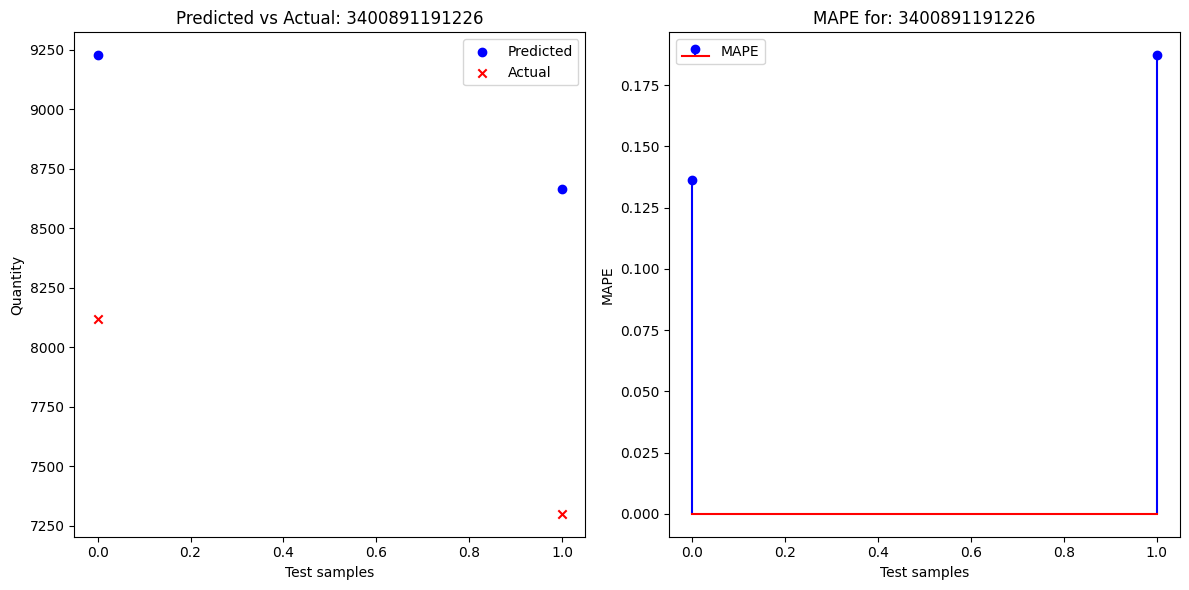

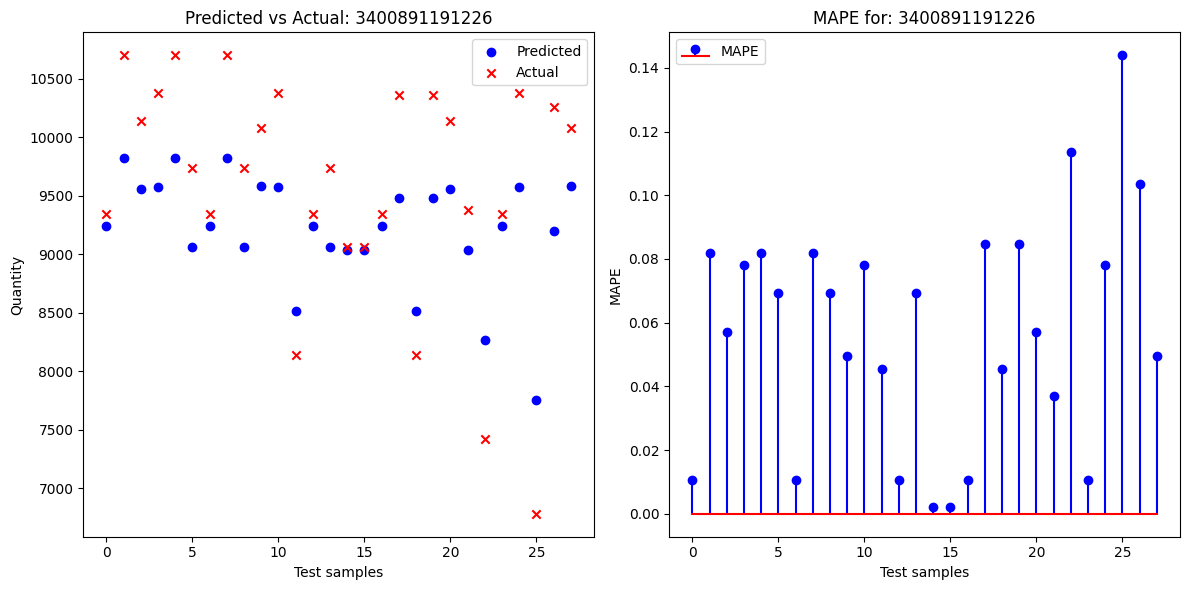

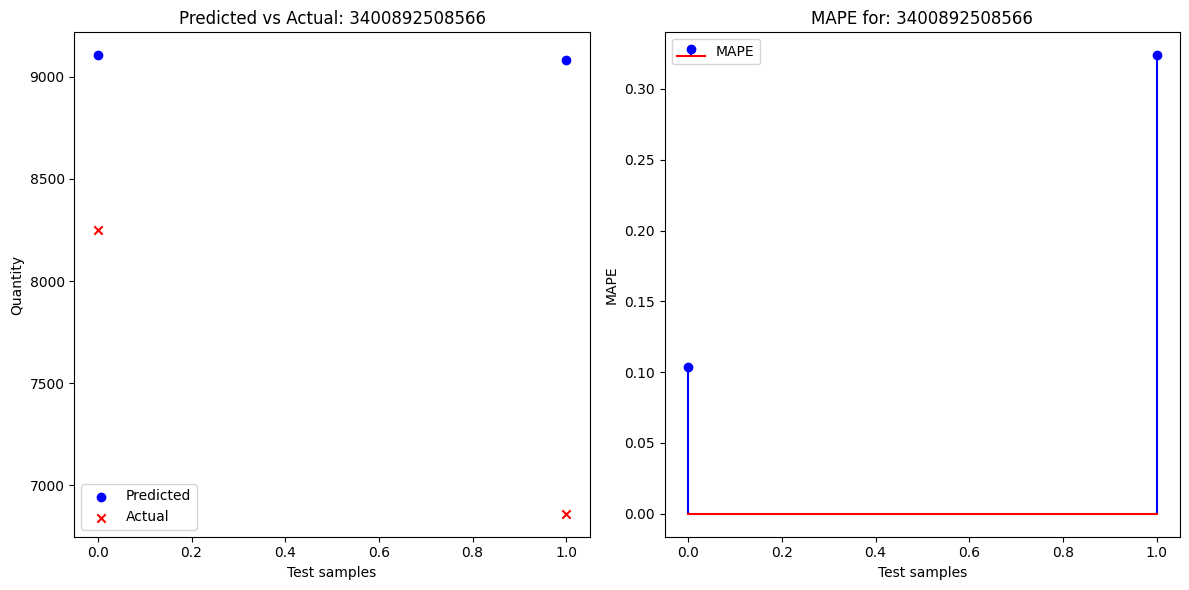

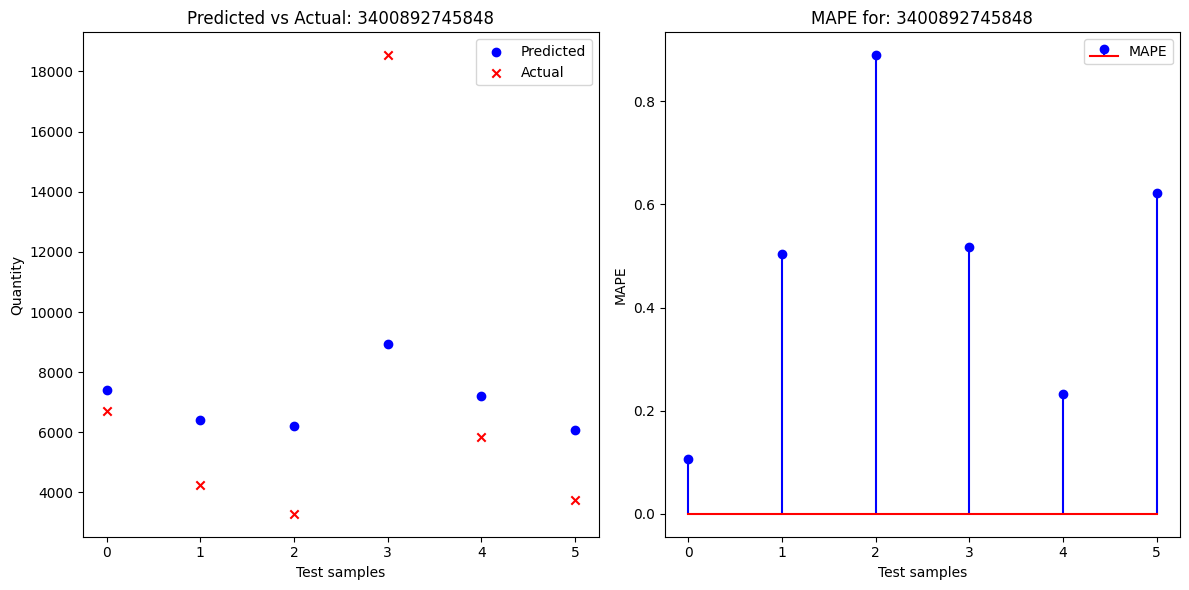

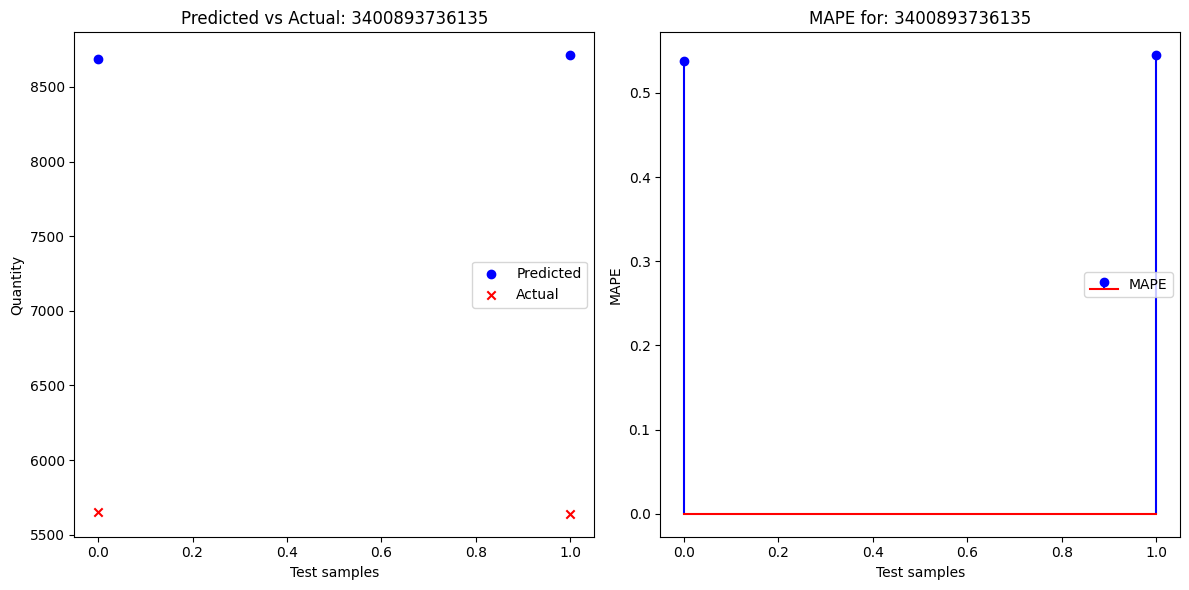

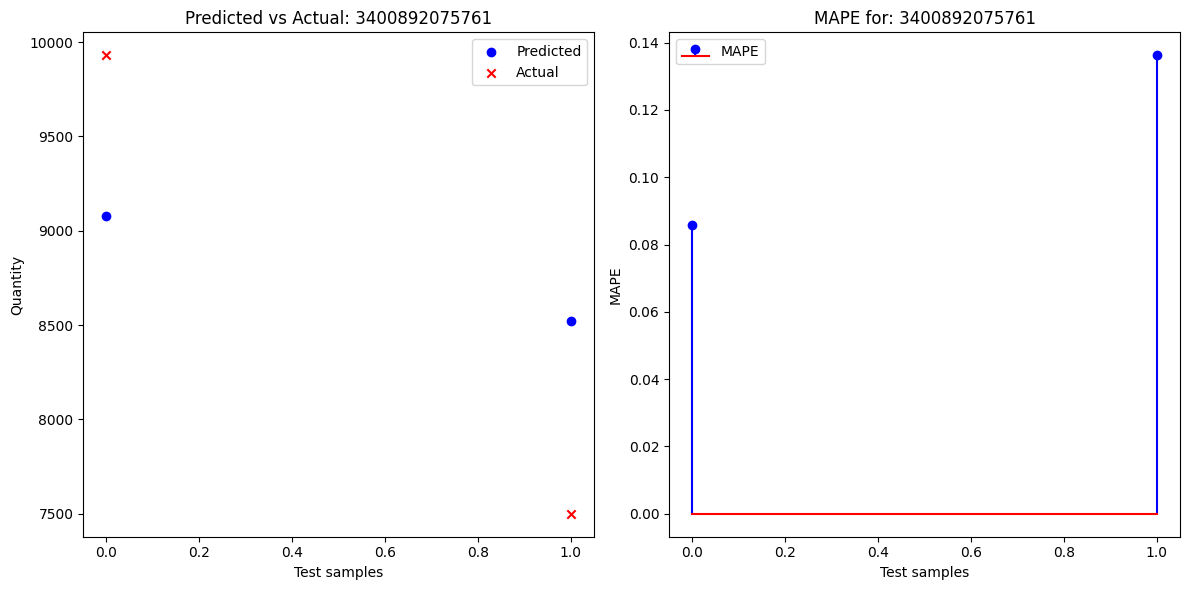

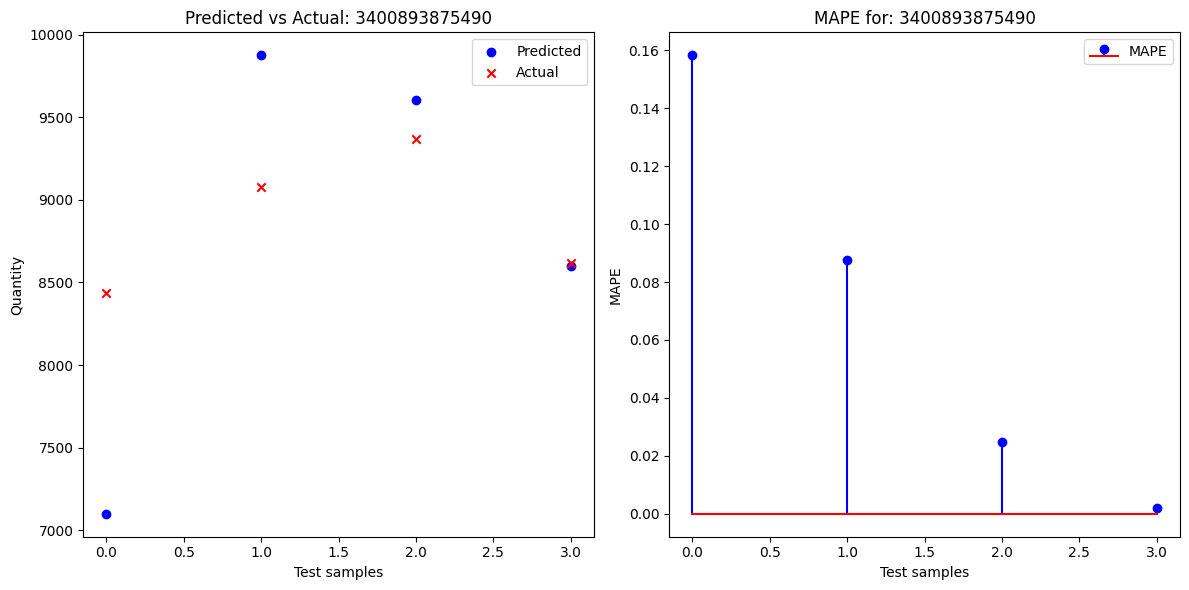

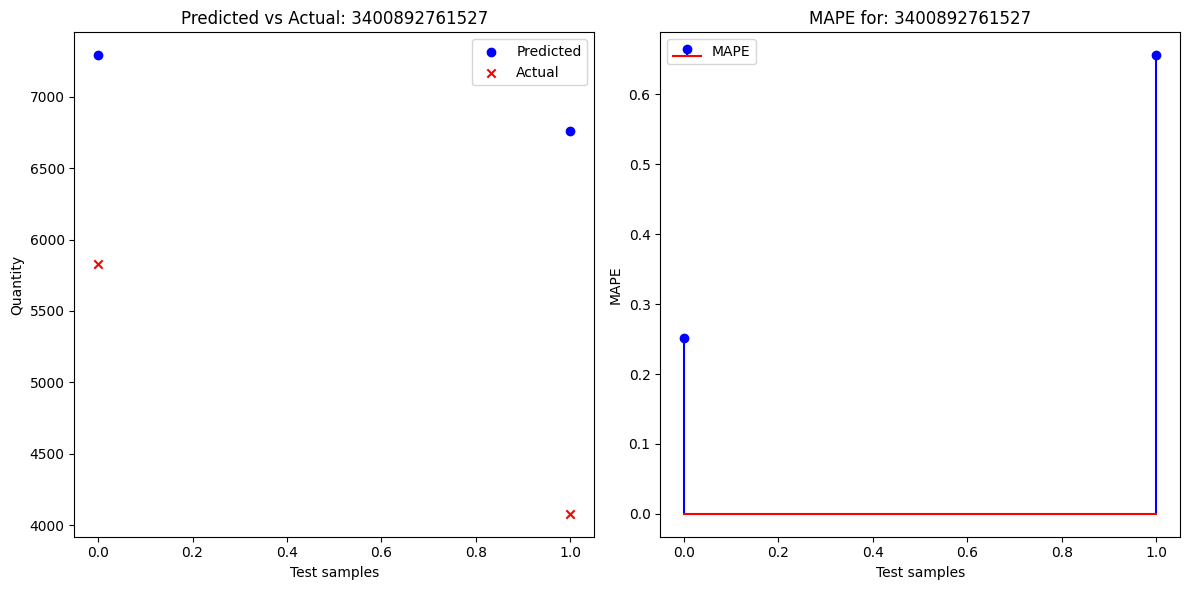

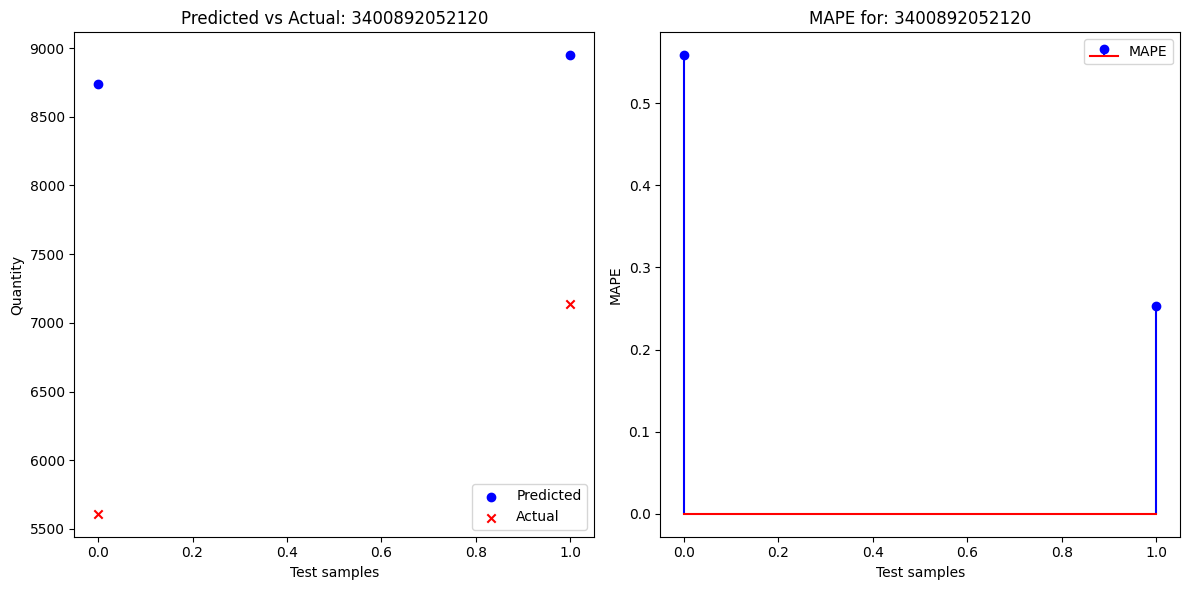

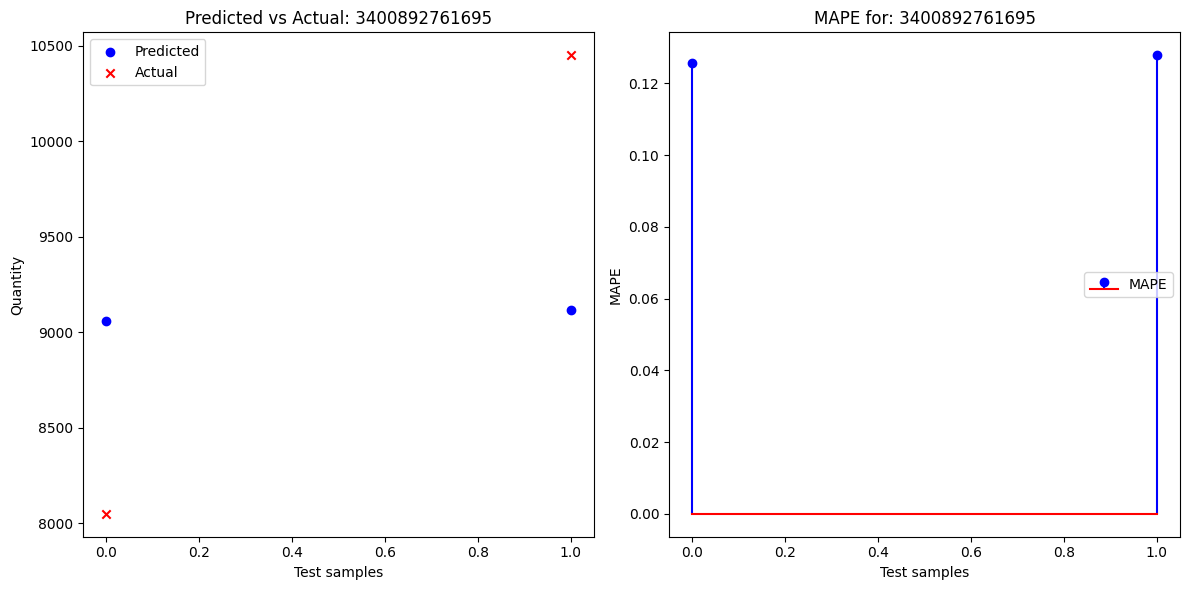

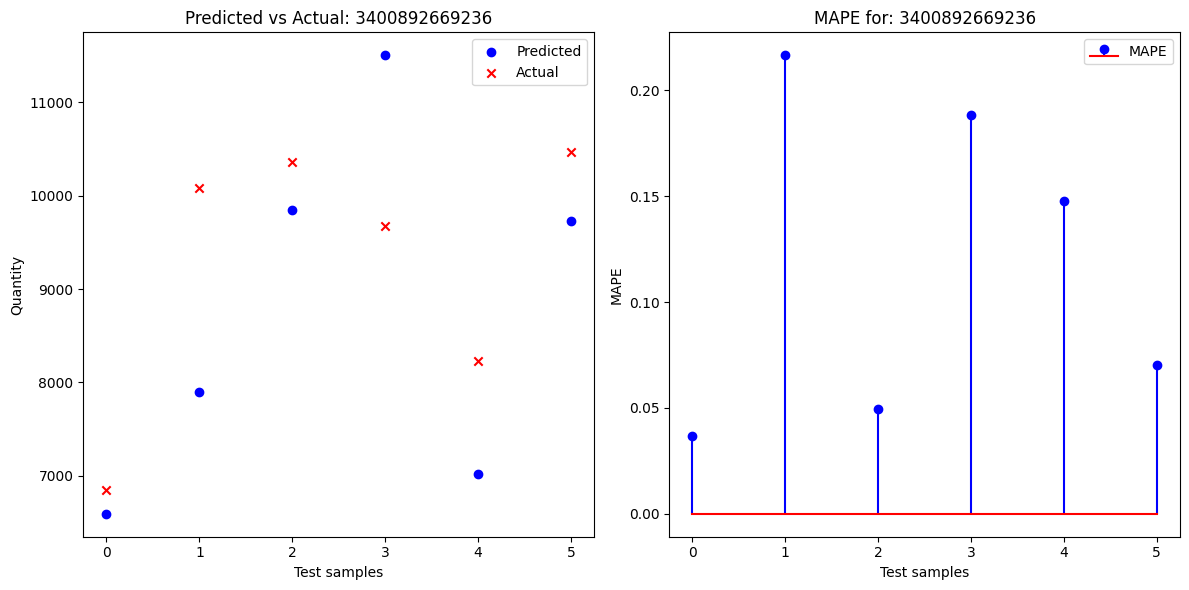

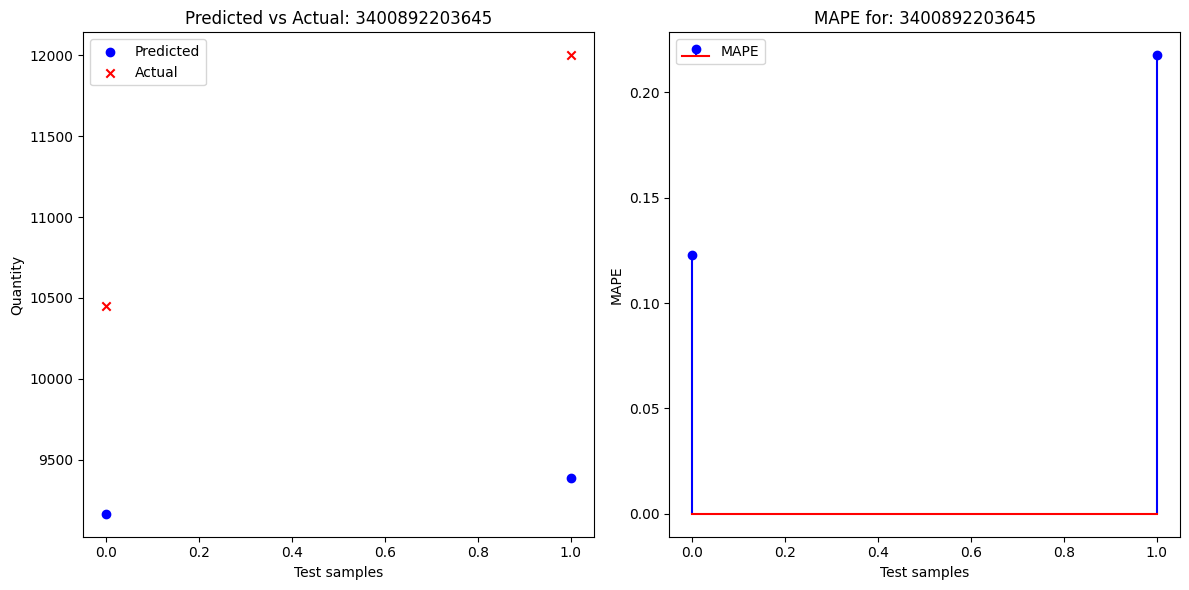

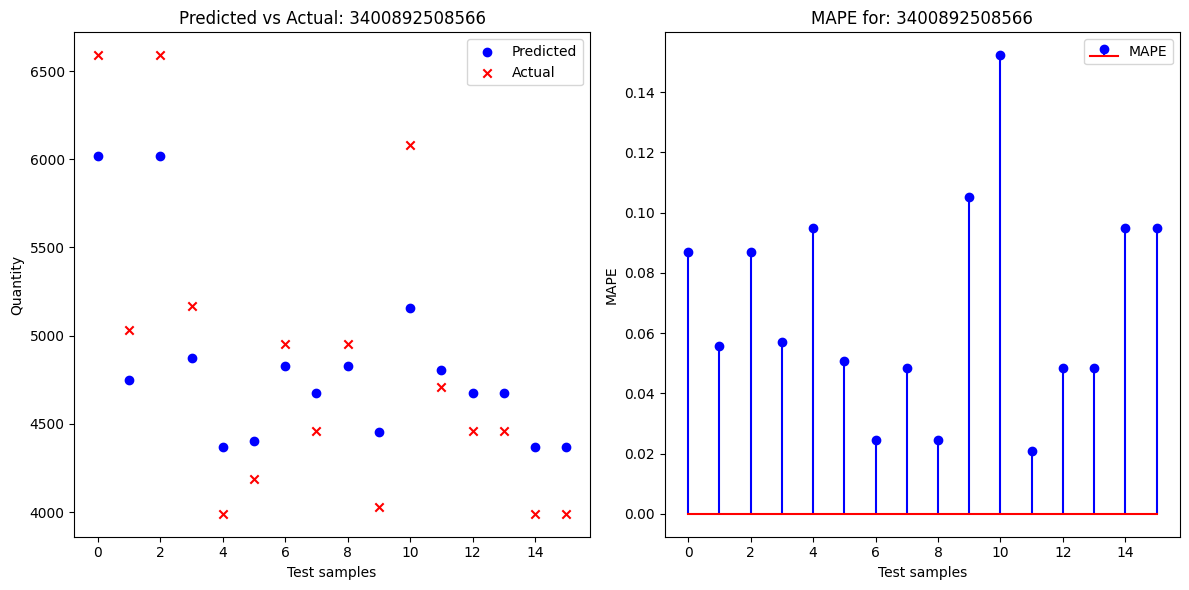

Error in callback <function flush_figures at 0x7e75f76c0430> (for post_execute):


KeyboardInterrupt: ignored

In [149]:
df_comparisons.columns
df_comparisons['code_a'] = df_comparisons['med_a'] + '_' + df_comparisons['hospi_a']
df_comparisons['code_b'] = df_comparisons['med_b'] + '_' + df_comparisons['hospi_b']

codes = set(df_comparisons['code_a']).union(set(df_comparisons['code_b']))
df_scores = pd.DataFrame(columns=[
    'PAIR', 'HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'
])

cluster = 0

for code in codes:
  df_cluster_temp = df_comparisons[(df_comparisons['code_a'] == code) | (df_comparisons['code_b'] == code)][['med_a', 'hospi_a', 'med_b', 'hospi_b']]
  df_meds = pd.DataFrame()
  df_scores_cluster = pd.DataFrame(columns=['CLUSTER', 'HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'])

  for i, row in df_cluster_temp.iterrows():
    processed_pair = pd.DataFrame()

    med_a = row['med_a']
    med_b = row['med_b']
    hospi_a = row['hospi_a']
    hospi_b = row['hospi_b']

    processed_pair = df_ma_6[(((df_ma_6['HOSPI_CODE_UCD'] == med_a) & (df_ma_6['ID_SITE_RATTACHE'] == hospi_a)) |
                             ((df_ma_6['HOSPI_CODE_UCD'] == med_b) & (df_ma_6['ID_SITE_RATTACHE'] == hospi_b))) &
                             (df_ma_6['DATE'] >= start_date) &
                             (df_ma_6['DATE'] <= end_date)

                            ]
    df_meds = pd.concat([df_meds, processed_pair], ignore_index = True)
  df_scores_cluster = test_pairs_cluster(df_meds, df_scores_cluster, cluster, verbose = True)
  cluster += 1
df_scores_cluster